In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# SVR, Decision Tree, Ensemble Methods, LSTM, GRU

---




## Import Libraries

In [ ]:
!pip install plotly
!pip install xgboost
!pip install catboost
!pip install ngboost
!pip install shap

In [118]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import os

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from catboost.utils import eval_metric
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import cycle

import pickle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

import shap

## Import Dataset

In [156]:
df = pd.read_csv('pre_samsung_b_sent.csv', encoding='cp949')
df.head()

,Date,Close,foreign,volatility,consumption,yield_bond,snp500,fng,gold,copper,...,pork,usd_krw,cny_krw,eur_krw,jpy_krw,covid,blob_score,norm_score,MA(5),MA(10)
0,2019-01-15,404000,1503584000.0000,14.8500,1226.8600,1213.6800,2582.6101,16.0000,46630.0000,2.7050,...,61.8500,112180.0000,166.6600,128743.0000,10.3712,0.0000,0.1459,0.2500,395500.0000,388300.0000
1,2019-01-16,399000,-4262919000.0000,14.9500,1231.1200,1214.1500,2610.3000,27.0000,46580.0000,2.6920,...,62.1500,112285.0000,166.6600,128159.0000,10.3333,0.0000,0.1434,0.2500,397900.0000,390800.0000
2,2019-01-17,386000,-3834955000.0000,14.6000,1223.3300,1213.5600,2616.1001,24.0000,46580.0000,2.7205,...,60.0500,112078.0000,166.6600,127763.0000,10.2735,0.0000,0.1465,0.2500,397500.0000,391750.0000
3,2019-01-18,400000,-5103310500.0000,15.0000,1208.5500,1213.3200,2635.9600,28.0000,46700.0000,2.7350,...,60.8500,112270.0000,166.6600,127926.0000,10.2774,0.0000,0.1357,0.2500,398400.0000,393650.0000
4,2019-01-21,397000,10489875000.0000,14.7000,1223.8600,1211.0200,2670.7100,29.0000,46700.0000,2.7645,...,61.2300,112608.0000,166.6600,127957.0000,10.2581,0.0000,0.1311,0.2500,397200.0000,394550.0000


# 3년

# Prepare Data for Analysis

In [157]:
training_size = int(len(df)*0.9)

df_train = df.loc[:training_size, :]
df_test = df.loc[training_size:, :]

In [158]:
df_train.drop(['Date'], axis=1, inplace=True)
df_test.drop(['Date'], axis=1, inplace=True)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [159]:
scaler = RobustScaler()
scaler.fit(df_train)

df_train[df_train.columns] = scaler.transform(df_train[df_train.columns]) 
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns]) 
# df = pd.DataFrame(scale.fit_transform(df.values), columns=df.columns, index=df.index)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
# feature_columns = list(df.columns.difference(['Close']))
feature_columns = list(df_train.columns.difference(['Close']))

In [161]:
y_train = df_train['Close']
X_train = df_train.drop(['Close'], axis=1)

y_test = df_test['Close']
X_test = df_test.drop(['Close'], axis=1)

## Decision Tree

In [162]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [163]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)), "\nTrain R2: ", r2_score(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred), "\nTest R2: ", r2_score(y_test, dt_pred))

Train MSE:  0.0017309500998105199 
Train R2:  0.9937412103877926

Test MSE:  0.011413235046269336 
Test R2:  -0.7518106715614516


In [164]:
dt.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 6.82580103e-04, 0.00000000e+00,
       0.00000000e+00, 1.73034161e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.97587078e-01, 0.00000000e+00])

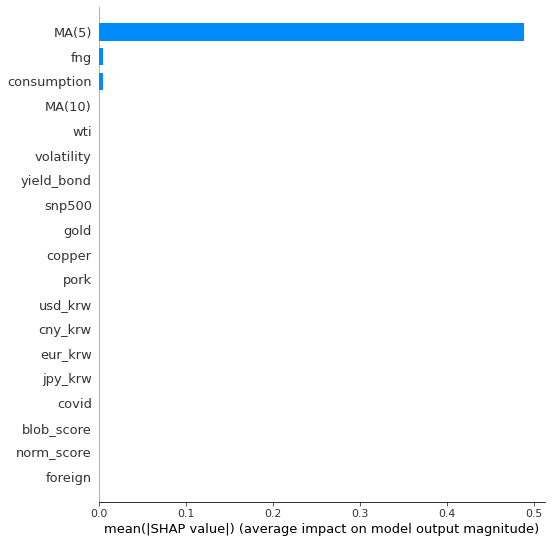

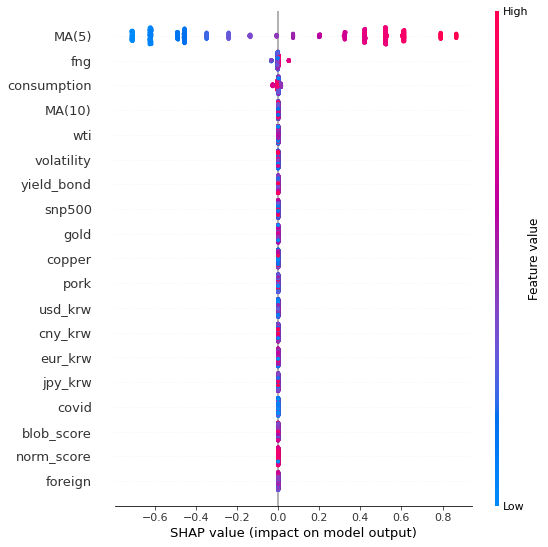

In [165]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Ensemble Methods

### Random Forest

In [166]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

In [167]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)), "\nTrain R2: ", r2_score(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred), "\nTest R2: ", r2_score(y_test, rf_pred))

Train MSE:  0.00016329041785013475 
Train R2:  0.9994095725976587

Test MSE:  0.0079078587604714 
Test R2:  -0.2137725464895852


In [168]:
rf.feature_importances_

array([5.95033826e-04, 3.39797201e-04, 3.97108117e-04, 2.70600516e-04,
       4.34009871e-04, 1.62310489e-03, 3.50949370e-04, 4.80384718e-04,
       3.99150556e-04, 2.67268785e-04, 4.77306045e-04, 6.68027117e-04,
       1.96711558e-04, 3.39993076e-04, 5.99886048e-04, 1.91454428e-04,
       1.50322328e-04, 7.36251682e-01, 2.55967209e-01])

 95%|=================== | 624/659 [00:14<00:00]       

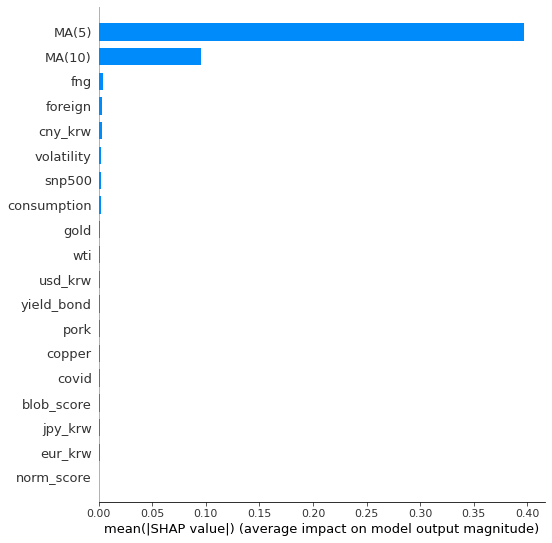

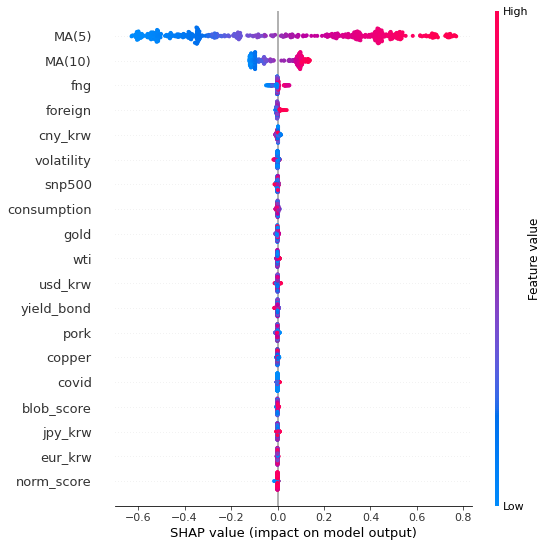

In [169]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### adaBoosting

In [170]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [171]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ada.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, ada_pred), "\nTest R2: ", r2_score(y_test, ada_pred))

Train MSE:  0.001602560022489961 
Train R2:  0.9942054447307309
Test MSE:  0.006703259030968171 
Test R2:  -0.028879249142347296


In [172]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

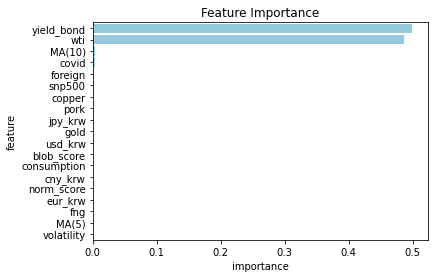

In [173]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

### XGBoosting

In [174]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [175]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred), "\nTest R2: ", r2_score(y_test, xgb_pred))

Train MSE:  9.893308789837572e-07 
Train R2:  0.9999964227658388

Test MSE:  0.00645914448746469 
Test R2:  0.008589747216624088


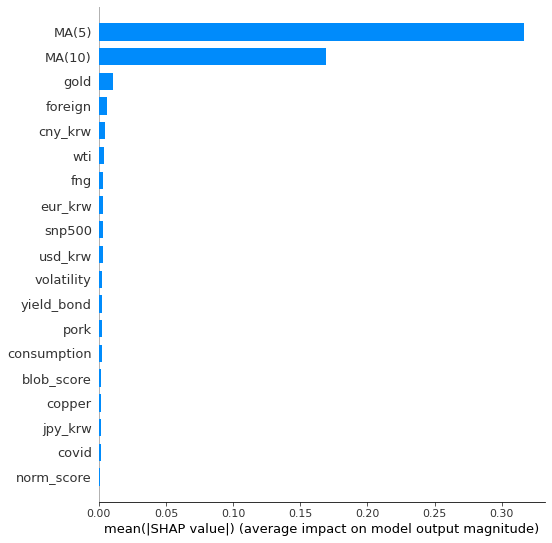

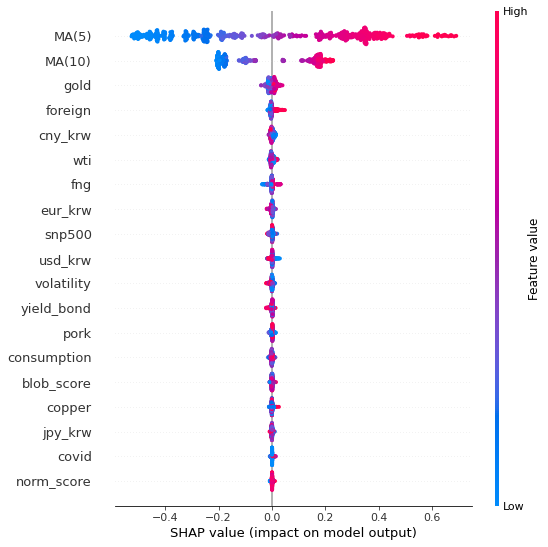

In [176]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### CatBoosting

In [177]:
cat = CatBoostRegressor(iterations=100, verbose=10)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_pred = cat.predict(X_train)

Learning rate set to 0.194295
0:	learn: 0.4361284	test: 0.6337965	best: 0.6337965 (0)	total: 1.99ms	remaining: 197ms
10:	learn: 0.0895085	test: 0.2327784	best: 0.2327784 (10)	total: 20.6ms	remaining: 166ms
20:	learn: 0.0470146	test: 0.1829443	best: 0.1829443 (20)	total: 42.1ms	remaining: 158ms
30:	learn: 0.0379218	test: 0.1729258	best: 0.1729258 (30)	total: 63.8ms	remaining: 142ms
40:	learn: 0.0325299	test: 0.1734570	best: 0.1724027 (37)	total: 87ms	remaining: 125ms
50:	learn: 0.0292517	test: 0.1740157	best: 0.1724027 (37)	total: 110ms	remaining: 105ms
60:	learn: 0.0261557	test: 0.1729073	best: 0.1724027 (37)	total: 131ms	remaining: 83.8ms
70:	learn: 0.0240652	test: 0.1744495	best: 0.1724027 (37)	total: 153ms	remaining: 62.4ms
80:	learn: 0.0219074	test: 0.1760406	best: 0.1724027 (37)	total: 175ms	remaining: 41.1ms
90:	learn: 0.0199572	test: 0.1757620	best: 0.1724027 (37)	total: 200ms	remaining: 19.8ms
99:	learn: 0.0186694	test: 0.1781255	best: 0.1724027 (37)	total: 221ms	remaining: 0us

In [178]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.23334296000481608 
Train R2:  0.15627579655836055

Test MSE:  0.2652003859576397 
Test R2:  -39.70544979923701


#### GridSearch

In [179]:
cat = CatBoostRegressor()

params = {
            'iterations':[100,500],
            'learning_rate':[0.01, 0.1],
            'verbose':[0.1,10],
            'bootstrap_type':['Bayesian', 'No']
}

search_results = cat.grid_search(params, X_train, y_train, cv=5)

print("\nBest Params : ", search_results['params'])

0:	learn: 0.5227460	test: 0.5243548	best: 0.5243548 (0)	total: 2.62ms	remaining: 259ms
10:	learn: 0.4801939	test: 0.4813654	best: 0.4813654 (10)	total: 23.6ms	remaining: 191ms
20:	learn: 0.4405885	test: 0.4420634	best: 0.4420634 (20)	total: 50.9ms	remaining: 192ms
30:	learn: 0.4047779	test: 0.4058063	best: 0.4058063 (30)	total: 75.9ms	remaining: 169ms
40:	learn: 0.3717549	test: 0.3726796	best: 0.3726796 (40)	total: 101ms	remaining: 145ms
50:	learn: 0.3420638	test: 0.3430690	best: 0.3430690 (50)	total: 125ms	remaining: 120ms
60:	learn: 0.3143074	test: 0.3154080	best: 0.3154080 (60)	total: 150ms	remaining: 95.9ms
70:	learn: 0.2891500	test: 0.2904196	best: 0.2904196 (70)	total: 177ms	remaining: 72.4ms
80:	learn: 0.2660822	test: 0.2672913	best: 0.2672913 (80)	total: 201ms	remaining: 47.1ms
90:	learn: 0.2452753	test: 0.2464576	best: 0.2464576 (90)	total: 225ms	remaining: 22.2ms
99:	learn: 0.2277112	test: 0.2289436	best: 0.2289436 (99)	total: 246ms	remaining: 0us

bestTest = 0.2289435925
bes

440:	learn: 0.0409815	test: 0.0528508	best: 0.0528508 (440)	total: 1.1s	remaining: 147ms
450:	learn: 0.0403001	test: 0.0522593	best: 0.0522593 (450)	total: 1.13s	remaining: 122ms
460:	learn: 0.0396561	test: 0.0517959	best: 0.0517959 (460)	total: 1.15s	remaining: 97.3ms
470:	learn: 0.0390200	test: 0.0512609	best: 0.0512609 (470)	total: 1.17s	remaining: 72.3ms
480:	learn: 0.0384487	test: 0.0509119	best: 0.0509119 (480)	total: 1.2s	remaining: 47.3ms
490:	learn: 0.0379251	test: 0.0505523	best: 0.0505523 (490)	total: 1.23s	remaining: 22.5ms
499:	learn: 0.0374975	test: 0.0502104	best: 0.0502104 (499)	total: 1.25s	remaining: 0us

bestTest = 0.05021042713
bestIteration = 499

4:	loss: 0.0502104	best: 0.0444912 (3)	total: 2.29s	remaining: 5.04s
0:	learn: 0.5228177	test: 0.5245561	best: 0.5245561 (0)	total: 3.18ms	remaining: 1.59s
10:	learn: 0.4798937	test: 0.4816411	best: 0.4816411 (10)	total: 26.5ms	remaining: 1.18s
20:	learn: 0.4398081	test: 0.4412820	best: 0.4412820 (20)	total: 60ms	remainin

310:	learn: 0.0109107	test: 0.0442248	best: 0.0441979 (308)	total: 816ms	remaining: 496ms
320:	learn: 0.0105303	test: 0.0440808	best: 0.0440808 (320)	total: 854ms	remaining: 476ms
330:	learn: 0.0101823	test: 0.0440525	best: 0.0440437 (326)	total: 886ms	remaining: 452ms
340:	learn: 0.0098234	test: 0.0440424	best: 0.0440407 (336)	total: 914ms	remaining: 426ms
350:	learn: 0.0094802	test: 0.0439525	best: 0.0439525 (350)	total: 958ms	remaining: 407ms
360:	learn: 0.0091979	test: 0.0439020	best: 0.0438802 (359)	total: 992ms	remaining: 382ms
370:	learn: 0.0088462	test: 0.0439061	best: 0.0438802 (359)	total: 1.02s	remaining: 356ms
380:	learn: 0.0085707	test: 0.0438285	best: 0.0438279 (373)	total: 1.05s	remaining: 328ms
390:	learn: 0.0083350	test: 0.0438516	best: 0.0438279 (373)	total: 1.09s	remaining: 303ms
400:	learn: 0.0080591	test: 0.0437702	best: 0.0437702 (400)	total: 1.11s	remaining: 274ms
410:	learn: 0.0078078	test: 0.0436439	best: 0.0436439 (410)	total: 1.13s	remaining: 245ms
420:	learn

210:	learn: 0.0155849	test: 0.0320660	best: 0.0320020 (207)	total: 544ms	remaining: 746ms
220:	learn: 0.0149672	test: 0.0320133	best: 0.0320020 (207)	total: 571ms	remaining: 720ms
230:	learn: 0.0145233	test: 0.0319882	best: 0.0319754 (225)	total: 594ms	remaining: 692ms
240:	learn: 0.0138755	test: 0.0319335	best: 0.0319196 (237)	total: 621ms	remaining: 668ms
250:	learn: 0.0132444	test: 0.0318298	best: 0.0318298 (250)	total: 647ms	remaining: 641ms
260:	learn: 0.0126820	test: 0.0317583	best: 0.0317583 (260)	total: 670ms	remaining: 613ms
270:	learn: 0.0122222	test: 0.0317600	best: 0.0316953 (266)	total: 697ms	remaining: 589ms
280:	learn: 0.0118710	test: 0.0317716	best: 0.0316953 (266)	total: 721ms	remaining: 562ms
290:	learn: 0.0115608	test: 0.0316862	best: 0.0316862 (290)	total: 746ms	remaining: 536ms
300:	learn: 0.0112282	test: 0.0316213	best: 0.0316213 (300)	total: 770ms	remaining: 509ms
310:	learn: 0.0108305	test: 0.0315374	best: 0.0315192 (309)	total: 797ms	remaining: 484ms
320:	learn

150:	learn: 0.0198968	test: 0.0518546	best: 0.0518098 (149)	total: 369ms	remaining: 852ms
160:	learn: 0.0190097	test: 0.0516681	best: 0.0516681 (160)	total: 392ms	remaining: 826ms
170:	learn: 0.0183527	test: 0.0516598	best: 0.0516535 (165)	total: 419ms	remaining: 805ms
180:	learn: 0.0173220	test: 0.0515236	best: 0.0515189 (179)	total: 444ms	remaining: 783ms
190:	learn: 0.0166196	test: 0.0514703	best: 0.0513781 (183)	total: 468ms	remaining: 757ms
200:	learn: 0.0160083	test: 0.0514380	best: 0.0513199 (197)	total: 498ms	remaining: 741ms
210:	learn: 0.0153830	test: 0.0513358	best: 0.0513199 (197)	total: 526ms	remaining: 720ms
220:	learn: 0.0147031	test: 0.0512760	best: 0.0512760 (220)	total: 551ms	remaining: 696ms
230:	learn: 0.0139513	test: 0.0511214	best: 0.0511214 (230)	total: 581ms	remaining: 677ms
240:	learn: 0.0132465	test: 0.0509791	best: 0.0509577 (239)	total: 604ms	remaining: 649ms
250:	learn: 0.0127017	test: 0.0509492	best: 0.0508852 (245)	total: 626ms	remaining: 621ms
260:	learn

70:	learn: 0.0320851	test: 0.0450066	best: 0.0450066 (70)	total: 180ms	remaining: 1.08s
80:	learn: 0.0301508	test: 0.0442680	best: 0.0442680 (80)	total: 203ms	remaining: 1.05s
90:	learn: 0.0283822	test: 0.0435436	best: 0.0435436 (90)	total: 226ms	remaining: 1.02s
100:	learn: 0.0266056	test: 0.0427540	best: 0.0427241 (99)	total: 254ms	remaining: 1s
110:	learn: 0.0251551	test: 0.0422700	best: 0.0422645 (108)	total: 280ms	remaining: 980ms
120:	learn: 0.0235823	test: 0.0413812	best: 0.0413812 (120)	total: 304ms	remaining: 952ms
130:	learn: 0.0221837	test: 0.0407489	best: 0.0407353 (129)	total: 333ms	remaining: 939ms
140:	learn: 0.0209491	test: 0.0403050	best: 0.0403050 (140)	total: 360ms	remaining: 916ms
150:	learn: 0.0199738	test: 0.0402134	best: 0.0401901 (143)	total: 384ms	remaining: 888ms
160:	learn: 0.0189718	test: 0.0397529	best: 0.0397340 (158)	total: 410ms	remaining: 862ms
170:	learn: 0.0181368	test: 0.0394375	best: 0.0394309 (169)	total: 439ms	remaining: 845ms
180:	learn: 0.017469

In [180]:
cat = CatBoostRegressor(iterations=500, verbose=10, learning_rate= 0.1, bootstrap_type= 'Bayesian')

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_preds = cat.predict(X_train)

0:	learn: 0.4798635	test: 0.6595527	best: 0.6595527 (0)	total: 2.84ms	remaining: 1.42s
10:	learn: 0.2002950	test: 0.3221051	best: 0.3221051 (10)	total: 25.6ms	remaining: 1.14s
20:	learn: 0.0964831	test: 0.2028692	best: 0.2028692 (20)	total: 50ms	remaining: 1.14s
30:	learn: 0.0582839	test: 0.1505128	best: 0.1505128 (30)	total: 76.5ms	remaining: 1.16s
40:	learn: 0.0453114	test: 0.1341422	best: 0.1341422 (40)	total: 102ms	remaining: 1.14s
50:	learn: 0.0391735	test: 0.1303734	best: 0.1303734 (50)	total: 126ms	remaining: 1.1s
60:	learn: 0.0360744	test: 0.1290668	best: 0.1290668 (60)	total: 149ms	remaining: 1.07s
70:	learn: 0.0332455	test: 0.1285812	best: 0.1285518 (69)	total: 171ms	remaining: 1.03s
80:	learn: 0.0310149	test: 0.1281646	best: 0.1279292 (78)	total: 196ms	remaining: 1.01s
90:	learn: 0.0295079	test: 0.1283923	best: 0.1279292 (78)	total: 220ms	remaining: 991ms
100:	learn: 0.0278795	test: 0.1286956	best: 0.1279292 (78)	total: 243ms	remaining: 961ms
110:	learn: 0.0264871	test: 0.12

In [181]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.2033871979976059 
Train R2:  0.2645901911194781

Test MSE:  0.29106243060039966 
Test R2:  -43.67499967794512


In [182]:
cat.feature_importances_

array([ 0.8745154 ,  1.18252849,  0.99485439,  0.70666928,  3.63224048,
        1.89826939, 21.60466833,  2.87145857,  2.07504695,  1.24455283,
        0.32171629,  1.15637091,  0.44462756,  0.76150898,  1.86341773,
        2.07583498,  0.07939218, 22.97192326, 33.24040402])

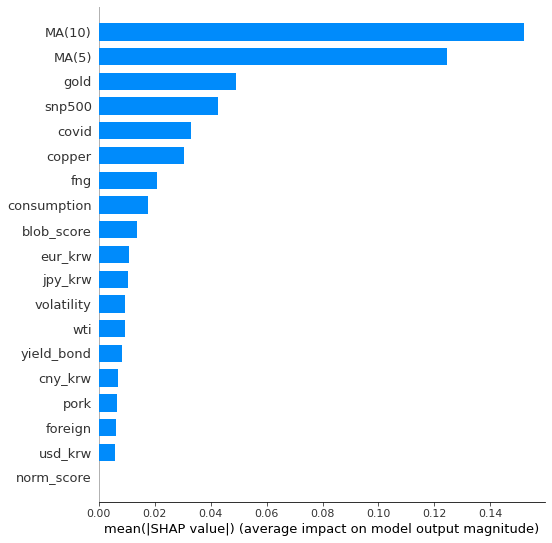

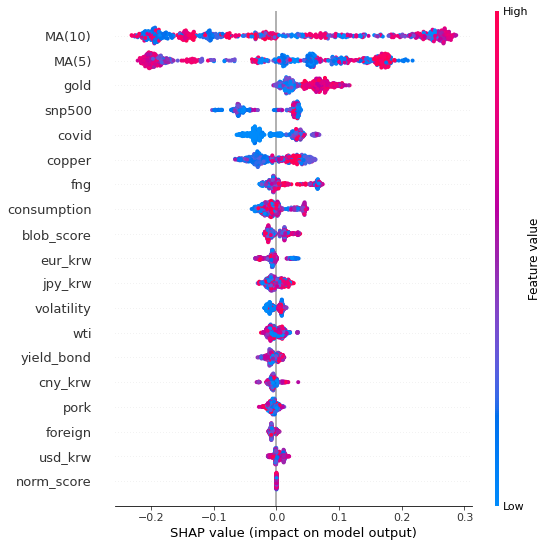

In [183]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [184]:
# plt.figure(figsize=(15,5))

# plt.plot(cat_pred, c="r", label="Cat", linewidth=2)
# plt.plot(y_test, c='g', label="True", linewidth=1)

# plt.ylabel("target")
# plt.title("CatBoosted Decision Tree Regression")
# plt.legend()
# plt.show()

### NGBoosting

In [185]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=0.7763 val_loss=0.0000 scale=1.0000 norm=0.5924
[iter 100] loss=-0.3683 val_loss=0.0000 scale=2.0000 norm=0.9342
[iter 200] loss=-1.3093 val_loss=0.0000 scale=2.0000 norm=0.9298
[iter 300] loss=-2.0919 val_loss=0.0000 scale=2.0000 norm=0.8263
[iter 400] loss=-2.5543 val_loss=0.0000 scale=2.0000 norm=0.7625


Negative Loss
- https://discuss.pytorch.org/t/negative-value-in-my-loss-function/101776

In [186]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred), "\nTest R2: ", r2_score(y_test, ngb_pred))

Train MSE:  0.0003568073631634795 
Train R2:  0.9987098517638543

Test MSE:  0.0037966119166427453 
Test R2:  0.41726029084749783


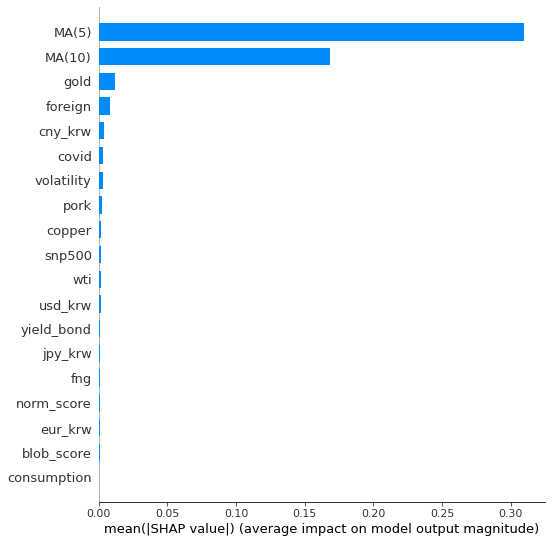

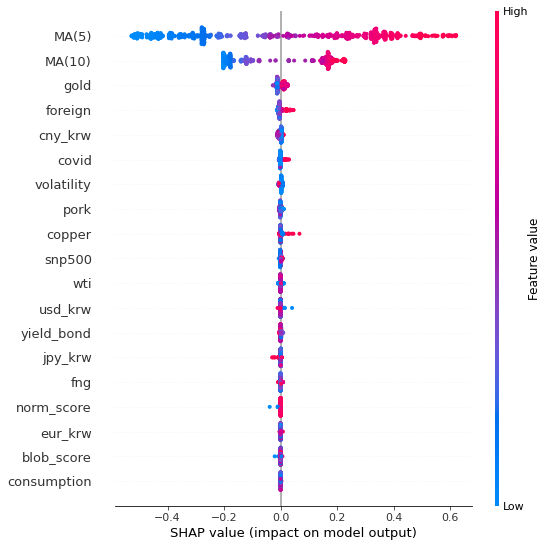

In [187]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Summary

### Prediction + Graph

In [188]:
final_pred = pd.DataFrame({
    # 'svr':svrdf,
    'dt': dt_pred,
    'rf': rf_pred,
    # 'ada': ada_pred,
    'xgb': xgb_pred,
#     'cat': cat_pred,
    'ngb': ngb_pred,
    'true': y_test
    # 'lstm': lstm_pred
})

pd.options.display.float_format = '{:.4f}'.format
final_pred.head()

,dt,rf,xgb,ngb,true
658,0.6859,0.7261,0.7210,0.7333,0.7212
659,0.6859,0.7239,0.7264,0.7407,0.7212
660,0.6859,0.7275,0.7435,0.7519,0.7758
661,0.6859,0.7266,0.7386,0.7753,0.7284
662,0.6859,0.7263,0.7251,0.7440,0.7687


In [189]:
final_pred.tail()

,dt,rf,xgb,ngb,true
727,0.6859,0.7102,0.6503,0.7317,0.6548
728,0.6859,0.7049,0.6448,0.7103,0.6572
729,0.6859,0.7069,0.6546,0.7226,0.6690
730,0.6859,0.7019,0.6455,0.7102,0.6667
731,0.6859,0.6960,0.6377,0.6952,0.6975


In [190]:
model_names = [dt, rf, xgb, cat, ngb]

r2_train = []
r2_test = []
MSE_train = []
MSE_test = []
for model in model_names:
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_test.append(r2_score(y_test, model.predict(X_test)))
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [191]:
evaluation = pd.DataFrame([MSE_train, MSE_test, r2_train, r2_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'XGBoosting', 'CatBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test', 'R2_train', 'R2_test']))

evaluation

,Decision Tree,Random Forest,XGBoosting,CatBoosting,NGBoosting
MSE_train,0.0017,0.0002,0.0000,0.2034,0.0004
MSE_test,0.0114,0.0079,0.0065,0.2911,0.0038
R2_train,0.9937,0.9994,1.0000,0.2646,0.9987
R2_test,-0.7518,-0.2138,0.0086,-43.6750,0.4173


In [192]:
names = cycle(['dt',	'rf',	'xgb',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['xgb'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [193]:
from sklearn import model_selection
from keras.wrappers.scikit_learn import KerasClassifier

models = []
# models.append(('SVM', SVR()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
# models.append(('adaBoosting', AdaBoostRegressor()))
models.append(('XGBoosting', XGBRegressor()))
models.append(('CatBoosting', CatBoostRegressor()))
models.append(('NGBoosting', NGBRegressor()))
# models.append(('LSTM', lstm))
# models.append(('GRU', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
seed=42

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	if name != 'LSTM':
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	else :
		lstm = Sequential()
		lstm.add(Dense(50, input_dim=18, activation='relu'))
		lstm.add(Dense(50, activation='relu'))
		lstm.add(Dense(1)) 
		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	# print(msg)

print(results) 

Learning rate set to 0.037698
0:	learn: 0.5065356	total: 2.83ms	remaining: 2.82s
1:	learn: 0.4897401	total: 5.26ms	remaining: 2.63s
2:	learn: 0.4739475	total: 7.62ms	remaining: 2.53s
3:	learn: 0.4595709	total: 9.92ms	remaining: 2.47s
4:	learn: 0.4449331	total: 12.3ms	remaining: 2.46s
5:	learn: 0.4305641	total: 14.6ms	remaining: 2.42s
6:	learn: 0.4164083	total: 17.1ms	remaining: 2.42s
7:	learn: 0.4026608	total: 19.5ms	remaining: 2.42s
8:	learn: 0.3901066	total: 22ms	remaining: 2.42s
9:	learn: 0.3772973	total: 24.3ms	remaining: 2.41s
10:	learn: 0.3650766	total: 26.9ms	remaining: 2.42s
11:	learn: 0.3532991	total: 29.4ms	remaining: 2.42s
12:	learn: 0.3419354	total: 32ms	remaining: 2.43s
13:	learn: 0.3311756	total: 34.5ms	remaining: 2.43s
14:	learn: 0.3201180	total: 36.9ms	remaining: 2.42s
15:	learn: 0.3095772	total: 39.3ms	remaining: 2.42s
16:	learn: 0.3002985	total: 41.8ms	remaining: 2.42s
17:	learn: 0.2906310	total: 44.4ms	remaining: 2.42s
18:	learn: 0.2818628	total: 46.9ms	remaining: 2.

230:	learn: 0.0292868	total: 533ms	remaining: 1.77s
231:	learn: 0.0291727	total: 536ms	remaining: 1.77s
232:	learn: 0.0290615	total: 538ms	remaining: 1.77s
233:	learn: 0.0290036	total: 540ms	remaining: 1.77s
234:	learn: 0.0289226	total: 543ms	remaining: 1.77s
235:	learn: 0.0288225	total: 545ms	remaining: 1.76s
236:	learn: 0.0287299	total: 548ms	remaining: 1.76s
237:	learn: 0.0287121	total: 550ms	remaining: 1.76s
238:	learn: 0.0286617	total: 553ms	remaining: 1.76s
239:	learn: 0.0285733	total: 556ms	remaining: 1.76s
240:	learn: 0.0285524	total: 558ms	remaining: 1.76s
241:	learn: 0.0285356	total: 560ms	remaining: 1.75s
242:	learn: 0.0284424	total: 562ms	remaining: 1.75s
243:	learn: 0.0283517	total: 564ms	remaining: 1.75s
244:	learn: 0.0282431	total: 566ms	remaining: 1.75s
245:	learn: 0.0281392	total: 569ms	remaining: 1.74s
246:	learn: 0.0280816	total: 571ms	remaining: 1.74s
247:	learn: 0.0280499	total: 573ms	remaining: 1.74s
248:	learn: 0.0279781	total: 575ms	remaining: 1.74s
249:	learn: 

437:	learn: 0.0195672	total: 1.07s	remaining: 1.37s
438:	learn: 0.0195609	total: 1.07s	remaining: 1.37s
439:	learn: 0.0195438	total: 1.07s	remaining: 1.37s
440:	learn: 0.0194933	total: 1.08s	remaining: 1.37s
441:	learn: 0.0194512	total: 1.08s	remaining: 1.36s
442:	learn: 0.0194088	total: 1.08s	remaining: 1.36s
443:	learn: 0.0193707	total: 1.09s	remaining: 1.36s
444:	learn: 0.0193225	total: 1.09s	remaining: 1.36s
445:	learn: 0.0192805	total: 1.1s	remaining: 1.36s
446:	learn: 0.0192479	total: 1.1s	remaining: 1.36s
447:	learn: 0.0191935	total: 1.1s	remaining: 1.36s
448:	learn: 0.0191712	total: 1.11s	remaining: 1.36s
449:	learn: 0.0191665	total: 1.11s	remaining: 1.36s
450:	learn: 0.0191284	total: 1.11s	remaining: 1.36s
451:	learn: 0.0190939	total: 1.12s	remaining: 1.35s
452:	learn: 0.0190811	total: 1.12s	remaining: 1.35s
453:	learn: 0.0190501	total: 1.12s	remaining: 1.35s
454:	learn: 0.0190459	total: 1.13s	remaining: 1.35s
455:	learn: 0.0190284	total: 1.13s	remaining: 1.35s
456:	learn: 0.0

602:	learn: 0.0147199	total: 1.6s	remaining: 1.05s
603:	learn: 0.0146964	total: 1.6s	remaining: 1.05s
604:	learn: 0.0146737	total: 1.61s	remaining: 1.05s
605:	learn: 0.0146652	total: 1.61s	remaining: 1.05s
606:	learn: 0.0146313	total: 1.62s	remaining: 1.05s
607:	learn: 0.0146045	total: 1.62s	remaining: 1.04s
608:	learn: 0.0145834	total: 1.62s	remaining: 1.04s
609:	learn: 0.0145618	total: 1.63s	remaining: 1.04s
610:	learn: 0.0145350	total: 1.63s	remaining: 1.04s
611:	learn: 0.0144985	total: 1.65s	remaining: 1.04s
612:	learn: 0.0144720	total: 1.66s	remaining: 1.05s
613:	learn: 0.0144405	total: 1.67s	remaining: 1.05s
614:	learn: 0.0144164	total: 1.67s	remaining: 1.04s
615:	learn: 0.0144031	total: 1.67s	remaining: 1.04s
616:	learn: 0.0143777	total: 1.68s	remaining: 1.04s
617:	learn: 0.0143535	total: 1.68s	remaining: 1.04s
618:	learn: 0.0143280	total: 1.68s	remaining: 1.04s
619:	learn: 0.0143247	total: 1.69s	remaining: 1.03s
620:	learn: 0.0143070	total: 1.69s	remaining: 1.03s
621:	learn: 0.

821:	learn: 0.0109689	total: 2.31s	remaining: 501ms
822:	learn: 0.0109590	total: 2.31s	remaining: 498ms
823:	learn: 0.0109388	total: 2.32s	remaining: 495ms
824:	learn: 0.0109159	total: 2.32s	remaining: 492ms
825:	learn: 0.0108987	total: 2.32s	remaining: 489ms
826:	learn: 0.0108934	total: 2.33s	remaining: 487ms
827:	learn: 0.0108871	total: 2.33s	remaining: 484ms
828:	learn: 0.0108703	total: 2.33s	remaining: 481ms
829:	learn: 0.0108514	total: 2.33s	remaining: 478ms
830:	learn: 0.0108487	total: 2.34s	remaining: 475ms
831:	learn: 0.0108470	total: 2.34s	remaining: 473ms
832:	learn: 0.0108344	total: 2.34s	remaining: 470ms
833:	learn: 0.0108249	total: 2.35s	remaining: 467ms
834:	learn: 0.0108147	total: 2.35s	remaining: 464ms
835:	learn: 0.0107975	total: 2.35s	remaining: 461ms
836:	learn: 0.0107721	total: 2.35s	remaining: 458ms
837:	learn: 0.0107518	total: 2.36s	remaining: 456ms
838:	learn: 0.0107340	total: 2.36s	remaining: 453ms
839:	learn: 0.0107208	total: 2.36s	remaining: 450ms
840:	learn: 

10:	learn: 0.3663012	total: 24.3ms	remaining: 2.18s
11:	learn: 0.3544144	total: 26.7ms	remaining: 2.2s
12:	learn: 0.3433606	total: 29.1ms	remaining: 2.21s
13:	learn: 0.3325200	total: 31.6ms	remaining: 2.23s
14:	learn: 0.3219500	total: 34.3ms	remaining: 2.25s
15:	learn: 0.3116195	total: 36.9ms	remaining: 2.27s
16:	learn: 0.3018897	total: 39.6ms	remaining: 2.29s
17:	learn: 0.2927959	total: 42.4ms	remaining: 2.31s
18:	learn: 0.2842241	total: 44.9ms	remaining: 2.32s
19:	learn: 0.2756235	total: 47.4ms	remaining: 2.32s
20:	learn: 0.2677451	total: 49.7ms	remaining: 2.32s
21:	learn: 0.2593646	total: 52ms	remaining: 2.31s
22:	learn: 0.2514503	total: 54.3ms	remaining: 2.31s
23:	learn: 0.2439614	total: 56.8ms	remaining: 2.31s
24:	learn: 0.2367320	total: 59.1ms	remaining: 2.3s
25:	learn: 0.2295961	total: 61.3ms	remaining: 2.3s
26:	learn: 0.2230418	total: 63.6ms	remaining: 2.29s
27:	learn: 0.2168787	total: 65.9ms	remaining: 2.29s
28:	learn: 0.2103683	total: 68.4ms	remaining: 2.29s
29:	learn: 0.2042

225:	learn: 0.0286838	total: 562ms	remaining: 1.92s
226:	learn: 0.0286034	total: 565ms	remaining: 1.92s
227:	learn: 0.0285902	total: 567ms	remaining: 1.92s
228:	learn: 0.0285764	total: 570ms	remaining: 1.92s
229:	learn: 0.0285252	total: 573ms	remaining: 1.92s
230:	learn: 0.0284605	total: 576ms	remaining: 1.92s
231:	learn: 0.0283996	total: 578ms	remaining: 1.91s
232:	learn: 0.0283146	total: 581ms	remaining: 1.91s
233:	learn: 0.0282214	total: 584ms	remaining: 1.91s
234:	learn: 0.0282069	total: 586ms	remaining: 1.91s
235:	learn: 0.0281662	total: 588ms	remaining: 1.91s
236:	learn: 0.0280320	total: 591ms	remaining: 1.9s
237:	learn: 0.0279905	total: 594ms	remaining: 1.9s
238:	learn: 0.0278846	total: 596ms	remaining: 1.9s
239:	learn: 0.0277835	total: 598ms	remaining: 1.89s
240:	learn: 0.0277694	total: 600ms	remaining: 1.89s
241:	learn: 0.0277559	total: 603ms	remaining: 1.89s
242:	learn: 0.0276489	total: 605ms	remaining: 1.88s
243:	learn: 0.0275859	total: 607ms	remaining: 1.88s
244:	learn: 0.0

441:	learn: 0.0183094	total: 1.1s	remaining: 1.39s
442:	learn: 0.0183000	total: 1.1s	remaining: 1.38s
443:	learn: 0.0182739	total: 1.1s	remaining: 1.38s
444:	learn: 0.0182689	total: 1.11s	remaining: 1.38s
445:	learn: 0.0182249	total: 1.11s	remaining: 1.38s
446:	learn: 0.0182053	total: 1.11s	remaining: 1.38s
447:	learn: 0.0181753	total: 1.11s	remaining: 1.37s
448:	learn: 0.0181344	total: 1.12s	remaining: 1.37s
449:	learn: 0.0180980	total: 1.12s	remaining: 1.37s
450:	learn: 0.0180554	total: 1.13s	remaining: 1.37s
451:	learn: 0.0180177	total: 1.13s	remaining: 1.37s
452:	learn: 0.0179696	total: 1.13s	remaining: 1.36s
453:	learn: 0.0179534	total: 1.13s	remaining: 1.36s
454:	learn: 0.0179148	total: 1.14s	remaining: 1.36s
455:	learn: 0.0178647	total: 1.14s	remaining: 1.36s
456:	learn: 0.0178355	total: 1.14s	remaining: 1.36s
457:	learn: 0.0178137	total: 1.14s	remaining: 1.35s
458:	learn: 0.0177878	total: 1.15s	remaining: 1.35s
459:	learn: 0.0177498	total: 1.15s	remaining: 1.35s
460:	learn: 0.0

606:	learn: 0.0142096	total: 1.64s	remaining: 1.06s
607:	learn: 0.0142047	total: 1.64s	remaining: 1.06s
608:	learn: 0.0141901	total: 1.64s	remaining: 1.05s
609:	learn: 0.0141603	total: 1.65s	remaining: 1.05s
610:	learn: 0.0141578	total: 1.65s	remaining: 1.05s
611:	learn: 0.0141388	total: 1.66s	remaining: 1.05s
612:	learn: 0.0141191	total: 1.66s	remaining: 1.05s
613:	learn: 0.0141130	total: 1.66s	remaining: 1.04s
614:	learn: 0.0141080	total: 1.67s	remaining: 1.04s
615:	learn: 0.0140844	total: 1.67s	remaining: 1.04s
616:	learn: 0.0140776	total: 1.67s	remaining: 1.04s
617:	learn: 0.0140340	total: 1.67s	remaining: 1.03s
618:	learn: 0.0140176	total: 1.68s	remaining: 1.03s
619:	learn: 0.0139808	total: 1.68s	remaining: 1.03s
620:	learn: 0.0139778	total: 1.68s	remaining: 1.03s
621:	learn: 0.0139454	total: 1.69s	remaining: 1.03s
622:	learn: 0.0139204	total: 1.69s	remaining: 1.02s
623:	learn: 0.0138840	total: 1.7s	remaining: 1.02s
624:	learn: 0.0138535	total: 1.7s	remaining: 1.02s
625:	learn: 0.

792:	learn: 0.0109762	total: 2.17s	remaining: 567ms
793:	learn: 0.0109507	total: 2.18s	remaining: 566ms
794:	learn: 0.0109436	total: 2.18s	remaining: 563ms
795:	learn: 0.0109262	total: 2.19s	remaining: 561ms
796:	learn: 0.0109135	total: 2.19s	remaining: 558ms
797:	learn: 0.0109124	total: 2.19s	remaining: 556ms
798:	learn: 0.0108972	total: 2.2s	remaining: 553ms
799:	learn: 0.0108715	total: 2.2s	remaining: 550ms
800:	learn: 0.0108447	total: 2.2s	remaining: 547ms
801:	learn: 0.0108222	total: 2.21s	remaining: 545ms
802:	learn: 0.0108027	total: 2.21s	remaining: 543ms
803:	learn: 0.0107808	total: 2.22s	remaining: 540ms
804:	learn: 0.0107715	total: 2.22s	remaining: 538ms
805:	learn: 0.0107588	total: 2.22s	remaining: 535ms
806:	learn: 0.0107353	total: 2.23s	remaining: 532ms
807:	learn: 0.0107179	total: 2.23s	remaining: 530ms
808:	learn: 0.0107010	total: 2.23s	remaining: 527ms
809:	learn: 0.0106926	total: 2.24s	remaining: 525ms
810:	learn: 0.0106801	total: 2.24s	remaining: 522ms
811:	learn: 0.0

978:	learn: 0.0086701	total: 2.71s	remaining: 58.1ms
979:	learn: 0.0086574	total: 2.71s	remaining: 55.3ms
980:	learn: 0.0086407	total: 2.71s	remaining: 52.5ms
981:	learn: 0.0086328	total: 2.71s	remaining: 49.8ms
982:	learn: 0.0086176	total: 2.72s	remaining: 47ms
983:	learn: 0.0086007	total: 2.72s	remaining: 44.2ms
984:	learn: 0.0085908	total: 2.72s	remaining: 41.5ms
985:	learn: 0.0085898	total: 2.73s	remaining: 38.7ms
986:	learn: 0.0085786	total: 2.73s	remaining: 35.9ms
987:	learn: 0.0085723	total: 2.73s	remaining: 33.2ms
988:	learn: 0.0085565	total: 2.73s	remaining: 30.4ms
989:	learn: 0.0085476	total: 2.73s	remaining: 27.6ms
990:	learn: 0.0085319	total: 2.74s	remaining: 24.9ms
991:	learn: 0.0085267	total: 2.74s	remaining: 22.1ms
992:	learn: 0.0085101	total: 2.74s	remaining: 19.3ms
993:	learn: 0.0085057	total: 2.74s	remaining: 16.6ms
994:	learn: 0.0084895	total: 2.75s	remaining: 13.8ms
995:	learn: 0.0084743	total: 2.75s	remaining: 11ms
996:	learn: 0.0084610	total: 2.75s	remaining: 8.28

164:	learn: 0.0333045	total: 449ms	remaining: 2.27s
165:	learn: 0.0331740	total: 452ms	remaining: 2.27s
166:	learn: 0.0330876	total: 455ms	remaining: 2.27s
167:	learn: 0.0329905	total: 457ms	remaining: 2.26s
168:	learn: 0.0328842	total: 460ms	remaining: 2.26s
169:	learn: 0.0328099	total: 463ms	remaining: 2.26s
170:	learn: 0.0326780	total: 466ms	remaining: 2.26s
171:	learn: 0.0326425	total: 469ms	remaining: 2.26s
172:	learn: 0.0326215	total: 471ms	remaining: 2.25s
173:	learn: 0.0325393	total: 474ms	remaining: 2.25s
174:	learn: 0.0325126	total: 476ms	remaining: 2.24s
175:	learn: 0.0323996	total: 478ms	remaining: 2.24s
176:	learn: 0.0323799	total: 481ms	remaining: 2.23s
177:	learn: 0.0323499	total: 483ms	remaining: 2.23s
178:	learn: 0.0322378	total: 485ms	remaining: 2.23s
179:	learn: 0.0321349	total: 488ms	remaining: 2.22s
180:	learn: 0.0320991	total: 490ms	remaining: 2.22s
181:	learn: 0.0320521	total: 492ms	remaining: 2.21s
182:	learn: 0.0320118	total: 494ms	remaining: 2.21s
183:	learn: 

361:	learn: 0.0221822	total: 981ms	remaining: 1.73s
362:	learn: 0.0221346	total: 984ms	remaining: 1.73s
363:	learn: 0.0220901	total: 986ms	remaining: 1.72s
364:	learn: 0.0220270	total: 989ms	remaining: 1.72s
365:	learn: 0.0219843	total: 992ms	remaining: 1.72s
366:	learn: 0.0219617	total: 995ms	remaining: 1.72s
367:	learn: 0.0219013	total: 997ms	remaining: 1.71s
368:	learn: 0.0218399	total: 1s	remaining: 1.71s
369:	learn: 0.0218092	total: 1s	remaining: 1.71s
370:	learn: 0.0217902	total: 1s	remaining: 1.7s
371:	learn: 0.0217325	total: 1.01s	remaining: 1.7s
372:	learn: 0.0216767	total: 1.01s	remaining: 1.7s
373:	learn: 0.0216433	total: 1.01s	remaining: 1.69s
374:	learn: 0.0215818	total: 1.01s	remaining: 1.69s
375:	learn: 0.0215628	total: 1.02s	remaining: 1.69s
376:	learn: 0.0215412	total: 1.02s	remaining: 1.69s
377:	learn: 0.0215109	total: 1.02s	remaining: 1.68s
378:	learn: 0.0214702	total: 1.02s	remaining: 1.68s
379:	learn: 0.0214607	total: 1.03s	remaining: 1.68s
380:	learn: 0.0214081	to

560:	learn: 0.0159928	total: 1.52s	remaining: 1.19s
561:	learn: 0.0159560	total: 1.53s	remaining: 1.19s
562:	learn: 0.0159313	total: 1.53s	remaining: 1.19s
563:	learn: 0.0159180	total: 1.54s	remaining: 1.19s
564:	learn: 0.0158809	total: 1.54s	remaining: 1.19s
565:	learn: 0.0158436	total: 1.55s	remaining: 1.19s
566:	learn: 0.0158182	total: 1.55s	remaining: 1.18s
567:	learn: 0.0157987	total: 1.55s	remaining: 1.18s
568:	learn: 0.0157664	total: 1.56s	remaining: 1.18s
569:	learn: 0.0157644	total: 1.56s	remaining: 1.18s
570:	learn: 0.0157621	total: 1.57s	remaining: 1.18s
571:	learn: 0.0157397	total: 1.57s	remaining: 1.18s
572:	learn: 0.0157118	total: 1.57s	remaining: 1.17s
573:	learn: 0.0157095	total: 1.58s	remaining: 1.17s
574:	learn: 0.0157067	total: 1.58s	remaining: 1.17s
575:	learn: 0.0157039	total: 1.58s	remaining: 1.17s
576:	learn: 0.0156627	total: 1.59s	remaining: 1.16s
577:	learn: 0.0156596	total: 1.59s	remaining: 1.16s
578:	learn: 0.0156355	total: 1.59s	remaining: 1.16s
579:	learn: 

749:	learn: 0.0120945	total: 2.05s	remaining: 684ms
750:	learn: 0.0120698	total: 2.06s	remaining: 681ms
751:	learn: 0.0120679	total: 2.06s	remaining: 679ms
752:	learn: 0.0120516	total: 2.06s	remaining: 676ms
753:	learn: 0.0120316	total: 2.06s	remaining: 674ms
754:	learn: 0.0120127	total: 2.07s	remaining: 671ms
755:	learn: 0.0120096	total: 2.07s	remaining: 668ms
756:	learn: 0.0120063	total: 2.07s	remaining: 666ms
757:	learn: 0.0119877	total: 2.08s	remaining: 663ms
758:	learn: 0.0119617	total: 2.08s	remaining: 660ms
759:	learn: 0.0119436	total: 2.08s	remaining: 657ms
760:	learn: 0.0119199	total: 2.08s	remaining: 655ms
761:	learn: 0.0119090	total: 2.09s	remaining: 652ms
762:	learn: 0.0118804	total: 2.09s	remaining: 649ms
763:	learn: 0.0118551	total: 2.09s	remaining: 646ms
764:	learn: 0.0118431	total: 2.1s	remaining: 644ms
765:	learn: 0.0118288	total: 2.1s	remaining: 641ms
766:	learn: 0.0118179	total: 2.1s	remaining: 638ms
767:	learn: 0.0118086	total: 2.1s	remaining: 636ms
768:	learn: 0.01

943:	learn: 0.0095152	total: 2.61s	remaining: 155ms
944:	learn: 0.0094987	total: 2.62s	remaining: 152ms
945:	learn: 0.0094819	total: 2.62s	remaining: 150ms
946:	learn: 0.0094675	total: 2.63s	remaining: 147ms
947:	learn: 0.0094529	total: 2.63s	remaining: 144ms
948:	learn: 0.0094402	total: 2.63s	remaining: 141ms
949:	learn: 0.0094276	total: 2.63s	remaining: 139ms
950:	learn: 0.0094143	total: 2.64s	remaining: 136ms
951:	learn: 0.0093946	total: 2.64s	remaining: 133ms
952:	learn: 0.0093775	total: 2.64s	remaining: 130ms
953:	learn: 0.0093674	total: 2.65s	remaining: 128ms
954:	learn: 0.0093502	total: 2.65s	remaining: 125ms
955:	learn: 0.0093407	total: 2.65s	remaining: 122ms
956:	learn: 0.0093397	total: 2.65s	remaining: 119ms
957:	learn: 0.0093369	total: 2.66s	remaining: 117ms
958:	learn: 0.0093328	total: 2.66s	remaining: 114ms
959:	learn: 0.0093229	total: 2.67s	remaining: 111ms
960:	learn: 0.0093052	total: 2.67s	remaining: 108ms
961:	learn: 0.0092881	total: 2.67s	remaining: 106ms
962:	learn: 

111:	learn: 0.0421875	total: 278ms	remaining: 2.21s
112:	learn: 0.0418660	total: 281ms	remaining: 2.2s
113:	learn: 0.0416051	total: 283ms	remaining: 2.2s
114:	learn: 0.0413445	total: 286ms	remaining: 2.2s
115:	learn: 0.0411076	total: 289ms	remaining: 2.2s
116:	learn: 0.0408654	total: 291ms	remaining: 2.2s
117:	learn: 0.0406075	total: 294ms	remaining: 2.19s
118:	learn: 0.0404293	total: 297ms	remaining: 2.19s
119:	learn: 0.0401419	total: 299ms	remaining: 2.19s
120:	learn: 0.0399472	total: 301ms	remaining: 2.19s
121:	learn: 0.0396843	total: 304ms	remaining: 2.19s
122:	learn: 0.0394496	total: 306ms	remaining: 2.18s
123:	learn: 0.0392573	total: 308ms	remaining: 2.18s
124:	learn: 0.0390879	total: 311ms	remaining: 2.17s
125:	learn: 0.0388774	total: 313ms	remaining: 2.17s
126:	learn: 0.0386303	total: 315ms	remaining: 2.17s
127:	learn: 0.0384222	total: 317ms	remaining: 2.16s
128:	learn: 0.0381990	total: 320ms	remaining: 2.16s
129:	learn: 0.0380515	total: 322ms	remaining: 2.15s
130:	learn: 0.037

336:	learn: 0.0224161	total: 817ms	remaining: 1.61s
337:	learn: 0.0223448	total: 819ms	remaining: 1.6s
338:	learn: 0.0222878	total: 822ms	remaining: 1.6s
339:	learn: 0.0222406	total: 824ms	remaining: 1.6s
340:	learn: 0.0221861	total: 827ms	remaining: 1.6s
341:	learn: 0.0221488	total: 829ms	remaining: 1.59s
342:	learn: 0.0221320	total: 832ms	remaining: 1.59s
343:	learn: 0.0220971	total: 834ms	remaining: 1.59s
344:	learn: 0.0220477	total: 837ms	remaining: 1.59s
345:	learn: 0.0220073	total: 840ms	remaining: 1.59s
346:	learn: 0.0219767	total: 842ms	remaining: 1.58s
347:	learn: 0.0219568	total: 845ms	remaining: 1.58s
348:	learn: 0.0219452	total: 847ms	remaining: 1.58s
349:	learn: 0.0218959	total: 849ms	remaining: 1.58s
350:	learn: 0.0218753	total: 851ms	remaining: 1.57s
351:	learn: 0.0218050	total: 854ms	remaining: 1.57s
352:	learn: 0.0217587	total: 856ms	remaining: 1.57s
353:	learn: 0.0217497	total: 859ms	remaining: 1.57s
354:	learn: 0.0217098	total: 861ms	remaining: 1.56s
355:	learn: 0.02

561:	learn: 0.0152565	total: 1.35s	remaining: 1.06s
562:	learn: 0.0152413	total: 1.36s	remaining: 1.05s
563:	learn: 0.0152147	total: 1.36s	remaining: 1.05s
564:	learn: 0.0151870	total: 1.36s	remaining: 1.05s
565:	learn: 0.0151578	total: 1.36s	remaining: 1.05s
566:	learn: 0.0151326	total: 1.37s	remaining: 1.04s
567:	learn: 0.0151004	total: 1.37s	remaining: 1.04s
568:	learn: 0.0150954	total: 1.37s	remaining: 1.04s
569:	learn: 0.0150624	total: 1.38s	remaining: 1.04s
570:	learn: 0.0150445	total: 1.38s	remaining: 1.03s
571:	learn: 0.0150284	total: 1.38s	remaining: 1.03s
572:	learn: 0.0150134	total: 1.38s	remaining: 1.03s
573:	learn: 0.0149792	total: 1.39s	remaining: 1.03s
574:	learn: 0.0149532	total: 1.39s	remaining: 1.03s
575:	learn: 0.0149295	total: 1.39s	remaining: 1.02s
576:	learn: 0.0149244	total: 1.39s	remaining: 1.02s
577:	learn: 0.0148970	total: 1.4s	remaining: 1.02s
578:	learn: 0.0148676	total: 1.4s	remaining: 1.02s
579:	learn: 0.0148453	total: 1.4s	remaining: 1.01s
580:	learn: 0.0

786:	learn: 0.0109768	total: 1.89s	remaining: 513ms
787:	learn: 0.0109590	total: 1.9s	remaining: 510ms
788:	learn: 0.0109463	total: 1.9s	remaining: 508ms
789:	learn: 0.0109333	total: 1.9s	remaining: 506ms
790:	learn: 0.0109136	total: 1.9s	remaining: 503ms
791:	learn: 0.0108931	total: 1.91s	remaining: 501ms
792:	learn: 0.0108731	total: 1.91s	remaining: 499ms
793:	learn: 0.0108610	total: 1.91s	remaining: 496ms
794:	learn: 0.0108463	total: 1.92s	remaining: 494ms
795:	learn: 0.0108320	total: 1.92s	remaining: 491ms
796:	learn: 0.0108238	total: 1.92s	remaining: 489ms
797:	learn: 0.0108123	total: 1.92s	remaining: 487ms
798:	learn: 0.0107872	total: 1.93s	remaining: 484ms
799:	learn: 0.0107657	total: 1.93s	remaining: 482ms
800:	learn: 0.0107545	total: 1.93s	remaining: 479ms
801:	learn: 0.0107422	total: 1.93s	remaining: 477ms
802:	learn: 0.0107286	total: 1.93s	remaining: 475ms
803:	learn: 0.0107106	total: 1.94s	remaining: 472ms
804:	learn: 0.0106864	total: 1.94s	remaining: 470ms
805:	learn: 0.01

995:	learn: 0.0083742	total: 2.43s	remaining: 9.76ms
996:	learn: 0.0083732	total: 2.43s	remaining: 7.32ms
997:	learn: 0.0083627	total: 2.44s	remaining: 4.88ms
998:	learn: 0.0083551	total: 2.44s	remaining: 2.44ms
999:	learn: 0.0083469	total: 2.44s	remaining: 0us
Learning rate set to 0.037698
0:	learn: 0.5082489	total: 2.73ms	remaining: 2.73s
1:	learn: 0.4917516	total: 5.23ms	remaining: 2.61s
2:	learn: 0.4759084	total: 7.7ms	remaining: 2.56s
3:	learn: 0.4612428	total: 10ms	remaining: 2.5s
4:	learn: 0.4465915	total: 12.4ms	remaining: 2.47s
5:	learn: 0.4320041	total: 14.8ms	remaining: 2.45s
6:	learn: 0.4179382	total: 17.2ms	remaining: 2.44s
7:	learn: 0.4040703	total: 19.6ms	remaining: 2.44s
8:	learn: 0.3911404	total: 22.2ms	remaining: 2.44s
9:	learn: 0.3780765	total: 24.9ms	remaining: 2.47s
10:	learn: 0.3659463	total: 27.6ms	remaining: 2.48s
11:	learn: 0.3545609	total: 30.2ms	remaining: 2.48s
12:	learn: 0.3433599	total: 32.7ms	remaining: 2.48s
13:	learn: 0.3326161	total: 35.3ms	remaining: 

181:	learn: 0.0310814	total: 490ms	remaining: 2.2s
182:	learn: 0.0309648	total: 493ms	remaining: 2.2s
183:	learn: 0.0309366	total: 501ms	remaining: 2.22s
184:	learn: 0.0308644	total: 522ms	remaining: 2.3s
185:	learn: 0.0307983	total: 526ms	remaining: 2.3s
186:	learn: 0.0307334	total: 529ms	remaining: 2.3s
187:	learn: 0.0306521	total: 532ms	remaining: 2.3s
188:	learn: 0.0305968	total: 535ms	remaining: 2.29s
189:	learn: 0.0305023	total: 538ms	remaining: 2.29s
190:	learn: 0.0304147	total: 541ms	remaining: 2.29s
191:	learn: 0.0303841	total: 543ms	remaining: 2.29s
192:	learn: 0.0303639	total: 546ms	remaining: 2.28s
193:	learn: 0.0302859	total: 549ms	remaining: 2.28s
194:	learn: 0.0301780	total: 554ms	remaining: 2.29s
195:	learn: 0.0301114	total: 558ms	remaining: 2.29s
196:	learn: 0.0300187	total: 564ms	remaining: 2.3s
197:	learn: 0.0299776	total: 567ms	remaining: 2.3s
198:	learn: 0.0299366	total: 570ms	remaining: 2.29s
199:	learn: 0.0298731	total: 572ms	remaining: 2.29s
200:	learn: 0.029833

348:	learn: 0.0218413	total: 1.02s	remaining: 1.91s
349:	learn: 0.0218023	total: 1.03s	remaining: 1.91s
350:	learn: 0.0217963	total: 1.03s	remaining: 1.91s
351:	learn: 0.0217461	total: 1.03s	remaining: 1.9s
352:	learn: 0.0216966	total: 1.03s	remaining: 1.9s
353:	learn: 0.0216366	total: 1.04s	remaining: 1.9s
354:	learn: 0.0215792	total: 1.04s	remaining: 1.89s
355:	learn: 0.0215477	total: 1.04s	remaining: 1.89s
356:	learn: 0.0214994	total: 1.05s	remaining: 1.88s
357:	learn: 0.0214763	total: 1.05s	remaining: 1.88s
358:	learn: 0.0214506	total: 1.05s	remaining: 1.88s
359:	learn: 0.0214081	total: 1.05s	remaining: 1.87s
360:	learn: 0.0213991	total: 1.05s	remaining: 1.87s
361:	learn: 0.0213465	total: 1.06s	remaining: 1.86s
362:	learn: 0.0213034	total: 1.06s	remaining: 1.86s
363:	learn: 0.0212895	total: 1.06s	remaining: 1.86s
364:	learn: 0.0212377	total: 1.06s	remaining: 1.85s
365:	learn: 0.0212262	total: 1.07s	remaining: 1.85s
366:	learn: 0.0211554	total: 1.07s	remaining: 1.84s
367:	learn: 0.0

558:	learn: 0.0150484	total: 1.56s	remaining: 1.23s
559:	learn: 0.0150448	total: 1.56s	remaining: 1.23s
560:	learn: 0.0150277	total: 1.57s	remaining: 1.23s
561:	learn: 0.0149982	total: 1.57s	remaining: 1.22s
562:	learn: 0.0149797	total: 1.57s	remaining: 1.22s
563:	learn: 0.0149358	total: 1.57s	remaining: 1.22s
564:	learn: 0.0148990	total: 1.58s	remaining: 1.22s
565:	learn: 0.0148745	total: 1.58s	remaining: 1.21s
566:	learn: 0.0148652	total: 1.58s	remaining: 1.21s
567:	learn: 0.0148302	total: 1.59s	remaining: 1.21s
568:	learn: 0.0148099	total: 1.59s	remaining: 1.2s
569:	learn: 0.0147895	total: 1.59s	remaining: 1.2s
570:	learn: 0.0147608	total: 1.59s	remaining: 1.2s
571:	learn: 0.0147401	total: 1.6s	remaining: 1.19s
572:	learn: 0.0147225	total: 1.6s	remaining: 1.19s
573:	learn: 0.0146884	total: 1.6s	remaining: 1.19s
574:	learn: 0.0146565	total: 1.6s	remaining: 1.19s
575:	learn: 0.0146279	total: 1.61s	remaining: 1.18s
576:	learn: 0.0146230	total: 1.61s	remaining: 1.18s
577:	learn: 0.01459

781:	learn: 0.0111035	total: 2.1s	remaining: 586ms
782:	learn: 0.0110902	total: 2.1s	remaining: 583ms
783:	learn: 0.0110612	total: 2.11s	remaining: 581ms
784:	learn: 0.0110482	total: 2.11s	remaining: 578ms
785:	learn: 0.0110349	total: 2.11s	remaining: 575ms
786:	learn: 0.0110206	total: 2.11s	remaining: 572ms
787:	learn: 0.0109963	total: 2.12s	remaining: 570ms
788:	learn: 0.0109830	total: 2.12s	remaining: 567ms
789:	learn: 0.0109671	total: 2.12s	remaining: 564ms
790:	learn: 0.0109492	total: 2.13s	remaining: 562ms
791:	learn: 0.0109298	total: 2.13s	remaining: 559ms
792:	learn: 0.0109162	total: 2.13s	remaining: 556ms
793:	learn: 0.0109018	total: 2.13s	remaining: 553ms
794:	learn: 0.0108912	total: 2.13s	remaining: 551ms
795:	learn: 0.0108660	total: 2.14s	remaining: 548ms
796:	learn: 0.0108428	total: 2.14s	remaining: 545ms
797:	learn: 0.0108320	total: 2.14s	remaining: 542ms
798:	learn: 0.0108183	total: 2.14s	remaining: 539ms
799:	learn: 0.0108129	total: 2.15s	remaining: 537ms
800:	learn: 0.

0:	learn: 0.5086921	total: 3.2ms	remaining: 3.19s
1:	learn: 0.4915140	total: 5.47ms	remaining: 2.73s
2:	learn: 0.4759830	total: 7.44ms	remaining: 2.47s
3:	learn: 0.4612080	total: 9.56ms	remaining: 2.38s
4:	learn: 0.4465501	total: 11.7ms	remaining: 2.33s
5:	learn: 0.4321897	total: 13.9ms	remaining: 2.3s
6:	learn: 0.4180793	total: 16.2ms	remaining: 2.3s
7:	learn: 0.4041464	total: 18.8ms	remaining: 2.33s
8:	learn: 0.3910747	total: 21ms	remaining: 2.31s
9:	learn: 0.3779840	total: 23.2ms	remaining: 2.3s
10:	learn: 0.3658465	total: 25.5ms	remaining: 2.29s
11:	learn: 0.3543698	total: 27.7ms	remaining: 2.28s
12:	learn: 0.3430539	total: 29.8ms	remaining: 2.26s
13:	learn: 0.3323181	total: 32.1ms	remaining: 2.26s
14:	learn: 0.3213229	total: 34.4ms	remaining: 2.26s
15:	learn: 0.3107909	total: 36.7ms	remaining: 2.26s
16:	learn: 0.3016057	total: 39.1ms	remaining: 2.26s
17:	learn: 0.2923774	total: 41.3ms	remaining: 2.25s
18:	learn: 0.2835948	total: 43.7ms	remaining: 2.25s
19:	learn: 0.2747214	total: 

208:	learn: 0.0298987	total: 535ms	remaining: 2.02s
209:	learn: 0.0298267	total: 538ms	remaining: 2.02s
210:	learn: 0.0297331	total: 541ms	remaining: 2.02s
211:	learn: 0.0296767	total: 544ms	remaining: 2.02s
212:	learn: 0.0295975	total: 547ms	remaining: 2.02s
213:	learn: 0.0295566	total: 551ms	remaining: 2.02s
214:	learn: 0.0294966	total: 554ms	remaining: 2.02s
215:	learn: 0.0294230	total: 557ms	remaining: 2.02s
216:	learn: 0.0293977	total: 560ms	remaining: 2.02s
217:	learn: 0.0293316	total: 563ms	remaining: 2.02s
218:	learn: 0.0292611	total: 566ms	remaining: 2.02s
219:	learn: 0.0292478	total: 568ms	remaining: 2.01s
220:	learn: 0.0291961	total: 571ms	remaining: 2.01s
221:	learn: 0.0291486	total: 574ms	remaining: 2.01s
222:	learn: 0.0291067	total: 576ms	remaining: 2.01s
223:	learn: 0.0290232	total: 579ms	remaining: 2.01s
224:	learn: 0.0289462	total: 582ms	remaining: 2s
225:	learn: 0.0288938	total: 585ms	remaining: 2s
226:	learn: 0.0288273	total: 588ms	remaining: 2s
227:	learn: 0.0287610

401:	learn: 0.0203426	total: 1.07s	remaining: 1.59s
402:	learn: 0.0203021	total: 1.07s	remaining: 1.59s
403:	learn: 0.0202956	total: 1.07s	remaining: 1.59s
404:	learn: 0.0202644	total: 1.08s	remaining: 1.58s
405:	learn: 0.0202391	total: 1.08s	remaining: 1.58s
406:	learn: 0.0202316	total: 1.08s	remaining: 1.58s
407:	learn: 0.0201917	total: 1.09s	remaining: 1.58s
408:	learn: 0.0201846	total: 1.09s	remaining: 1.58s
409:	learn: 0.0201458	total: 1.09s	remaining: 1.57s
410:	learn: 0.0200986	total: 1.1s	remaining: 1.57s
411:	learn: 0.0200355	total: 1.1s	remaining: 1.57s
412:	learn: 0.0199953	total: 1.1s	remaining: 1.57s
413:	learn: 0.0199617	total: 1.1s	remaining: 1.56s
414:	learn: 0.0199322	total: 1.11s	remaining: 1.56s
415:	learn: 0.0199107	total: 1.11s	remaining: 1.56s
416:	learn: 0.0198968	total: 1.11s	remaining: 1.55s
417:	learn: 0.0198805	total: 1.11s	remaining: 1.55s
418:	learn: 0.0198284	total: 1.12s	remaining: 1.55s
419:	learn: 0.0197810	total: 1.12s	remaining: 1.55s
420:	learn: 0.01

628:	learn: 0.0142306	total: 1.97s	remaining: 1.16s
629:	learn: 0.0142118	total: 1.97s	remaining: 1.16s
630:	learn: 0.0141943	total: 1.97s	remaining: 1.15s
631:	learn: 0.0141812	total: 1.97s	remaining: 1.15s
632:	learn: 0.0141637	total: 1.98s	remaining: 1.15s
633:	learn: 0.0141436	total: 1.98s	remaining: 1.14s
634:	learn: 0.0141121	total: 1.98s	remaining: 1.14s
635:	learn: 0.0140897	total: 1.98s	remaining: 1.14s
636:	learn: 0.0140627	total: 1.99s	remaining: 1.13s
637:	learn: 0.0140341	total: 1.99s	remaining: 1.13s
638:	learn: 0.0140223	total: 1.99s	remaining: 1.13s
639:	learn: 0.0140100	total: 1.99s	remaining: 1.12s
640:	learn: 0.0139972	total: 2s	remaining: 1.12s
641:	learn: 0.0139690	total: 2s	remaining: 1.11s
642:	learn: 0.0139538	total: 2s	remaining: 1.11s
643:	learn: 0.0139471	total: 2s	remaining: 1.11s
644:	learn: 0.0139331	total: 2s	remaining: 1.1s
645:	learn: 0.0139022	total: 2.01s	remaining: 1.1s
646:	learn: 0.0138707	total: 2.01s	remaining: 1.1s
647:	learn: 0.0138588	total: 2

852:	learn: 0.0104039	total: 2.5s	remaining: 432ms
853:	learn: 0.0103846	total: 2.51s	remaining: 429ms
854:	learn: 0.0103769	total: 2.51s	remaining: 426ms
855:	learn: 0.0103723	total: 2.51s	remaining: 423ms
856:	learn: 0.0103690	total: 2.51s	remaining: 420ms
857:	learn: 0.0103615	total: 2.52s	remaining: 417ms
858:	learn: 0.0103451	total: 2.52s	remaining: 414ms
859:	learn: 0.0103314	total: 2.52s	remaining: 411ms
860:	learn: 0.0103196	total: 2.52s	remaining: 408ms
861:	learn: 0.0102997	total: 2.53s	remaining: 405ms
862:	learn: 0.0102898	total: 2.53s	remaining: 402ms
863:	learn: 0.0102703	total: 2.53s	remaining: 399ms
864:	learn: 0.0102534	total: 2.54s	remaining: 396ms
865:	learn: 0.0102350	total: 2.54s	remaining: 393ms
866:	learn: 0.0102177	total: 2.54s	remaining: 390ms
867:	learn: 0.0102094	total: 2.54s	remaining: 387ms
868:	learn: 0.0101985	total: 2.55s	remaining: 384ms
869:	learn: 0.0101894	total: 2.55s	remaining: 381ms
870:	learn: 0.0101711	total: 2.55s	remaining: 378ms
871:	learn: 0

46:	learn: 0.1229125	total: 135ms	remaining: 2.73s
47:	learn: 0.1194548	total: 137ms	remaining: 2.72s
48:	learn: 0.1162090	total: 140ms	remaining: 2.72s
49:	learn: 0.1130892	total: 143ms	remaining: 2.71s
50:	learn: 0.1102517	total: 145ms	remaining: 2.71s
51:	learn: 0.1073274	total: 148ms	remaining: 2.7s
52:	learn: 0.1044611	total: 151ms	remaining: 2.69s
53:	learn: 0.1018131	total: 153ms	remaining: 2.69s
54:	learn: 0.0994304	total: 156ms	remaining: 2.68s
55:	learn: 0.0970619	total: 158ms	remaining: 2.67s
56:	learn: 0.0946207	total: 161ms	remaining: 2.66s
57:	learn: 0.0922781	total: 163ms	remaining: 2.65s
58:	learn: 0.0901315	total: 166ms	remaining: 2.64s
59:	learn: 0.0879819	total: 168ms	remaining: 2.63s
60:	learn: 0.0859554	total: 170ms	remaining: 2.62s
61:	learn: 0.0840102	total: 173ms	remaining: 2.61s
62:	learn: 0.0822081	total: 175ms	remaining: 2.6s
63:	learn: 0.0804352	total: 177ms	remaining: 2.59s
64:	learn: 0.0785622	total: 180ms	remaining: 2.58s
65:	learn: 0.0768407	total: 182ms

273:	learn: 0.0253442	total: 673ms	remaining: 1.78s
274:	learn: 0.0252793	total: 675ms	remaining: 1.78s
275:	learn: 0.0252626	total: 678ms	remaining: 1.78s
276:	learn: 0.0252505	total: 680ms	remaining: 1.77s
277:	learn: 0.0251837	total: 683ms	remaining: 1.77s
278:	learn: 0.0250987	total: 686ms	remaining: 1.77s
279:	learn: 0.0250301	total: 688ms	remaining: 1.77s
280:	learn: 0.0249621	total: 691ms	remaining: 1.77s
281:	learn: 0.0248848	total: 694ms	remaining: 1.76s
282:	learn: 0.0248450	total: 696ms	remaining: 1.76s
283:	learn: 0.0248344	total: 698ms	remaining: 1.76s
284:	learn: 0.0247341	total: 700ms	remaining: 1.76s
285:	learn: 0.0246699	total: 703ms	remaining: 1.75s
286:	learn: 0.0246607	total: 705ms	remaining: 1.75s
287:	learn: 0.0245914	total: 708ms	remaining: 1.75s
288:	learn: 0.0245189	total: 710ms	remaining: 1.75s
289:	learn: 0.0245093	total: 712ms	remaining: 1.74s
290:	learn: 0.0244994	total: 715ms	remaining: 1.74s
291:	learn: 0.0244589	total: 717ms	remaining: 1.74s
292:	learn: 

470:	learn: 0.0171051	total: 1.21s	remaining: 1.36s
471:	learn: 0.0170882	total: 1.21s	remaining: 1.36s
472:	learn: 0.0170456	total: 1.22s	remaining: 1.36s
473:	learn: 0.0170085	total: 1.22s	remaining: 1.35s
474:	learn: 0.0169788	total: 1.22s	remaining: 1.35s
475:	learn: 0.0169314	total: 1.23s	remaining: 1.35s
476:	learn: 0.0169000	total: 1.23s	remaining: 1.35s
477:	learn: 0.0168623	total: 1.23s	remaining: 1.34s
478:	learn: 0.0168354	total: 1.23s	remaining: 1.34s
479:	learn: 0.0168311	total: 1.24s	remaining: 1.34s
480:	learn: 0.0168255	total: 1.24s	remaining: 1.34s
481:	learn: 0.0168199	total: 1.24s	remaining: 1.33s
482:	learn: 0.0168159	total: 1.24s	remaining: 1.33s
483:	learn: 0.0167767	total: 1.25s	remaining: 1.33s
484:	learn: 0.0167426	total: 1.25s	remaining: 1.33s
485:	learn: 0.0167137	total: 1.25s	remaining: 1.32s
486:	learn: 0.0166798	total: 1.26s	remaining: 1.32s
487:	learn: 0.0166665	total: 1.26s	remaining: 1.32s
488:	learn: 0.0166617	total: 1.26s	remaining: 1.32s
489:	learn: 

642:	learn: 0.0129925	total: 1.75s	remaining: 971ms
643:	learn: 0.0129645	total: 1.75s	remaining: 969ms
644:	learn: 0.0129421	total: 1.75s	remaining: 966ms
645:	learn: 0.0129259	total: 1.76s	remaining: 964ms
646:	learn: 0.0129106	total: 1.76s	remaining: 962ms
647:	learn: 0.0128912	total: 1.77s	remaining: 962ms
648:	learn: 0.0128678	total: 1.77s	remaining: 960ms
649:	learn: 0.0128607	total: 1.78s	remaining: 958ms
650:	learn: 0.0128584	total: 1.78s	remaining: 955ms
651:	learn: 0.0128348	total: 1.78s	remaining: 953ms
652:	learn: 0.0128286	total: 1.79s	remaining: 953ms
653:	learn: 0.0128072	total: 1.8s	remaining: 952ms
654:	learn: 0.0127790	total: 1.8s	remaining: 950ms
655:	learn: 0.0127514	total: 1.81s	remaining: 948ms
656:	learn: 0.0127300	total: 1.81s	remaining: 945ms
657:	learn: 0.0127097	total: 1.81s	remaining: 942ms
658:	learn: 0.0126820	total: 1.82s	remaining: 940ms
659:	learn: 0.0126735	total: 1.82s	remaining: 938ms
660:	learn: 0.0126571	total: 1.83s	remaining: 937ms
661:	learn: 0.

849:	learn: 0.0098367	total: 2.28s	remaining: 403ms
850:	learn: 0.0098337	total: 2.28s	remaining: 400ms
851:	learn: 0.0098172	total: 2.29s	remaining: 397ms
852:	learn: 0.0098026	total: 2.29s	remaining: 394ms
853:	learn: 0.0097794	total: 2.29s	remaining: 392ms
854:	learn: 0.0097667	total: 2.29s	remaining: 389ms
855:	learn: 0.0097520	total: 2.3s	remaining: 386ms
856:	learn: 0.0097368	total: 2.3s	remaining: 384ms
857:	learn: 0.0097283	total: 2.3s	remaining: 381ms
858:	learn: 0.0097115	total: 2.3s	remaining: 378ms
859:	learn: 0.0096960	total: 2.31s	remaining: 376ms
860:	learn: 0.0096733	total: 2.31s	remaining: 373ms
861:	learn: 0.0096713	total: 2.31s	remaining: 370ms
862:	learn: 0.0096555	total: 2.31s	remaining: 367ms
863:	learn: 0.0096536	total: 2.32s	remaining: 365ms
864:	learn: 0.0096414	total: 2.32s	remaining: 362ms
865:	learn: 0.0096262	total: 2.32s	remaining: 359ms
866:	learn: 0.0096007	total: 2.32s	remaining: 356ms
867:	learn: 0.0095825	total: 2.33s	remaining: 354ms
868:	learn: 0.00

76:	learn: 0.0618136	total: 182ms	remaining: 2.18s
77:	learn: 0.0608948	total: 185ms	remaining: 2.18s
78:	learn: 0.0598406	total: 187ms	remaining: 2.18s
79:	learn: 0.0588469	total: 190ms	remaining: 2.18s
80:	learn: 0.0579295	total: 192ms	remaining: 2.18s
81:	learn: 0.0570609	total: 195ms	remaining: 2.18s
82:	learn: 0.0561220	total: 198ms	remaining: 2.18s
83:	learn: 0.0552322	total: 200ms	remaining: 2.19s
84:	learn: 0.0543312	total: 203ms	remaining: 2.19s
85:	learn: 0.0535520	total: 206ms	remaining: 2.19s
86:	learn: 0.0528002	total: 208ms	remaining: 2.18s
87:	learn: 0.0520820	total: 210ms	remaining: 2.18s
88:	learn: 0.0514006	total: 213ms	remaining: 2.18s
89:	learn: 0.0508148	total: 215ms	remaining: 2.18s
90:	learn: 0.0501903	total: 218ms	remaining: 2.17s
91:	learn: 0.0496401	total: 220ms	remaining: 2.17s
92:	learn: 0.0490549	total: 222ms	remaining: 2.17s
93:	learn: 0.0485280	total: 225ms	remaining: 2.17s
94:	learn: 0.0479275	total: 227ms	remaining: 2.17s
95:	learn: 0.0474242	total: 230

301:	learn: 0.0247347	total: 723ms	remaining: 1.67s
302:	learn: 0.0247220	total: 726ms	remaining: 1.67s
303:	learn: 0.0246652	total: 729ms	remaining: 1.67s
304:	learn: 0.0246112	total: 731ms	remaining: 1.67s
305:	learn: 0.0245592	total: 734ms	remaining: 1.66s
306:	learn: 0.0245480	total: 737ms	remaining: 1.66s
307:	learn: 0.0244735	total: 739ms	remaining: 1.66s
308:	learn: 0.0244107	total: 742ms	remaining: 1.66s
309:	learn: 0.0243670	total: 745ms	remaining: 1.66s
310:	learn: 0.0243361	total: 747ms	remaining: 1.66s
311:	learn: 0.0243244	total: 749ms	remaining: 1.65s
312:	learn: 0.0242406	total: 752ms	remaining: 1.65s
313:	learn: 0.0242048	total: 754ms	remaining: 1.65s
314:	learn: 0.0241800	total: 757ms	remaining: 1.65s
315:	learn: 0.0241722	total: 759ms	remaining: 1.64s
316:	learn: 0.0241253	total: 761ms	remaining: 1.64s
317:	learn: 0.0240466	total: 764ms	remaining: 1.64s
318:	learn: 0.0239863	total: 766ms	remaining: 1.63s
319:	learn: 0.0239440	total: 768ms	remaining: 1.63s
320:	learn: 

523:	learn: 0.0166130	total: 1.26s	remaining: 1.14s
524:	learn: 0.0165832	total: 1.26s	remaining: 1.14s
525:	learn: 0.0165623	total: 1.26s	remaining: 1.14s
526:	learn: 0.0165306	total: 1.27s	remaining: 1.14s
527:	learn: 0.0165109	total: 1.27s	remaining: 1.14s
528:	learn: 0.0164704	total: 1.27s	remaining: 1.13s
529:	learn: 0.0164354	total: 1.28s	remaining: 1.13s
530:	learn: 0.0163991	total: 1.28s	remaining: 1.13s
531:	learn: 0.0163517	total: 1.28s	remaining: 1.13s
532:	learn: 0.0163118	total: 1.28s	remaining: 1.13s
533:	learn: 0.0162853	total: 1.29s	remaining: 1.12s
534:	learn: 0.0162503	total: 1.29s	remaining: 1.12s
535:	learn: 0.0162206	total: 1.29s	remaining: 1.12s
536:	learn: 0.0161918	total: 1.29s	remaining: 1.11s
537:	learn: 0.0161608	total: 1.29s	remaining: 1.11s
538:	learn: 0.0161219	total: 1.3s	remaining: 1.11s
539:	learn: 0.0160853	total: 1.3s	remaining: 1.11s
540:	learn: 0.0160538	total: 1.3s	remaining: 1.1s
541:	learn: 0.0160311	total: 1.3s	remaining: 1.1s
542:	learn: 0.0160

717:	learn: 0.0120393	total: 1.79s	remaining: 705ms
718:	learn: 0.0120163	total: 1.8s	remaining: 703ms
719:	learn: 0.0119919	total: 1.8s	remaining: 701ms
720:	learn: 0.0119750	total: 1.8s	remaining: 698ms
721:	learn: 0.0119545	total: 1.81s	remaining: 696ms
722:	learn: 0.0119343	total: 1.81s	remaining: 694ms
723:	learn: 0.0119047	total: 1.81s	remaining: 691ms
724:	learn: 0.0119017	total: 1.82s	remaining: 689ms
725:	learn: 0.0118832	total: 1.82s	remaining: 687ms
726:	learn: 0.0118792	total: 1.82s	remaining: 685ms
727:	learn: 0.0118525	total: 1.82s	remaining: 682ms
728:	learn: 0.0118336	total: 1.83s	remaining: 680ms
729:	learn: 0.0118157	total: 1.83s	remaining: 677ms
730:	learn: 0.0118051	total: 1.83s	remaining: 675ms
731:	learn: 0.0117823	total: 1.84s	remaining: 672ms
732:	learn: 0.0117588	total: 1.84s	remaining: 670ms
733:	learn: 0.0117299	total: 1.84s	remaining: 667ms
734:	learn: 0.0117066	total: 1.84s	remaining: 665ms
735:	learn: 0.0116847	total: 1.85s	remaining: 663ms
736:	learn: 0.0

895:	learn: 0.0093600	total: 2.33s	remaining: 271ms
896:	learn: 0.0093475	total: 2.34s	remaining: 269ms
897:	learn: 0.0093353	total: 2.35s	remaining: 267ms
898:	learn: 0.0093284	total: 2.35s	remaining: 264ms
899:	learn: 0.0093136	total: 2.36s	remaining: 262ms
900:	learn: 0.0092962	total: 2.36s	remaining: 259ms
901:	learn: 0.0092873	total: 2.36s	remaining: 257ms
902:	learn: 0.0092570	total: 2.37s	remaining: 254ms
903:	learn: 0.0092531	total: 2.37s	remaining: 252ms
904:	learn: 0.0092458	total: 2.38s	remaining: 250ms
905:	learn: 0.0092328	total: 2.38s	remaining: 247ms
906:	learn: 0.0092263	total: 2.39s	remaining: 245ms
907:	learn: 0.0092124	total: 2.39s	remaining: 243ms
908:	learn: 0.0092067	total: 2.4s	remaining: 240ms
909:	learn: 0.0091935	total: 2.4s	remaining: 238ms
910:	learn: 0.0091827	total: 2.41s	remaining: 235ms
911:	learn: 0.0091586	total: 2.41s	remaining: 233ms
912:	learn: 0.0091458	total: 2.42s	remaining: 230ms
913:	learn: 0.0091275	total: 2.42s	remaining: 228ms
914:	learn: 0.

78:	learn: 0.0614120	total: 196ms	remaining: 2.28s
79:	learn: 0.0603546	total: 198ms	remaining: 2.28s
80:	learn: 0.0593654	total: 201ms	remaining: 2.28s
81:	learn: 0.0584896	total: 204ms	remaining: 2.28s
82:	learn: 0.0575839	total: 206ms	remaining: 2.28s
83:	learn: 0.0567189	total: 209ms	remaining: 2.28s
84:	learn: 0.0558556	total: 212ms	remaining: 2.28s
85:	learn: 0.0550839	total: 215ms	remaining: 2.28s
86:	learn: 0.0544515	total: 217ms	remaining: 2.28s
87:	learn: 0.0538014	total: 220ms	remaining: 2.28s
88:	learn: 0.0531986	total: 222ms	remaining: 2.28s
89:	learn: 0.0525757	total: 225ms	remaining: 2.27s
90:	learn: 0.0519581	total: 227ms	remaining: 2.27s
91:	learn: 0.0512487	total: 230ms	remaining: 2.27s
92:	learn: 0.0507168	total: 232ms	remaining: 2.26s
93:	learn: 0.0502159	total: 234ms	remaining: 2.26s
94:	learn: 0.0496001	total: 237ms	remaining: 2.26s
95:	learn: 0.0490643	total: 240ms	remaining: 2.26s
96:	learn: 0.0485207	total: 242ms	remaining: 2.25s
97:	learn: 0.0480126	total: 244

301:	learn: 0.0244858	total: 734ms	remaining: 1.7s
302:	learn: 0.0244106	total: 737ms	remaining: 1.7s
303:	learn: 0.0243424	total: 740ms	remaining: 1.69s
304:	learn: 0.0242544	total: 742ms	remaining: 1.69s
305:	learn: 0.0241776	total: 745ms	remaining: 1.69s
306:	learn: 0.0241507	total: 748ms	remaining: 1.69s
307:	learn: 0.0241390	total: 750ms	remaining: 1.69s
308:	learn: 0.0241118	total: 753ms	remaining: 1.68s
309:	learn: 0.0240666	total: 756ms	remaining: 1.68s
310:	learn: 0.0240546	total: 759ms	remaining: 1.68s
311:	learn: 0.0239636	total: 761ms	remaining: 1.68s
312:	learn: 0.0238855	total: 764ms	remaining: 1.68s
313:	learn: 0.0238580	total: 766ms	remaining: 1.67s
314:	learn: 0.0238201	total: 769ms	remaining: 1.67s
315:	learn: 0.0238079	total: 771ms	remaining: 1.67s
316:	learn: 0.0237327	total: 773ms	remaining: 1.67s
317:	learn: 0.0237246	total: 776ms	remaining: 1.66s
318:	learn: 0.0236396	total: 778ms	remaining: 1.66s
319:	learn: 0.0236057	total: 780ms	remaining: 1.66s
320:	learn: 0.

524:	learn: 0.0162325	total: 1.27s	remaining: 1.15s
525:	learn: 0.0162205	total: 1.27s	remaining: 1.15s
526:	learn: 0.0161807	total: 1.28s	remaining: 1.15s
527:	learn: 0.0161520	total: 1.28s	remaining: 1.14s
528:	learn: 0.0161190	total: 1.28s	remaining: 1.14s
529:	learn: 0.0160811	total: 1.28s	remaining: 1.14s
530:	learn: 0.0160679	total: 1.29s	remaining: 1.14s
531:	learn: 0.0160296	total: 1.29s	remaining: 1.13s
532:	learn: 0.0159845	total: 1.29s	remaining: 1.13s
533:	learn: 0.0159748	total: 1.29s	remaining: 1.13s
534:	learn: 0.0159350	total: 1.3s	remaining: 1.13s
535:	learn: 0.0159007	total: 1.3s	remaining: 1.13s
536:	learn: 0.0158736	total: 1.3s	remaining: 1.12s
537:	learn: 0.0158361	total: 1.3s	remaining: 1.12s
538:	learn: 0.0157992	total: 1.31s	remaining: 1.12s
539:	learn: 0.0157643	total: 1.31s	remaining: 1.12s
540:	learn: 0.0157615	total: 1.31s	remaining: 1.11s
541:	learn: 0.0157371	total: 1.31s	remaining: 1.11s
542:	learn: 0.0157006	total: 1.32s	remaining: 1.11s
543:	learn: 0.01

748:	learn: 0.0117527	total: 1.81s	remaining: 606ms
749:	learn: 0.0117504	total: 1.81s	remaining: 604ms
750:	learn: 0.0117455	total: 1.81s	remaining: 601ms
751:	learn: 0.0117330	total: 1.82s	remaining: 599ms
752:	learn: 0.0117139	total: 1.82s	remaining: 597ms
753:	learn: 0.0117059	total: 1.82s	remaining: 594ms
754:	learn: 0.0116780	total: 1.82s	remaining: 592ms
755:	learn: 0.0116652	total: 1.83s	remaining: 590ms
756:	learn: 0.0116479	total: 1.83s	remaining: 587ms
757:	learn: 0.0116276	total: 1.83s	remaining: 585ms
758:	learn: 0.0115991	total: 1.83s	remaining: 583ms
759:	learn: 0.0115850	total: 1.84s	remaining: 580ms
760:	learn: 0.0115633	total: 1.84s	remaining: 578ms
761:	learn: 0.0115418	total: 1.84s	remaining: 575ms
762:	learn: 0.0115281	total: 1.84s	remaining: 573ms
763:	learn: 0.0115206	total: 1.85s	remaining: 570ms
764:	learn: 0.0115055	total: 1.85s	remaining: 568ms
765:	learn: 0.0115030	total: 1.85s	remaining: 566ms
766:	learn: 0.0114837	total: 1.85s	remaining: 563ms
767:	learn: 

946:	learn: 0.0090991	total: 2.34s	remaining: 131ms
947:	learn: 0.0090795	total: 2.35s	remaining: 129ms
948:	learn: 0.0090781	total: 2.35s	remaining: 126ms
949:	learn: 0.0090710	total: 2.35s	remaining: 124ms
950:	learn: 0.0090510	total: 2.35s	remaining: 121ms
951:	learn: 0.0090474	total: 2.36s	remaining: 119ms
952:	learn: 0.0090354	total: 2.36s	remaining: 116ms
953:	learn: 0.0090200	total: 2.36s	remaining: 114ms
954:	learn: 0.0090022	total: 2.37s	remaining: 112ms
955:	learn: 0.0089893	total: 2.37s	remaining: 109ms
956:	learn: 0.0089874	total: 2.37s	remaining: 107ms
957:	learn: 0.0089743	total: 2.38s	remaining: 104ms
958:	learn: 0.0089712	total: 2.38s	remaining: 102ms
959:	learn: 0.0089524	total: 2.38s	remaining: 99.2ms
960:	learn: 0.0089409	total: 2.38s	remaining: 96.7ms
961:	learn: 0.0089375	total: 2.38s	remaining: 94.2ms
962:	learn: 0.0089245	total: 2.39s	remaining: 91.8ms
963:	learn: 0.0089227	total: 2.39s	remaining: 89.3ms
964:	learn: 0.0089154	total: 2.39s	remaining: 86.8ms
965:	l

112:	learn: 0.0419839	total: 351ms	remaining: 2.75s
113:	learn: 0.0417334	total: 354ms	remaining: 2.75s
114:	learn: 0.0414995	total: 357ms	remaining: 2.75s
115:	learn: 0.0412542	total: 360ms	remaining: 2.74s
116:	learn: 0.0410380	total: 367ms	remaining: 2.77s
117:	learn: 0.0408000	total: 373ms	remaining: 2.79s
118:	learn: 0.0405631	total: 376ms	remaining: 2.79s
119:	learn: 0.0403215	total: 379ms	remaining: 2.78s
120:	learn: 0.0400935	total: 386ms	remaining: 2.8s
121:	learn: 0.0398974	total: 402ms	remaining: 2.89s
122:	learn: 0.0396392	total: 409ms	remaining: 2.92s
123:	learn: 0.0394660	total: 412ms	remaining: 2.91s
124:	learn: 0.0392245	total: 415ms	remaining: 2.9s
125:	learn: 0.0390263	total: 418ms	remaining: 2.9s
126:	learn: 0.0388078	total: 424ms	remaining: 2.92s
127:	learn: 0.0386269	total: 433ms	remaining: 2.95s
128:	learn: 0.0384170	total: 437ms	remaining: 2.95s
129:	learn: 0.0382221	total: 440ms	remaining: 2.94s
130:	learn: 0.0380335	total: 443ms	remaining: 2.94s
131:	learn: 0.0

302:	learn: 0.0245411	total: 886ms	remaining: 2.04s
303:	learn: 0.0244941	total: 889ms	remaining: 2.04s
304:	learn: 0.0244338	total: 892ms	remaining: 2.03s
305:	learn: 0.0243852	total: 895ms	remaining: 2.03s
306:	learn: 0.0243436	total: 897ms	remaining: 2.02s
307:	learn: 0.0243060	total: 900ms	remaining: 2.02s
308:	learn: 0.0242426	total: 902ms	remaining: 2.02s
309:	learn: 0.0242036	total: 905ms	remaining: 2.01s
310:	learn: 0.0241539	total: 908ms	remaining: 2.01s
311:	learn: 0.0240814	total: 910ms	remaining: 2.01s
312:	learn: 0.0240737	total: 913ms	remaining: 2s
313:	learn: 0.0240160	total: 915ms	remaining: 2s
314:	learn: 0.0239585	total: 918ms	remaining: 2s
315:	learn: 0.0239503	total: 920ms	remaining: 1.99s
316:	learn: 0.0238755	total: 922ms	remaining: 1.99s
317:	learn: 0.0238647	total: 925ms	remaining: 1.98s
318:	learn: 0.0238218	total: 927ms	remaining: 1.98s
319:	learn: 0.0237757	total: 930ms	remaining: 1.98s
320:	learn: 0.0237040	total: 932ms	remaining: 1.97s
321:	learn: 0.0236972

522:	learn: 0.0169901	total: 1.43s	remaining: 1.3s
523:	learn: 0.0169456	total: 1.43s	remaining: 1.3s
524:	learn: 0.0169276	total: 1.43s	remaining: 1.29s
525:	learn: 0.0168832	total: 1.43s	remaining: 1.29s
526:	learn: 0.0168393	total: 1.44s	remaining: 1.29s
527:	learn: 0.0168031	total: 1.44s	remaining: 1.29s
528:	learn: 0.0167704	total: 1.44s	remaining: 1.28s
529:	learn: 0.0167449	total: 1.45s	remaining: 1.28s
530:	learn: 0.0167185	total: 1.45s	remaining: 1.28s
531:	learn: 0.0166869	total: 1.45s	remaining: 1.27s
532:	learn: 0.0166560	total: 1.45s	remaining: 1.27s
533:	learn: 0.0166317	total: 1.46s	remaining: 1.27s
534:	learn: 0.0165969	total: 1.46s	remaining: 1.27s
535:	learn: 0.0165773	total: 1.46s	remaining: 1.26s
536:	learn: 0.0165658	total: 1.46s	remaining: 1.26s
537:	learn: 0.0165263	total: 1.46s	remaining: 1.26s
538:	learn: 0.0164978	total: 1.47s	remaining: 1.25s
539:	learn: 0.0164847	total: 1.47s	remaining: 1.25s
540:	learn: 0.0164585	total: 1.47s	remaining: 1.25s
541:	learn: 0.

743:	learn: 0.0121183	total: 1.96s	remaining: 676ms
744:	learn: 0.0120937	total: 1.97s	remaining: 673ms
745:	learn: 0.0120750	total: 1.97s	remaining: 671ms
746:	learn: 0.0120599	total: 1.97s	remaining: 668ms
747:	learn: 0.0120398	total: 1.98s	remaining: 665ms
748:	learn: 0.0120125	total: 1.98s	remaining: 663ms
749:	learn: 0.0119954	total: 1.98s	remaining: 660ms
750:	learn: 0.0119709	total: 1.98s	remaining: 658ms
751:	learn: 0.0119443	total: 1.99s	remaining: 655ms
752:	learn: 0.0119216	total: 1.99s	remaining: 652ms
753:	learn: 0.0119008	total: 1.99s	remaining: 650ms
754:	learn: 0.0118858	total: 1.99s	remaining: 647ms
755:	learn: 0.0118666	total: 2s	remaining: 644ms
756:	learn: 0.0118417	total: 2s	remaining: 641ms
757:	learn: 0.0118284	total: 2s	remaining: 639ms
758:	learn: 0.0118158	total: 2s	remaining: 636ms
759:	learn: 0.0118007	total: 2s	remaining: 633ms
760:	learn: 0.0117747	total: 2.01s	remaining: 631ms
761:	learn: 0.0117486	total: 2.01s	remaining: 628ms
762:	learn: 0.0117328	total

962:	learn: 0.0089709	total: 2.5s	remaining: 96.2ms
963:	learn: 0.0089560	total: 2.51s	remaining: 93.6ms
964:	learn: 0.0089437	total: 2.51s	remaining: 91ms
965:	learn: 0.0089299	total: 2.51s	remaining: 88.4ms
966:	learn: 0.0089261	total: 2.51s	remaining: 85.8ms
967:	learn: 0.0089093	total: 2.52s	remaining: 83.2ms
968:	learn: 0.0088997	total: 2.52s	remaining: 80.6ms
969:	learn: 0.0088881	total: 2.52s	remaining: 78ms
970:	learn: 0.0088792	total: 2.52s	remaining: 75.4ms
971:	learn: 0.0088668	total: 2.53s	remaining: 72.8ms
972:	learn: 0.0088616	total: 2.53s	remaining: 70.2ms
973:	learn: 0.0088534	total: 2.53s	remaining: 67.6ms
974:	learn: 0.0088368	total: 2.53s	remaining: 65ms
975:	learn: 0.0088252	total: 2.54s	remaining: 62.4ms
976:	learn: 0.0088088	total: 2.54s	remaining: 59.8ms
977:	learn: 0.0087919	total: 2.54s	remaining: 57.2ms
978:	learn: 0.0087905	total: 2.54s	remaining: 54.6ms
979:	learn: 0.0087756	total: 2.55s	remaining: 52ms
980:	learn: 0.0087551	total: 2.55s	remaining: 49.4ms
98

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

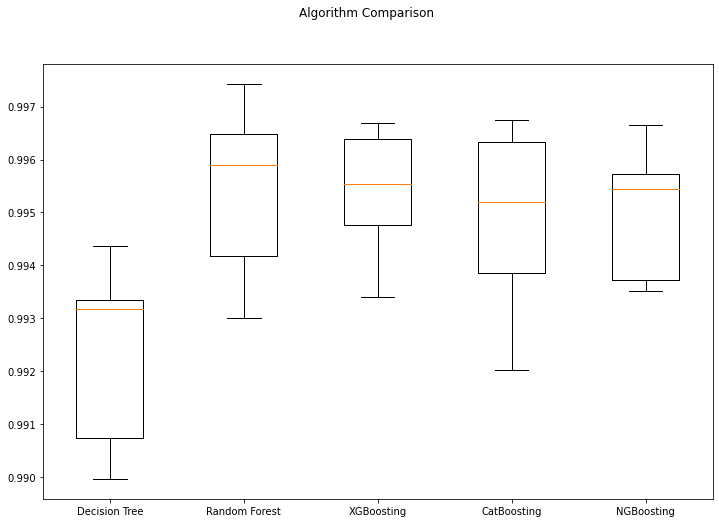

In [194]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 2년

# Prepare Data for Analysis

In [42]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df2 = df['2020-01-01':]
df2.reset_index(inplace=True)

In [43]:
training_size = int(len(df2)*0.70)

df2_train = df2.loc[:training_size, :]
df2_test = df2.loc[training_size:, :]

In [44]:
df2_train.drop(['Date'], axis=1, inplace=True)
df2_test.drop(['Date'], axis=1, inplace=True)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
scaler = RobustScaler()
scaler.fit(df2_train)

df2_train[df2_train.columns] = scaler.transform(df2_train[df2_train.columns]) 
df2_test[df2_test.columns] = scaler.transform(df2_test[df2_test.columns]) 
# df2 = pd.DataFrame(scale.fit_transform(df2.values), columns=df2.columns, index=df2.index)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
# feature_columns = list(df2.columns.difference(['Close']))
feature_columns = list(df2_train.columns.difference(['Close']))

In [47]:
y_train = df2_train['Close']
X_train = df2_train.drop(['Close'], axis=1)

y_test = df2_test['Close']
X_test = df2_test.drop(['Close'], axis=1)

## Decision Tree

In [48]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [49]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)), "\nTrain R2: ", r2_score(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred), "\nTest R2: ", r2_score(y_test, dt_pred))

Train MSE:  0.004170436503504994 
Train R2:  0.990404028706201

Test MSE:  0.037632090944586506 
Test R2:  0.5568980441899636


In [50]:
dt.feature_importances_

array([0.00000000e+00, 1.30357632e-03, 0.00000000e+00, 0.00000000e+00,
       7.53216348e-03, 2.09667707e-03, 0.00000000e+00, 1.20033170e-02,
       0.00000000e+00, 1.02277812e-03, 1.12788856e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.71708595e-04, 0.00000000e+00,
       0.00000000e+00, 1.10117771e-01, 8.64624120e-01])

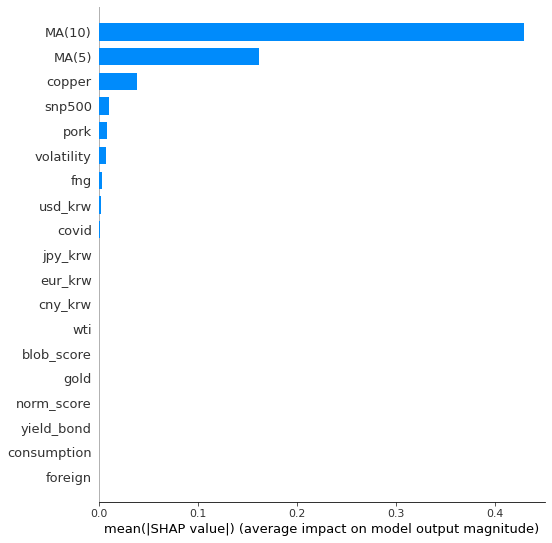

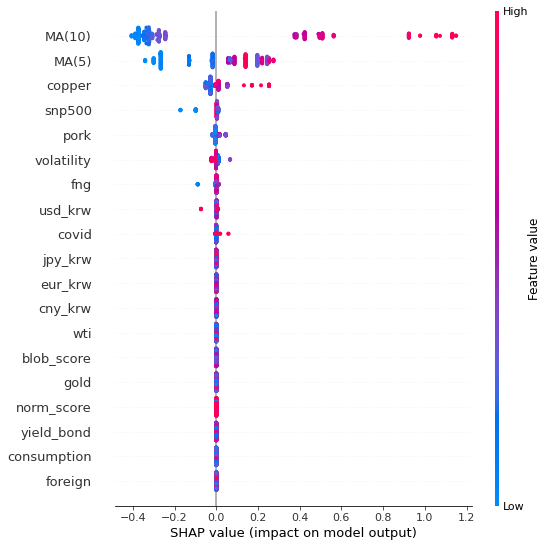

In [51]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Ensemble Methods

### Random Forest

In [52]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

In [53]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)), "\nTrain R2: ", r2_score(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred), "\nTest R2: ", r2_score(y_test, rf_pred))

Train MSE:  0.000581299207235842 
Train R2:  0.9986624588334926

Test MSE:  0.021115026032903387 
Test R2:  0.7513794982602413


In [54]:
rf.feature_importances_

array([4.57548961e-04, 9.83349956e-04, 7.60815143e-04, 5.37711913e-04,
       9.40071332e-02, 1.77770451e-03, 1.07262792e-03, 2.12441277e-01,
       2.98965061e-04, 2.90904496e-02, 1.14845677e-03, 7.29942363e-04,
       7.73193872e-04, 2.58022589e-03, 5.71608647e-04, 7.43640516e-04,
       2.24015522e-04, 4.07949377e-01, 2.43851955e-01])

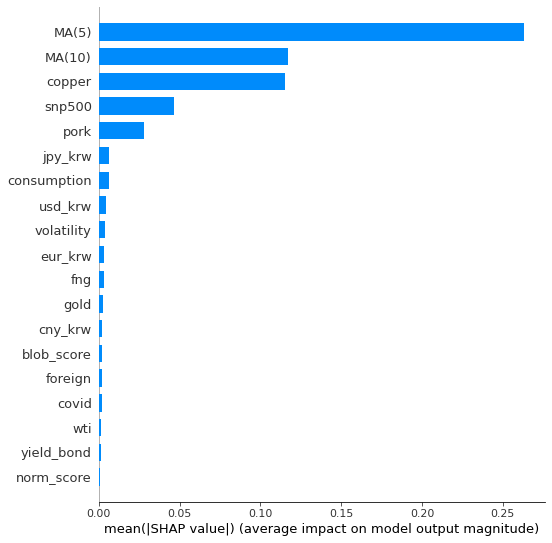

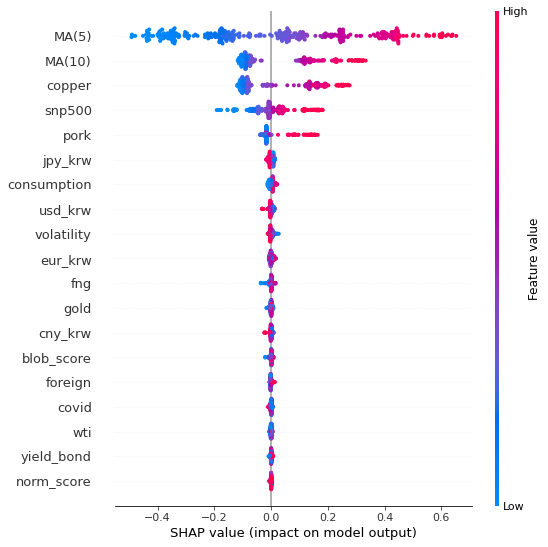

In [55]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### adaBoosting

In [56]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [57]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ada.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, ada_pred), "\nTest R2: ", r2_score(y_test, ada_pred))

Train MSE:  0.0033457762963912635 
Train R2:  0.9923015316817171
Test MSE:  0.016092447530500365 
Test R2:  0.8105182360173675


In [58]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

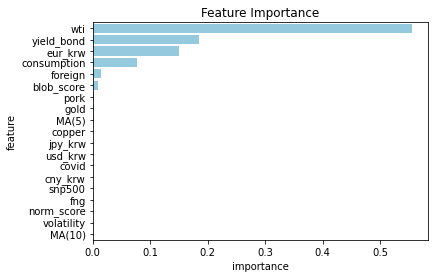

In [59]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

### XGBoosting

In [60]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [61]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred), "\nTest R2: ", r2_score(y_test, xgb_pred))

Train MSE:  6.683569370604324e-07 
Train R2:  0.9999984621432368

Test MSE:  0.023459403835924736 
Test R2:  0.7237754410951469


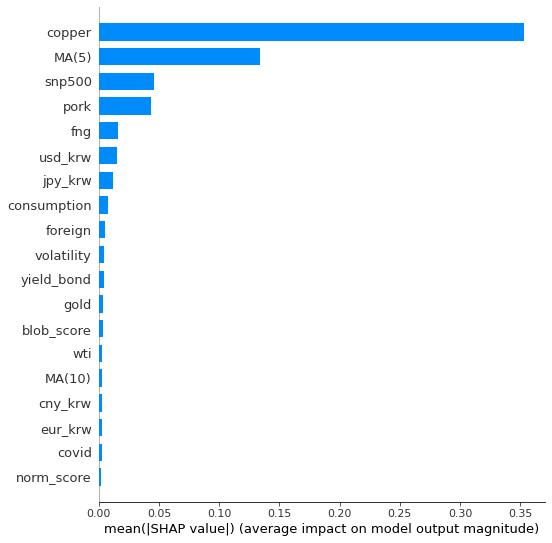

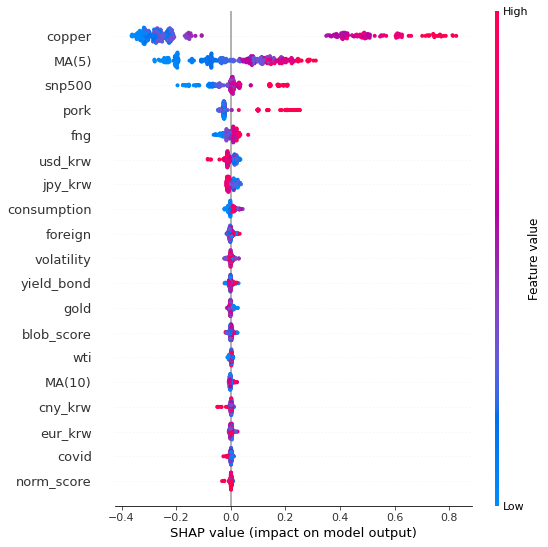

In [62]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### CatBoosting

In [63]:
cat = CatBoostRegressor(iterations=100, verbose=10)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_pred = cat.predict(X_train)

Learning rate set to 0.175682
0:	learn: 0.5640874	test: 0.8191490	best: 0.8191490 (0)	total: 2.17ms	remaining: 214ms
10:	learn: 0.1506822	test: 0.3183146	best: 0.3183146 (10)	total: 25.9ms	remaining: 209ms
20:	learn: 0.0792008	test: 0.2415818	best: 0.2415818 (20)	total: 48ms	remaining: 181ms
30:	learn: 0.0607792	test: 0.2425078	best: 0.2331646 (22)	total: 69.3ms	remaining: 154ms
40:	learn: 0.0516265	test: 0.2425379	best: 0.2331646 (22)	total: 89.6ms	remaining: 129ms
50:	learn: 0.0444334	test: 0.2458081	best: 0.2331646 (22)	total: 110ms	remaining: 106ms
60:	learn: 0.0385984	test: 0.2448187	best: 0.2331646 (22)	total: 133ms	remaining: 84.9ms
70:	learn: 0.0330241	test: 0.2444271	best: 0.2331646 (22)	total: 155ms	remaining: 63.3ms
80:	learn: 0.0302349	test: 0.2435222	best: 0.2331646 (22)	total: 178ms	remaining: 41.7ms
90:	learn: 0.0270247	test: 0.2426969	best: 0.2331646 (22)	total: 199ms	remaining: 19.7ms
99:	learn: 0.0239509	test: 0.2432173	best: 0.2331646 (22)	total: 219ms	remaining: 0us

In [64]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.2916319021540813 
Train R2:  0.3289691956526354

Test MSE:  0.6871310944072262 
Test R2:  -7.090678040666555


#### GridSearch

In [65]:
cat = CatBoostRegressor()

params = {
            'iterations':[100,500],
            'learning_rate':[0.01, 0.1],
            'verbose':[0.1,10],
            'bootstrap_type':['Bayesian', 'No']
}

search_results = cat.grid_search(params, X_train, y_train, cv=5)

print("\nBest Params : ", search_results['params'])

0:	learn: 0.6536433	test: 0.7716834	best: 0.7716834 (0)	total: 32.6ms	remaining: 3.23s
10:	learn: 0.6034802	test: 0.7159183	best: 0.7159183 (10)	total: 51.4ms	remaining: 416ms
20:	learn: 0.5586203	test: 0.6659786	best: 0.6659786 (20)	total: 71ms	remaining: 267ms
30:	learn: 0.5164615	test: 0.6185386	best: 0.6185386 (30)	total: 90.7ms	remaining: 202ms
40:	learn: 0.4780391	test: 0.5751292	best: 0.5751292 (40)	total: 113ms	remaining: 163ms
50:	learn: 0.4431160	test: 0.5362585	best: 0.5362585 (50)	total: 133ms	remaining: 127ms
60:	learn: 0.4112317	test: 0.5004359	best: 0.5004359 (60)	total: 153ms	remaining: 97.9ms
70:	learn: 0.3816786	test: 0.4669355	best: 0.4669355 (70)	total: 173ms	remaining: 70.7ms
80:	learn: 0.3537196	test: 0.4354215	best: 0.4354215 (80)	total: 193ms	remaining: 45.3ms
90:	learn: 0.3285381	test: 0.4067704	best: 0.4067704 (90)	total: 215ms	remaining: 21.2ms
99:	learn: 0.3073454	test: 0.3833910	best: 0.3833910 (99)	total: 234ms	remaining: 0us

bestTest = 0.3833910376
bestI

440:	learn: 0.0688686	test: 0.1082786	best: 0.1082786 (440)	total: 1.02s	remaining: 136ms
450:	learn: 0.0676332	test: 0.1068357	best: 0.1068357 (450)	total: 1.04s	remaining: 113ms
460:	learn: 0.0665147	test: 0.1054329	best: 0.1054329 (460)	total: 1.06s	remaining: 89.9ms
470:	learn: 0.0654634	test: 0.1041476	best: 0.1041476 (470)	total: 1.08s	remaining: 66.8ms
480:	learn: 0.0643660	test: 0.1026452	best: 0.1026452 (480)	total: 1.11s	remaining: 44.1ms
490:	learn: 0.0635521	test: 0.1018175	best: 0.1018175 (490)	total: 1.14s	remaining: 20.9ms
499:	learn: 0.0626925	test: 0.1009878	best: 0.1009878 (499)	total: 1.16s	remaining: 0us

bestTest = 0.1009877686
bestIteration = 499

4:	loss: 0.1009878	best: 0.0868948 (3)	total: 2.14s	remaining: 4.7s
0:	learn: 0.6532700	test: 0.7709741	best: 0.7709741 (0)	total: 2.63ms	remaining: 1.31s
10:	learn: 0.6025265	test: 0.7145377	best: 0.7145377 (10)	total: 23.8ms	remaining: 1.06s
20:	learn: 0.5577359	test: 0.6644870	best: 0.6644870 (20)	total: 46.3ms	remain

310:	learn: 0.0092876	test: 0.0882313	best: 0.0881836 (305)	total: 792ms	remaining: 481ms
320:	learn: 0.0088344	test: 0.0881805	best: 0.0881370 (318)	total: 812ms	remaining: 453ms
330:	learn: 0.0083064	test: 0.0882603	best: 0.0881370 (318)	total: 832ms	remaining: 425ms
340:	learn: 0.0079100	test: 0.0881302	best: 0.0881302 (340)	total: 852ms	remaining: 397ms
350:	learn: 0.0074988	test: 0.0881852	best: 0.0881185 (341)	total: 872ms	remaining: 370ms
360:	learn: 0.0071161	test: 0.0881777	best: 0.0881185 (341)	total: 896ms	remaining: 345ms
370:	learn: 0.0067531	test: 0.0882252	best: 0.0881185 (341)	total: 916ms	remaining: 318ms
380:	learn: 0.0064183	test: 0.0881980	best: 0.0881185 (341)	total: 937ms	remaining: 293ms
390:	learn: 0.0060517	test: 0.0881742	best: 0.0881185 (341)	total: 958ms	remaining: 267ms
400:	learn: 0.0057490	test: 0.0880910	best: 0.0880910 (400)	total: 981ms	remaining: 242ms
410:	learn: 0.0054685	test: 0.0881233	best: 0.0880899 (401)	total: 1s	remaining: 217ms
420:	learn: 0

180:	learn: 0.0194757	test: 0.0745859	best: 0.0740840 (104)	total: 355ms	remaining: 627ms
190:	learn: 0.0181982	test: 0.0744582	best: 0.0740840 (104)	total: 375ms	remaining: 607ms
200:	learn: 0.0168544	test: 0.0743897	best: 0.0740840 (104)	total: 394ms	remaining: 587ms
210:	learn: 0.0161145	test: 0.0746453	best: 0.0740840 (104)	total: 413ms	remaining: 566ms
220:	learn: 0.0153107	test: 0.0746135	best: 0.0740840 (104)	total: 435ms	remaining: 549ms
230:	learn: 0.0143877	test: 0.0747082	best: 0.0740840 (104)	total: 456ms	remaining: 531ms
240:	learn: 0.0135936	test: 0.0747376	best: 0.0740840 (104)	total: 475ms	remaining: 511ms
250:	learn: 0.0128135	test: 0.0747666	best: 0.0740840 (104)	total: 494ms	remaining: 490ms
260:	learn: 0.0121369	test: 0.0746731	best: 0.0740840 (104)	total: 513ms	remaining: 469ms
270:	learn: 0.0117233	test: 0.0747711	best: 0.0740840 (104)	total: 536ms	remaining: 453ms
280:	learn: 0.0110513	test: 0.0748096	best: 0.0740840 (104)	total: 555ms	remaining: 432ms
290:	learn

60:	learn: 0.0538503	test: 0.0693844	best: 0.0693844 (60)	total: 141ms	remaining: 1.01s
70:	learn: 0.0481364	test: 0.0674206	best: 0.0674206 (70)	total: 165ms	remaining: 996ms
80:	learn: 0.0433642	test: 0.0658843	best: 0.0658843 (80)	total: 186ms	remaining: 963ms
90:	learn: 0.0402985	test: 0.0639013	best: 0.0639013 (90)	total: 207ms	remaining: 932ms
100:	learn: 0.0373466	test: 0.0630451	best: 0.0630451 (100)	total: 228ms	remaining: 899ms
110:	learn: 0.0344705	test: 0.0625518	best: 0.0625518 (110)	total: 247ms	remaining: 867ms
120:	learn: 0.0321055	test: 0.0618765	best: 0.0618718 (118)	total: 269ms	remaining: 843ms
130:	learn: 0.0295384	test: 0.0613996	best: 0.0613996 (130)	total: 292ms	remaining: 821ms
140:	learn: 0.0277570	test: 0.0611173	best: 0.0611173 (140)	total: 320ms	remaining: 815ms
150:	learn: 0.0258542	test: 0.0603465	best: 0.0603465 (150)	total: 347ms	remaining: 802ms
160:	learn: 0.0236702	test: 0.0601884	best: 0.0601241 (159)	total: 368ms	remaining: 774ms
170:	learn: 0.0222

499:	learn: 0.0028837	test: 0.0728053	best: 0.0727972 (466)	total: 1.08s	remaining: 0us

bestTest = 0.07279715785
bestIteration = 466

Training on fold [4/5]
0:	learn: 0.6120360	test: 0.6964316	best: 0.6964316 (0)	total: 18ms	remaining: 8.99s
10:	learn: 0.2774109	test: 0.3323572	best: 0.3323572 (10)	total: 33.8ms	remaining: 1.5s
20:	learn: 0.1412957	test: 0.1809508	best: 0.1809508 (20)	total: 51.2ms	remaining: 1.17s
30:	learn: 0.0918006	test: 0.1259681	best: 0.1259681 (30)	total: 70ms	remaining: 1.06s
40:	learn: 0.0696881	test: 0.0975122	best: 0.0975122 (40)	total: 95.3ms	remaining: 1.07s
50:	learn: 0.0587868	test: 0.0867046	best: 0.0867046 (50)	total: 114ms	remaining: 1s
60:	learn: 0.0524974	test: 0.0796404	best: 0.0796404 (60)	total: 135ms	remaining: 970ms
70:	learn: 0.0472039	test: 0.0758986	best: 0.0758986 (70)	total: 154ms	remaining: 931ms
80:	learn: 0.0426607	test: 0.0731888	best: 0.0731888 (80)	total: 174ms	remaining: 898ms
90:	learn: 0.0388236	test: 0.0716970	best: 0.0716970 (9

In [66]:
cat = CatBoostRegressor(iterations=500, verbose=10, learning_rate= 0.1, bootstrap_type= 'Bayesian')

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_preds = cat.predict(X_train)

0:	learn: 0.6048984	test: 0.8907622	best: 0.8907622 (0)	total: 2.95ms	remaining: 1.47s
10:	learn: 0.2681430	test: 0.4558993	best: 0.4558993 (10)	total: 29.6ms	remaining: 1.32s
20:	learn: 0.1391703	test: 0.2816382	best: 0.2816382 (20)	total: 55.1ms	remaining: 1.26s
30:	learn: 0.0933150	test: 0.2218491	best: 0.2218491 (30)	total: 81.1ms	remaining: 1.23s
40:	learn: 0.0744903	test: 0.2132814	best: 0.2132814 (40)	total: 108ms	remaining: 1.21s
50:	learn: 0.0649659	test: 0.2081752	best: 0.2076319 (48)	total: 136ms	remaining: 1.2s
60:	learn: 0.0587580	test: 0.2044598	best: 0.2044598 (60)	total: 163ms	remaining: 1.17s
70:	learn: 0.0529283	test: 0.2002122	best: 0.1987039 (69)	total: 190ms	remaining: 1.15s
80:	learn: 0.0484333	test: 0.2007103	best: 0.1987039 (69)	total: 223ms	remaining: 1.16s
90:	learn: 0.0446603	test: 0.2007376	best: 0.1987039 (69)	total: 252ms	remaining: 1.13s
100:	learn: 0.0409131	test: 0.2016773	best: 0.1987039 (69)	total: 277ms	remaining: 1.09s
110:	learn: 0.0380876	test: 0.

In [67]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.33156000080637305 
Train R2:  0.2370965851569825

Test MSE:  0.7100861971431057 
Test R2:  -7.3609646673933575


In [68]:
cat.feature_importances_

array([ 0.99495324,  3.35211128,  6.05821829,  1.22299045,  8.71016988,
        5.00581885,  1.28372965, 14.18383594,  6.12283223,  6.06121844,
        6.92913125,  2.7698679 ,  1.36546536,  3.18452943,  1.72364324,
        1.19141739,  0.3072244 , 16.78389608, 12.7489467 ])

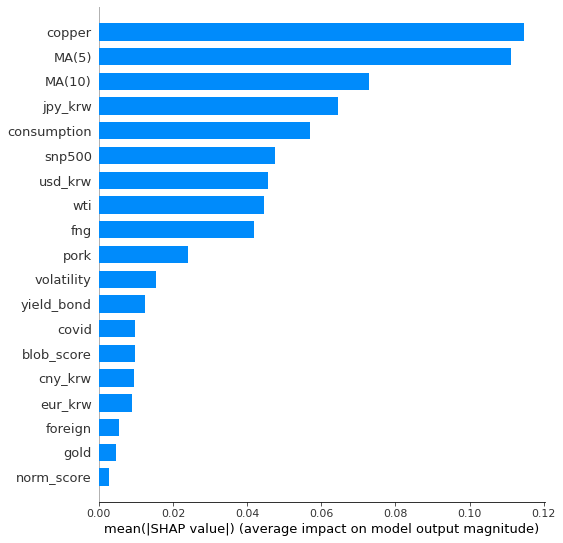

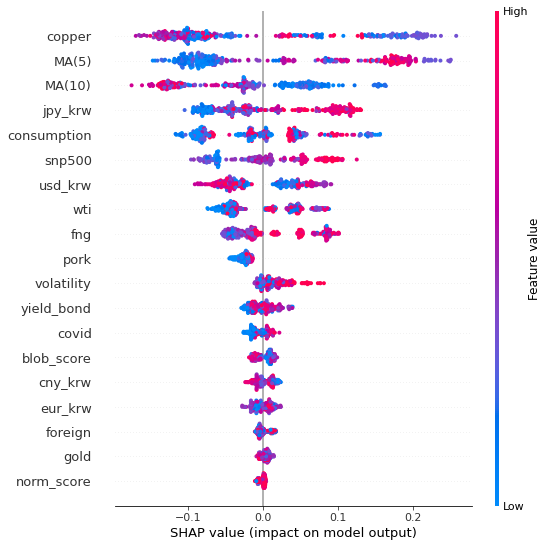

In [69]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### NGBoosting

In [70]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=1.0023 val_loss=0.0000 scale=1.0000 norm=0.7515
[iter 100] loss=-0.1668 val_loss=0.0000 scale=2.0000 norm=0.9491
[iter 200] loss=-1.0951 val_loss=0.0000 scale=2.0000 norm=0.9182
[iter 300] loss=-1.8387 val_loss=0.0000 scale=2.0000 norm=0.7626
[iter 400] loss=-2.2387 val_loss=0.0000 scale=2.0000 norm=0.6976


In [71]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred), "\nTest R2: ", r2_score(y_test, ngb_pred))

Train MSE:  0.0006051384783476595 
Train R2:  0.9986076058316397

Test MSE:  0.01770776851896562 
Test R2:  0.7914985145168029


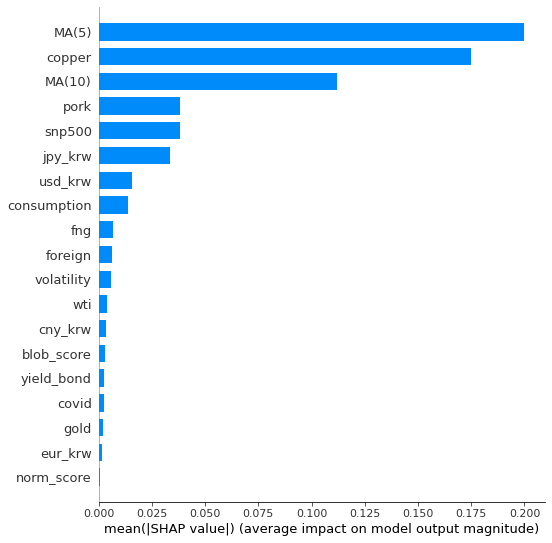

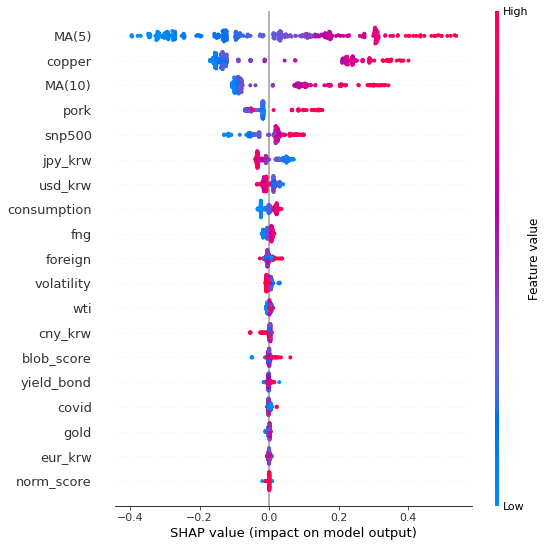

In [72]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Summary

### Prediction + Graph

In [73]:
final_pred = pd.DataFrame({
    # 'svr':svrdf,
    'dt': dt_pred,
    'rf': rf_pred,
    # 'ada': ada_pred,
    'xgb': xgb_pred,
    'cat': cat_pred,
    'ngb': ngb_pred,
    'true': y_test
    # 'lstm': lstm_pred
})

pd.options.display.float_format = '{:.4f}'.format
final_pred.head()

,dt,rf,xgb,cat,ngb,true
346,1.4535,1.4101,1.3987,0.3293,1.4024,1.3985
347,1.7126,1.4852,1.5377,0.3102,1.4673,1.4459
348,1.4535,1.4409,1.4243,0.3400,1.4750,1.4519
349,1.4535,1.4505,1.4322,0.3120,1.5032,1.4815
350,1.4535,1.4822,1.5007,0.3163,1.5539,1.4874


In [74]:
final_pred.tail()

,dt,rf,xgb,cat,ngb,true
490,1.0923,1.0359,1.0143,0.1266,0.9067,0.8119
491,1.0923,1.0197,0.9964,0.2354,0.9047,0.7733
492,1.0923,1.0175,0.9982,0.1583,0.8997,0.7763
493,0.7250,0.9607,0.8847,0.2706,0.8611,0.7289
494,0.7250,0.9743,0.8911,0.2118,0.8513,0.7170


In [75]:
model_names = [dt, rf, xgb, cat, ngb]

r2_train = []
r2_test = []
MSE_train = []
MSE_test = []
for model in model_names:
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_test.append(r2_score(y_test, model.predict(X_test)))
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [76]:
evaluation = pd.DataFrame([MSE_train, MSE_test, r2_train, r2_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'XGBoosting', 'CatBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test', 'R2_train', 'R2_test']))

evaluation

,Decision Tree,Random Forest,XGBoosting,CatBoosting,NGBoosting
MSE_train,0.0042,0.0006,0.0000,0.3316,0.0006
MSE_test,0.0376,0.0211,0.0235,0.7101,0.0177
R2_train,0.9904,0.9987,1.0000,0.2371,0.9986
R2_test,0.5569,0.7514,0.7238,-7.3610,0.7915


In [77]:
names = cycle(['dt',	'rf',	'xgb',	'cat',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['xgb'][:], final_pred['cat'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [78]:
from sklearn import model_selection
from keras.wrappers.scikit_learn import KerasClassifier

models = []
# models.append(('SVM', SVR()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
# models.append(('adaBoosting', AdaBoostRegressor()))
models.append(('XGBoosting', XGBRegressor()))
models.append(('CatBoosting', CatBoostRegressor()))
models.append(('NGBoosting', NGBRegressor()))
# models.append(('LSTM', lstm))
# models.append(('GRU', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
seed=42

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	if name != 'LSTM':
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	else :
		lstm = Sequential()
		lstm.add(Dense(50, input_dim=18, activation='relu'))
		lstm.add(Dense(50, activation='relu'))
		lstm.add(Dense(1)) 
		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	# print(msg)

print(results) 

Learning rate set to 0.034061
0:	learn: 0.6474041	total: 2.65ms	remaining: 2.65s
1:	learn: 0.6291233	total: 4.84ms	remaining: 2.42s
2:	learn: 0.6127566	total: 7.06ms	remaining: 2.35s
3:	learn: 0.5951792	total: 9.22ms	remaining: 2.29s
4:	learn: 0.5796639	total: 11.4ms	remaining: 2.27s
5:	learn: 0.5634122	total: 13.6ms	remaining: 2.25s
6:	learn: 0.5483838	total: 15.9ms	remaining: 2.25s
7:	learn: 0.5349470	total: 18.3ms	remaining: 2.27s
8:	learn: 0.5200449	total: 20.6ms	remaining: 2.27s
9:	learn: 0.5045402	total: 23ms	remaining: 2.27s
10:	learn: 0.4919315	total: 25.2ms	remaining: 2.27s
11:	learn: 0.4783234	total: 27.5ms	remaining: 2.26s
12:	learn: 0.4648193	total: 29.8ms	remaining: 2.26s
13:	learn: 0.4519001	total: 32.1ms	remaining: 2.26s
14:	learn: 0.4397250	total: 34.3ms	remaining: 2.25s
15:	learn: 0.4278959	total: 36.6ms	remaining: 2.25s
16:	learn: 0.4165766	total: 39ms	remaining: 2.25s
17:	learn: 0.4056508	total: 41.4ms	remaining: 2.26s
18:	learn: 0.3951876	total: 43.6ms	remaining: 2.

167:	learn: 0.0547411	total: 356ms	remaining: 1.76s
168:	learn: 0.0545675	total: 358ms	remaining: 1.76s
169:	learn: 0.0543383	total: 360ms	remaining: 1.76s
170:	learn: 0.0540893	total: 362ms	remaining: 1.76s
171:	learn: 0.0538179	total: 365ms	remaining: 1.76s
172:	learn: 0.0536669	total: 367ms	remaining: 1.75s
173:	learn: 0.0534330	total: 369ms	remaining: 1.75s
174:	learn: 0.0533150	total: 372ms	remaining: 1.75s
175:	learn: 0.0531071	total: 374ms	remaining: 1.75s
176:	learn: 0.0529394	total: 377ms	remaining: 1.75s
177:	learn: 0.0527033	total: 379ms	remaining: 1.75s
178:	learn: 0.0524564	total: 382ms	remaining: 1.75s
179:	learn: 0.0522728	total: 384ms	remaining: 1.75s
180:	learn: 0.0521337	total: 386ms	remaining: 1.75s
181:	learn: 0.0519403	total: 388ms	remaining: 1.75s
182:	learn: 0.0518231	total: 390ms	remaining: 1.74s
183:	learn: 0.0516852	total: 393ms	remaining: 1.74s
184:	learn: 0.0515579	total: 395ms	remaining: 1.74s
185:	learn: 0.0513032	total: 398ms	remaining: 1.74s
186:	learn: 

340:	learn: 0.0311864	total: 714ms	remaining: 1.38s
341:	learn: 0.0311474	total: 716ms	remaining: 1.38s
342:	learn: 0.0310257	total: 718ms	remaining: 1.38s
343:	learn: 0.0309609	total: 720ms	remaining: 1.37s
344:	learn: 0.0308684	total: 723ms	remaining: 1.37s
345:	learn: 0.0307774	total: 725ms	remaining: 1.37s
346:	learn: 0.0306915	total: 728ms	remaining: 1.37s
347:	learn: 0.0305883	total: 730ms	remaining: 1.37s
348:	learn: 0.0305059	total: 732ms	remaining: 1.36s
349:	learn: 0.0304088	total: 734ms	remaining: 1.36s
350:	learn: 0.0303476	total: 736ms	remaining: 1.36s
351:	learn: 0.0302889	total: 738ms	remaining: 1.36s
352:	learn: 0.0302581	total: 740ms	remaining: 1.36s
353:	learn: 0.0301531	total: 743ms	remaining: 1.35s
354:	learn: 0.0301271	total: 745ms	remaining: 1.35s
355:	learn: 0.0300367	total: 747ms	remaining: 1.35s
356:	learn: 0.0299670	total: 749ms	remaining: 1.35s
357:	learn: 0.0298816	total: 751ms	remaining: 1.34s
358:	learn: 0.0298283	total: 753ms	remaining: 1.34s
359:	learn: 

505:	learn: 0.0207398	total: 1.07s	remaining: 1.05s
506:	learn: 0.0206914	total: 1.07s	remaining: 1.05s
507:	learn: 0.0206736	total: 1.08s	remaining: 1.04s
508:	learn: 0.0206234	total: 1.08s	remaining: 1.04s
509:	learn: 0.0206005	total: 1.08s	remaining: 1.04s
510:	learn: 0.0205334	total: 1.09s	remaining: 1.04s
511:	learn: 0.0204942	total: 1.09s	remaining: 1.04s
512:	learn: 0.0204267	total: 1.09s	remaining: 1.04s
513:	learn: 0.0203919	total: 1.09s	remaining: 1.03s
514:	learn: 0.0203342	total: 1.1s	remaining: 1.03s
515:	learn: 0.0202930	total: 1.1s	remaining: 1.03s
516:	learn: 0.0202490	total: 1.1s	remaining: 1.03s
517:	learn: 0.0201913	total: 1.1s	remaining: 1.03s
518:	learn: 0.0201402	total: 1.11s	remaining: 1.02s
519:	learn: 0.0201159	total: 1.11s	remaining: 1.02s
520:	learn: 0.0200488	total: 1.11s	remaining: 1.02s
521:	learn: 0.0200202	total: 1.11s	remaining: 1.02s
522:	learn: 0.0199898	total: 1.12s	remaining: 1.02s
523:	learn: 0.0199630	total: 1.12s	remaining: 1.01s
524:	learn: 0.01

721:	learn: 0.0132938	total: 1.61s	remaining: 620ms
722:	learn: 0.0132681	total: 1.61s	remaining: 618ms
723:	learn: 0.0132559	total: 1.62s	remaining: 616ms
724:	learn: 0.0132330	total: 1.62s	remaining: 615ms
725:	learn: 0.0132045	total: 1.62s	remaining: 613ms
726:	learn: 0.0131850	total: 1.63s	remaining: 612ms
727:	learn: 0.0131732	total: 1.63s	remaining: 610ms
728:	learn: 0.0131530	total: 1.63s	remaining: 608ms
729:	learn: 0.0131133	total: 1.64s	remaining: 606ms
730:	learn: 0.0130823	total: 1.64s	remaining: 604ms
731:	learn: 0.0130721	total: 1.64s	remaining: 602ms
732:	learn: 0.0130548	total: 1.65s	remaining: 600ms
733:	learn: 0.0130427	total: 1.65s	remaining: 598ms
734:	learn: 0.0130090	total: 1.65s	remaining: 596ms
735:	learn: 0.0129724	total: 1.66s	remaining: 594ms
736:	learn: 0.0129412	total: 1.66s	remaining: 592ms
737:	learn: 0.0129080	total: 1.66s	remaining: 589ms
738:	learn: 0.0129011	total: 1.66s	remaining: 587ms
739:	learn: 0.0128801	total: 1.66s	remaining: 585ms
740:	learn: 

939:	learn: 0.0088973	total: 2.14s	remaining: 137ms
940:	learn: 0.0088749	total: 2.15s	remaining: 135ms
941:	learn: 0.0088732	total: 2.15s	remaining: 132ms
942:	learn: 0.0088584	total: 2.15s	remaining: 130ms
943:	learn: 0.0088520	total: 2.15s	remaining: 128ms
944:	learn: 0.0088276	total: 2.15s	remaining: 125ms
945:	learn: 0.0088138	total: 2.16s	remaining: 123ms
946:	learn: 0.0088047	total: 2.16s	remaining: 121ms
947:	learn: 0.0087858	total: 2.16s	remaining: 119ms
948:	learn: 0.0087660	total: 2.16s	remaining: 116ms
949:	learn: 0.0087408	total: 2.17s	remaining: 114ms
950:	learn: 0.0087305	total: 2.17s	remaining: 112ms
951:	learn: 0.0087120	total: 2.17s	remaining: 109ms
952:	learn: 0.0086916	total: 2.17s	remaining: 107ms
953:	learn: 0.0086739	total: 2.17s	remaining: 105ms
954:	learn: 0.0086606	total: 2.17s	remaining: 102ms
955:	learn: 0.0086427	total: 2.18s	remaining: 100ms
956:	learn: 0.0086342	total: 2.18s	remaining: 97.9ms
957:	learn: 0.0086122	total: 2.18s	remaining: 95.6ms
958:	learn

175:	learn: 0.0524721	total: 397ms	remaining: 1.86s
176:	learn: 0.0522569	total: 399ms	remaining: 1.86s
177:	learn: 0.0521116	total: 402ms	remaining: 1.85s
178:	learn: 0.0519441	total: 404ms	remaining: 1.85s
179:	learn: 0.0518688	total: 406ms	remaining: 1.85s
180:	learn: 0.0516765	total: 408ms	remaining: 1.85s
181:	learn: 0.0514558	total: 411ms	remaining: 1.84s
182:	learn: 0.0512902	total: 413ms	remaining: 1.84s
183:	learn: 0.0510640	total: 415ms	remaining: 1.84s
184:	learn: 0.0508607	total: 418ms	remaining: 1.84s
185:	learn: 0.0506949	total: 420ms	remaining: 1.84s
186:	learn: 0.0505243	total: 422ms	remaining: 1.83s
187:	learn: 0.0503304	total: 424ms	remaining: 1.83s
188:	learn: 0.0501623	total: 425ms	remaining: 1.82s
189:	learn: 0.0499454	total: 428ms	remaining: 1.82s
190:	learn: 0.0498365	total: 430ms	remaining: 1.82s
191:	learn: 0.0497269	total: 432ms	remaining: 1.82s
192:	learn: 0.0496304	total: 434ms	remaining: 1.81s
193:	learn: 0.0493773	total: 436ms	remaining: 1.81s
194:	learn: 

405:	learn: 0.0260485	total: 932ms	remaining: 1.36s
406:	learn: 0.0259601	total: 935ms	remaining: 1.36s
407:	learn: 0.0259021	total: 938ms	remaining: 1.36s
408:	learn: 0.0258232	total: 940ms	remaining: 1.36s
409:	learn: 0.0257695	total: 943ms	remaining: 1.36s
410:	learn: 0.0256987	total: 946ms	remaining: 1.35s
411:	learn: 0.0256340	total: 948ms	remaining: 1.35s
412:	learn: 0.0255584	total: 951ms	remaining: 1.35s
413:	learn: 0.0255070	total: 953ms	remaining: 1.35s
414:	learn: 0.0254425	total: 956ms	remaining: 1.35s
415:	learn: 0.0253932	total: 958ms	remaining: 1.34s
416:	learn: 0.0253722	total: 960ms	remaining: 1.34s
417:	learn: 0.0253303	total: 962ms	remaining: 1.34s
418:	learn: 0.0252791	total: 964ms	remaining: 1.34s
419:	learn: 0.0252017	total: 966ms	remaining: 1.33s
420:	learn: 0.0251695	total: 968ms	remaining: 1.33s
421:	learn: 0.0251032	total: 970ms	remaining: 1.33s
422:	learn: 0.0250264	total: 972ms	remaining: 1.32s
423:	learn: 0.0249579	total: 974ms	remaining: 1.32s
424:	learn: 

640:	learn: 0.0156302	total: 1.47s	remaining: 821ms
641:	learn: 0.0156126	total: 1.47s	remaining: 819ms
642:	learn: 0.0155796	total: 1.47s	remaining: 817ms
643:	learn: 0.0155712	total: 1.47s	remaining: 815ms
644:	learn: 0.0155526	total: 1.48s	remaining: 813ms
645:	learn: 0.0155105	total: 1.48s	remaining: 810ms
646:	learn: 0.0154753	total: 1.48s	remaining: 808ms
647:	learn: 0.0154265	total: 1.48s	remaining: 806ms
648:	learn: 0.0153884	total: 1.49s	remaining: 804ms
649:	learn: 0.0153556	total: 1.49s	remaining: 801ms
650:	learn: 0.0153460	total: 1.49s	remaining: 799ms
651:	learn: 0.0153014	total: 1.49s	remaining: 797ms
652:	learn: 0.0152591	total: 1.49s	remaining: 794ms
653:	learn: 0.0152167	total: 1.5s	remaining: 792ms
654:	learn: 0.0151736	total: 1.5s	remaining: 789ms
655:	learn: 0.0151229	total: 1.5s	remaining: 787ms
656:	learn: 0.0150862	total: 1.5s	remaining: 785ms
657:	learn: 0.0150726	total: 1.5s	remaining: 782ms
658:	learn: 0.0150368	total: 1.51s	remaining: 780ms
659:	learn: 0.015

806:	learn: 0.0114133	total: 1.82s	remaining: 437ms
807:	learn: 0.0114074	total: 1.83s	remaining: 434ms
808:	learn: 0.0113880	total: 1.83s	remaining: 432ms
809:	learn: 0.0113735	total: 1.83s	remaining: 430ms
810:	learn: 0.0113398	total: 1.83s	remaining: 428ms
811:	learn: 0.0113133	total: 1.84s	remaining: 426ms
812:	learn: 0.0112932	total: 1.84s	remaining: 423ms
813:	learn: 0.0112719	total: 1.84s	remaining: 421ms
814:	learn: 0.0112484	total: 1.84s	remaining: 419ms
815:	learn: 0.0112210	total: 1.85s	remaining: 417ms
816:	learn: 0.0111961	total: 1.85s	remaining: 415ms
817:	learn: 0.0111901	total: 1.85s	remaining: 412ms
818:	learn: 0.0111804	total: 1.85s	remaining: 410ms
819:	learn: 0.0111512	total: 1.86s	remaining: 408ms
820:	learn: 0.0111484	total: 1.86s	remaining: 406ms
821:	learn: 0.0111416	total: 1.86s	remaining: 403ms
822:	learn: 0.0111232	total: 1.86s	remaining: 401ms
823:	learn: 0.0111028	total: 1.87s	remaining: 399ms
824:	learn: 0.0110875	total: 1.87s	remaining: 397ms
825:	learn: 

3:	learn: 0.5913049	total: 8.34ms	remaining: 2.08s
4:	learn: 0.5757128	total: 10.5ms	remaining: 2.09s
5:	learn: 0.5593488	total: 12.5ms	remaining: 2.07s
6:	learn: 0.5438183	total: 14.6ms	remaining: 2.08s
7:	learn: 0.5291300	total: 17.2ms	remaining: 2.13s
8:	learn: 0.5151539	total: 19.5ms	remaining: 2.15s
9:	learn: 0.5004961	total: 21.8ms	remaining: 2.16s
10:	learn: 0.4879805	total: 24.4ms	remaining: 2.19s
11:	learn: 0.4743182	total: 26.7ms	remaining: 2.2s
12:	learn: 0.4613211	total: 29ms	remaining: 2.2s
13:	learn: 0.4484361	total: 31.4ms	remaining: 2.21s
14:	learn: 0.4367729	total: 33.6ms	remaining: 2.21s
15:	learn: 0.4249831	total: 35.8ms	remaining: 2.2s
16:	learn: 0.4139221	total: 38.1ms	remaining: 2.2s
17:	learn: 0.4041806	total: 40.3ms	remaining: 2.2s
18:	learn: 0.3936606	total: 42.7ms	remaining: 2.2s
19:	learn: 0.3831558	total: 44.9ms	remaining: 2.2s
20:	learn: 0.3735140	total: 47.2ms	remaining: 2.2s
21:	learn: 0.3634089	total: 49.7ms	remaining: 2.21s
22:	learn: 0.3534277	total: 5

203:	learn: 0.0464324	total: 543ms	remaining: 2.12s
204:	learn: 0.0463376	total: 545ms	remaining: 2.12s
205:	learn: 0.0461228	total: 548ms	remaining: 2.11s
206:	learn: 0.0460218	total: 550ms	remaining: 2.11s
207:	learn: 0.0458997	total: 552ms	remaining: 2.1s
208:	learn: 0.0457518	total: 555ms	remaining: 2.1s
209:	learn: 0.0455851	total: 557ms	remaining: 2.1s
210:	learn: 0.0453751	total: 559ms	remaining: 2.09s
211:	learn: 0.0451540	total: 562ms	remaining: 2.09s
212:	learn: 0.0450109	total: 564ms	remaining: 2.08s
213:	learn: 0.0448742	total: 566ms	remaining: 2.08s
214:	learn: 0.0447490	total: 569ms	remaining: 2.08s
215:	learn: 0.0445274	total: 571ms	remaining: 2.07s
216:	learn: 0.0443434	total: 573ms	remaining: 2.07s
217:	learn: 0.0442035	total: 575ms	remaining: 2.06s
218:	learn: 0.0441146	total: 577ms	remaining: 2.06s
219:	learn: 0.0439899	total: 579ms	remaining: 2.05s
220:	learn: 0.0438515	total: 581ms	remaining: 2.05s
221:	learn: 0.0437307	total: 583ms	remaining: 2.04s
222:	learn: 0.0

371:	learn: 0.0280187	total: 899ms	remaining: 1.52s
372:	learn: 0.0279347	total: 901ms	remaining: 1.51s
373:	learn: 0.0278849	total: 903ms	remaining: 1.51s
374:	learn: 0.0278432	total: 905ms	remaining: 1.51s
375:	learn: 0.0277929	total: 907ms	remaining: 1.5s
376:	learn: 0.0277452	total: 909ms	remaining: 1.5s
377:	learn: 0.0276990	total: 912ms	remaining: 1.5s
378:	learn: 0.0276213	total: 914ms	remaining: 1.5s
379:	learn: 0.0275107	total: 917ms	remaining: 1.5s
380:	learn: 0.0273885	total: 919ms	remaining: 1.49s
381:	learn: 0.0273363	total: 921ms	remaining: 1.49s
382:	learn: 0.0272968	total: 923ms	remaining: 1.49s
383:	learn: 0.0272502	total: 925ms	remaining: 1.48s
384:	learn: 0.0272068	total: 926ms	remaining: 1.48s
385:	learn: 0.0271529	total: 928ms	remaining: 1.48s
386:	learn: 0.0270848	total: 930ms	remaining: 1.47s
387:	learn: 0.0269817	total: 932ms	remaining: 1.47s
388:	learn: 0.0269594	total: 934ms	remaining: 1.47s
389:	learn: 0.0269038	total: 936ms	remaining: 1.46s
390:	learn: 0.026

544:	learn: 0.0186091	total: 1.26s	remaining: 1.05s
545:	learn: 0.0185601	total: 1.26s	remaining: 1.05s
546:	learn: 0.0185274	total: 1.26s	remaining: 1.04s
547:	learn: 0.0185118	total: 1.26s	remaining: 1.04s
548:	learn: 0.0184826	total: 1.27s	remaining: 1.04s
549:	learn: 0.0184272	total: 1.27s	remaining: 1.04s
550:	learn: 0.0183728	total: 1.27s	remaining: 1.04s
551:	learn: 0.0183218	total: 1.27s	remaining: 1.03s
552:	learn: 0.0182636	total: 1.28s	remaining: 1.03s
553:	learn: 0.0182506	total: 1.28s	remaining: 1.03s
554:	learn: 0.0182125	total: 1.28s	remaining: 1.03s
555:	learn: 0.0181671	total: 1.28s	remaining: 1.02s
556:	learn: 0.0181315	total: 1.28s	remaining: 1.02s
557:	learn: 0.0180843	total: 1.29s	remaining: 1.02s
558:	learn: 0.0180231	total: 1.29s	remaining: 1.02s
559:	learn: 0.0179984	total: 1.29s	remaining: 1.01s
560:	learn: 0.0179693	total: 1.29s	remaining: 1.01s
561:	learn: 0.0179413	total: 1.29s	remaining: 1.01s
562:	learn: 0.0179008	total: 1.3s	remaining: 1.01s
563:	learn: 0

714:	learn: 0.0129375	total: 1.61s	remaining: 644ms
715:	learn: 0.0129090	total: 1.62s	remaining: 642ms
716:	learn: 0.0128697	total: 1.62s	remaining: 639ms
717:	learn: 0.0128392	total: 1.62s	remaining: 637ms
718:	learn: 0.0128174	total: 1.62s	remaining: 635ms
719:	learn: 0.0127971	total: 1.63s	remaining: 633ms
720:	learn: 0.0127639	total: 1.63s	remaining: 631ms
721:	learn: 0.0127372	total: 1.63s	remaining: 629ms
722:	learn: 0.0127119	total: 1.64s	remaining: 627ms
723:	learn: 0.0127028	total: 1.64s	remaining: 624ms
724:	learn: 0.0126808	total: 1.64s	remaining: 622ms
725:	learn: 0.0126744	total: 1.64s	remaining: 620ms
726:	learn: 0.0126585	total: 1.64s	remaining: 617ms
727:	learn: 0.0126346	total: 1.65s	remaining: 615ms
728:	learn: 0.0126068	total: 1.65s	remaining: 613ms
729:	learn: 0.0125734	total: 1.65s	remaining: 610ms
730:	learn: 0.0125549	total: 1.65s	remaining: 608ms
731:	learn: 0.0125274	total: 1.65s	remaining: 606ms
732:	learn: 0.0125186	total: 1.66s	remaining: 603ms
733:	learn: 

884:	learn: 0.0095071	total: 1.97s	remaining: 256ms
885:	learn: 0.0094768	total: 1.98s	remaining: 254ms
886:	learn: 0.0094548	total: 1.98s	remaining: 252ms
887:	learn: 0.0094335	total: 1.98s	remaining: 250ms
888:	learn: 0.0094094	total: 1.98s	remaining: 248ms
889:	learn: 0.0094047	total: 1.98s	remaining: 245ms
890:	learn: 0.0093877	total: 1.99s	remaining: 243ms
891:	learn: 0.0093627	total: 1.99s	remaining: 241ms
892:	learn: 0.0093319	total: 1.99s	remaining: 239ms
893:	learn: 0.0093108	total: 1.99s	remaining: 236ms
894:	learn: 0.0093052	total: 2s	remaining: 234ms
895:	learn: 0.0093012	total: 2s	remaining: 232ms
896:	learn: 0.0092787	total: 2s	remaining: 230ms
897:	learn: 0.0092504	total: 2s	remaining: 227ms
898:	learn: 0.0092459	total: 2s	remaining: 225ms
899:	learn: 0.0092299	total: 2.01s	remaining: 223ms
900:	learn: 0.0092102	total: 2.01s	remaining: 221ms
901:	learn: 0.0091997	total: 2.01s	remaining: 218ms
902:	learn: 0.0091778	total: 2.01s	remaining: 216ms
903:	learn: 0.0091581	total

123:	learn: 0.0648556	total: 263ms	remaining: 1.86s
124:	learn: 0.0644597	total: 266ms	remaining: 1.86s
125:	learn: 0.0640620	total: 268ms	remaining: 1.86s
126:	learn: 0.0636436	total: 271ms	remaining: 1.86s
127:	learn: 0.0632664	total: 273ms	remaining: 1.86s
128:	learn: 0.0629233	total: 275ms	remaining: 1.86s
129:	learn: 0.0625544	total: 278ms	remaining: 1.86s
130:	learn: 0.0621496	total: 280ms	remaining: 1.86s
131:	learn: 0.0618239	total: 283ms	remaining: 1.86s
132:	learn: 0.0615116	total: 285ms	remaining: 1.86s
133:	learn: 0.0610964	total: 287ms	remaining: 1.85s
134:	learn: 0.0607054	total: 289ms	remaining: 1.85s
135:	learn: 0.0602789	total: 291ms	remaining: 1.85s
136:	learn: 0.0598976	total: 294ms	remaining: 1.85s
137:	learn: 0.0596453	total: 296ms	remaining: 1.85s
138:	learn: 0.0593656	total: 298ms	remaining: 1.84s
139:	learn: 0.0590579	total: 300ms	remaining: 1.84s
140:	learn: 0.0586950	total: 302ms	remaining: 1.84s
141:	learn: 0.0583393	total: 304ms	remaining: 1.84s
142:	learn: 

347:	learn: 0.0298935	total: 800ms	remaining: 1.5s
348:	learn: 0.0297671	total: 803ms	remaining: 1.5s
349:	learn: 0.0296785	total: 806ms	remaining: 1.5s
350:	learn: 0.0296132	total: 809ms	remaining: 1.5s
351:	learn: 0.0295307	total: 811ms	remaining: 1.49s
352:	learn: 0.0294572	total: 814ms	remaining: 1.49s
353:	learn: 0.0293323	total: 817ms	remaining: 1.49s
354:	learn: 0.0292536	total: 820ms	remaining: 1.49s
355:	learn: 0.0291549	total: 823ms	remaining: 1.49s
356:	learn: 0.0291102	total: 825ms	remaining: 1.49s
357:	learn: 0.0290602	total: 827ms	remaining: 1.48s
358:	learn: 0.0289400	total: 830ms	remaining: 1.48s
359:	learn: 0.0288233	total: 832ms	remaining: 1.48s
360:	learn: 0.0287303	total: 835ms	remaining: 1.48s
361:	learn: 0.0286809	total: 837ms	remaining: 1.48s
362:	learn: 0.0286176	total: 840ms	remaining: 1.47s
363:	learn: 0.0285626	total: 842ms	remaining: 1.47s
364:	learn: 0.0284792	total: 845ms	remaining: 1.47s
365:	learn: 0.0283610	total: 847ms	remaining: 1.47s
366:	learn: 0.02

559:	learn: 0.0177674	total: 1.33s	remaining: 1.05s
560:	learn: 0.0177354	total: 1.33s	remaining: 1.04s
561:	learn: 0.0177200	total: 1.34s	remaining: 1.04s
562:	learn: 0.0176742	total: 1.34s	remaining: 1.04s
563:	learn: 0.0176589	total: 1.34s	remaining: 1.04s
564:	learn: 0.0175913	total: 1.35s	remaining: 1.04s
565:	learn: 0.0175225	total: 1.35s	remaining: 1.03s
566:	learn: 0.0175049	total: 1.35s	remaining: 1.03s
567:	learn: 0.0174535	total: 1.35s	remaining: 1.03s
568:	learn: 0.0173949	total: 1.36s	remaining: 1.03s
569:	learn: 0.0173759	total: 1.36s	remaining: 1.02s
570:	learn: 0.0173371	total: 1.36s	remaining: 1.02s
571:	learn: 0.0172917	total: 1.36s	remaining: 1.02s
572:	learn: 0.0172234	total: 1.37s	remaining: 1.02s
573:	learn: 0.0171829	total: 1.38s	remaining: 1.02s
574:	learn: 0.0171417	total: 1.39s	remaining: 1.03s
575:	learn: 0.0171111	total: 1.41s	remaining: 1.04s
576:	learn: 0.0170837	total: 1.42s	remaining: 1.04s
577:	learn: 0.0170429	total: 1.44s	remaining: 1.05s
578:	learn: 

749:	learn: 0.0121342	total: 2.05s	remaining: 682ms
750:	learn: 0.0120998	total: 2.05s	remaining: 680ms
751:	learn: 0.0120946	total: 2.05s	remaining: 677ms
752:	learn: 0.0120831	total: 2.05s	remaining: 674ms
753:	learn: 0.0120622	total: 2.06s	remaining: 671ms
754:	learn: 0.0120396	total: 2.06s	remaining: 668ms
755:	learn: 0.0120211	total: 2.06s	remaining: 666ms
756:	learn: 0.0120171	total: 2.06s	remaining: 663ms
757:	learn: 0.0120056	total: 2.07s	remaining: 660ms
758:	learn: 0.0119891	total: 2.07s	remaining: 657ms
759:	learn: 0.0119618	total: 2.07s	remaining: 654ms
760:	learn: 0.0119505	total: 2.07s	remaining: 651ms
761:	learn: 0.0119263	total: 2.08s	remaining: 648ms
762:	learn: 0.0119063	total: 2.08s	remaining: 645ms
763:	learn: 0.0118958	total: 2.08s	remaining: 643ms
764:	learn: 0.0118779	total: 2.08s	remaining: 640ms
765:	learn: 0.0118490	total: 2.08s	remaining: 637ms
766:	learn: 0.0118436	total: 2.09s	remaining: 634ms
767:	learn: 0.0118393	total: 2.09s	remaining: 631ms
768:	learn: 

917:	learn: 0.0092518	total: 2.4s	remaining: 215ms
918:	learn: 0.0092228	total: 2.41s	remaining: 212ms
919:	learn: 0.0092140	total: 2.41s	remaining: 210ms
920:	learn: 0.0092046	total: 2.41s	remaining: 207ms
921:	learn: 0.0091903	total: 2.41s	remaining: 204ms
922:	learn: 0.0091648	total: 2.42s	remaining: 202ms
923:	learn: 0.0091578	total: 2.42s	remaining: 199ms
924:	learn: 0.0091362	total: 2.42s	remaining: 196ms
925:	learn: 0.0091227	total: 2.42s	remaining: 194ms
926:	learn: 0.0091014	total: 2.42s	remaining: 191ms
927:	learn: 0.0090870	total: 2.43s	remaining: 188ms
928:	learn: 0.0090795	total: 2.43s	remaining: 186ms
929:	learn: 0.0090681	total: 2.43s	remaining: 183ms
930:	learn: 0.0090536	total: 2.43s	remaining: 180ms
931:	learn: 0.0090362	total: 2.44s	remaining: 178ms
932:	learn: 0.0090074	total: 2.44s	remaining: 175ms
933:	learn: 0.0090021	total: 2.44s	remaining: 172ms
934:	learn: 0.0089793	total: 2.44s	remaining: 170ms
935:	learn: 0.0089493	total: 2.44s	remaining: 167ms
936:	learn: 0

144:	learn: 0.0603479	total: 323ms	remaining: 1.9s
145:	learn: 0.0600425	total: 326ms	remaining: 1.9s
146:	learn: 0.0597974	total: 328ms	remaining: 1.9s
147:	learn: 0.0594697	total: 330ms	remaining: 1.9s
148:	learn: 0.0591554	total: 333ms	remaining: 1.9s
149:	learn: 0.0588738	total: 335ms	remaining: 1.9s
150:	learn: 0.0585241	total: 337ms	remaining: 1.9s
151:	learn: 0.0582535	total: 340ms	remaining: 1.9s
152:	learn: 0.0578825	total: 342ms	remaining: 1.89s
153:	learn: 0.0575916	total: 345ms	remaining: 1.89s
154:	learn: 0.0573313	total: 347ms	remaining: 1.89s
155:	learn: 0.0570754	total: 349ms	remaining: 1.89s
156:	learn: 0.0568254	total: 351ms	remaining: 1.88s
157:	learn: 0.0565937	total: 353ms	remaining: 1.88s
158:	learn: 0.0563450	total: 355ms	remaining: 1.88s
159:	learn: 0.0560992	total: 357ms	remaining: 1.87s
160:	learn: 0.0558032	total: 359ms	remaining: 1.87s
161:	learn: 0.0556243	total: 361ms	remaining: 1.87s
162:	learn: 0.0554474	total: 363ms	remaining: 1.86s
163:	learn: 0.055198

312:	learn: 0.0339496	total: 680ms	remaining: 1.49s
313:	learn: 0.0338538	total: 683ms	remaining: 1.49s
314:	learn: 0.0337595	total: 685ms	remaining: 1.49s
315:	learn: 0.0336668	total: 687ms	remaining: 1.49s
316:	learn: 0.0335674	total: 690ms	remaining: 1.49s
317:	learn: 0.0334463	total: 692ms	remaining: 1.48s
318:	learn: 0.0334219	total: 694ms	remaining: 1.48s
319:	learn: 0.0333012	total: 697ms	remaining: 1.48s
320:	learn: 0.0331765	total: 699ms	remaining: 1.48s
321:	learn: 0.0330664	total: 701ms	remaining: 1.48s
322:	learn: 0.0329789	total: 703ms	remaining: 1.47s
323:	learn: 0.0329275	total: 705ms	remaining: 1.47s
324:	learn: 0.0328389	total: 708ms	remaining: 1.47s
325:	learn: 0.0328010	total: 710ms	remaining: 1.47s
326:	learn: 0.0326305	total: 712ms	remaining: 1.47s
327:	learn: 0.0325193	total: 714ms	remaining: 1.46s
328:	learn: 0.0324196	total: 716ms	remaining: 1.46s
329:	learn: 0.0323060	total: 718ms	remaining: 1.46s
330:	learn: 0.0321868	total: 720ms	remaining: 1.46s
331:	learn: 

483:	learn: 0.0216129	total: 1.04s	remaining: 1.11s
484:	learn: 0.0215357	total: 1.04s	remaining: 1.1s
485:	learn: 0.0215170	total: 1.04s	remaining: 1.1s
486:	learn: 0.0214394	total: 1.04s	remaining: 1.1s
487:	learn: 0.0213776	total: 1.05s	remaining: 1.1s
488:	learn: 0.0213075	total: 1.05s	remaining: 1.1s
489:	learn: 0.0212329	total: 1.05s	remaining: 1.1s
490:	learn: 0.0211539	total: 1.05s	remaining: 1.09s
491:	learn: 0.0211138	total: 1.06s	remaining: 1.09s
492:	learn: 0.0210588	total: 1.06s	remaining: 1.09s
493:	learn: 0.0209625	total: 1.06s	remaining: 1.09s
494:	learn: 0.0209178	total: 1.06s	remaining: 1.09s
495:	learn: 0.0208954	total: 1.07s	remaining: 1.08s
496:	learn: 0.0208279	total: 1.07s	remaining: 1.08s
497:	learn: 0.0207858	total: 1.07s	remaining: 1.08s
498:	learn: 0.0207537	total: 1.07s	remaining: 1.08s
499:	learn: 0.0206877	total: 1.07s	remaining: 1.07s
500:	learn: 0.0206722	total: 1.08s	remaining: 1.07s
501:	learn: 0.0206290	total: 1.08s	remaining: 1.07s
502:	learn: 0.0205

710:	learn: 0.0134721	total: 1.58s	remaining: 641ms
711:	learn: 0.0134633	total: 1.58s	remaining: 639ms
712:	learn: 0.0134616	total: 1.58s	remaining: 637ms
713:	learn: 0.0134533	total: 1.58s	remaining: 635ms
714:	learn: 0.0134128	total: 1.59s	remaining: 633ms
715:	learn: 0.0133874	total: 1.59s	remaining: 631ms
716:	learn: 0.0133549	total: 1.59s	remaining: 629ms
717:	learn: 0.0133198	total: 1.6s	remaining: 627ms
718:	learn: 0.0132904	total: 1.6s	remaining: 625ms
719:	learn: 0.0132579	total: 1.6s	remaining: 623ms
720:	learn: 0.0132198	total: 1.6s	remaining: 621ms
721:	learn: 0.0131945	total: 1.61s	remaining: 618ms
722:	learn: 0.0131582	total: 1.61s	remaining: 616ms
723:	learn: 0.0131108	total: 1.61s	remaining: 614ms
724:	learn: 0.0130706	total: 1.61s	remaining: 612ms
725:	learn: 0.0130440	total: 1.62s	remaining: 610ms
726:	learn: 0.0130139	total: 1.62s	remaining: 608ms
727:	learn: 0.0130083	total: 1.62s	remaining: 606ms
728:	learn: 0.0129779	total: 1.62s	remaining: 604ms
729:	learn: 0.01

908:	learn: 0.0090226	total: 2.11s	remaining: 212ms
909:	learn: 0.0090080	total: 2.12s	remaining: 209ms
910:	learn: 0.0089942	total: 2.12s	remaining: 207ms
911:	learn: 0.0089810	total: 2.12s	remaining: 205ms
912:	learn: 0.0089661	total: 2.12s	remaining: 202ms
913:	learn: 0.0089451	total: 2.13s	remaining: 200ms
914:	learn: 0.0089205	total: 2.13s	remaining: 198ms
915:	learn: 0.0088910	total: 2.14s	remaining: 196ms
916:	learn: 0.0088651	total: 2.14s	remaining: 194ms
917:	learn: 0.0088410	total: 2.15s	remaining: 192ms
918:	learn: 0.0088181	total: 2.16s	remaining: 190ms
919:	learn: 0.0087940	total: 2.16s	remaining: 188ms
920:	learn: 0.0087792	total: 2.17s	remaining: 186ms
921:	learn: 0.0087483	total: 2.17s	remaining: 183ms
922:	learn: 0.0087233	total: 2.17s	remaining: 181ms
923:	learn: 0.0087062	total: 2.17s	remaining: 179ms
924:	learn: 0.0086839	total: 2.17s	remaining: 176ms
925:	learn: 0.0086798	total: 2.18s	remaining: 174ms
926:	learn: 0.0086568	total: 2.18s	remaining: 172ms
927:	learn: 

122:	learn: 0.0675022	total: 269ms	remaining: 1.92s
123:	learn: 0.0669493	total: 272ms	remaining: 1.92s
124:	learn: 0.0665050	total: 274ms	remaining: 1.92s
125:	learn: 0.0660666	total: 277ms	remaining: 1.92s
126:	learn: 0.0657601	total: 279ms	remaining: 1.92s
127:	learn: 0.0653887	total: 281ms	remaining: 1.92s
128:	learn: 0.0649443	total: 284ms	remaining: 1.92s
129:	learn: 0.0645095	total: 286ms	remaining: 1.92s
130:	learn: 0.0640636	total: 289ms	remaining: 1.92s
131:	learn: 0.0636742	total: 292ms	remaining: 1.92s
132:	learn: 0.0633571	total: 294ms	remaining: 1.91s
133:	learn: 0.0629784	total: 296ms	remaining: 1.91s
134:	learn: 0.0625486	total: 298ms	remaining: 1.91s
135:	learn: 0.0622088	total: 300ms	remaining: 1.91s
136:	learn: 0.0618708	total: 302ms	remaining: 1.91s
137:	learn: 0.0615934	total: 305ms	remaining: 1.9s
138:	learn: 0.0612654	total: 307ms	remaining: 1.9s
139:	learn: 0.0610107	total: 309ms	remaining: 1.9s
140:	learn: 0.0607125	total: 311ms	remaining: 1.89s
141:	learn: 0.0

286:	learn: 0.0365458	total: 627ms	remaining: 1.56s
287:	learn: 0.0363534	total: 629ms	remaining: 1.55s
288:	learn: 0.0362142	total: 632ms	remaining: 1.55s
289:	learn: 0.0361877	total: 634ms	remaining: 1.55s
290:	learn: 0.0360528	total: 637ms	remaining: 1.55s
291:	learn: 0.0359546	total: 639ms	remaining: 1.55s
292:	learn: 0.0358046	total: 642ms	remaining: 1.55s
293:	learn: 0.0357281	total: 644ms	remaining: 1.55s
294:	learn: 0.0356211	total: 646ms	remaining: 1.54s
295:	learn: 0.0355190	total: 649ms	remaining: 1.54s
296:	learn: 0.0353151	total: 651ms	remaining: 1.54s
297:	learn: 0.0351941	total: 653ms	remaining: 1.54s
298:	learn: 0.0351336	total: 655ms	remaining: 1.53s
299:	learn: 0.0350632	total: 657ms	remaining: 1.53s
300:	learn: 0.0349596	total: 659ms	remaining: 1.53s
301:	learn: 0.0348618	total: 661ms	remaining: 1.53s
302:	learn: 0.0348371	total: 663ms	remaining: 1.52s
303:	learn: 0.0347154	total: 665ms	remaining: 1.52s
304:	learn: 0.0346289	total: 668ms	remaining: 1.52s
305:	learn: 

451:	learn: 0.0240632	total: 984ms	remaining: 1.19s
452:	learn: 0.0239901	total: 987ms	remaining: 1.19s
453:	learn: 0.0239029	total: 990ms	remaining: 1.19s
454:	learn: 0.0238608	total: 992ms	remaining: 1.19s
455:	learn: 0.0237792	total: 995ms	remaining: 1.19s
456:	learn: 0.0237103	total: 997ms	remaining: 1.18s
457:	learn: 0.0236991	total: 999ms	remaining: 1.18s
458:	learn: 0.0236688	total: 1s	remaining: 1.18s
459:	learn: 0.0236312	total: 1s	remaining: 1.18s
460:	learn: 0.0235591	total: 1.01s	remaining: 1.18s
461:	learn: 0.0234721	total: 1.01s	remaining: 1.17s
462:	learn: 0.0234565	total: 1.01s	remaining: 1.17s
463:	learn: 0.0234259	total: 1.01s	remaining: 1.17s
464:	learn: 0.0233566	total: 1.01s	remaining: 1.17s
465:	learn: 0.0233345	total: 1.02s	remaining: 1.17s
466:	learn: 0.0232740	total: 1.02s	remaining: 1.16s
467:	learn: 0.0231972	total: 1.02s	remaining: 1.16s
468:	learn: 0.0231377	total: 1.02s	remaining: 1.16s
469:	learn: 0.0230727	total: 1.02s	remaining: 1.16s
470:	learn: 0.0229

617:	learn: 0.0171459	total: 1.34s	remaining: 831ms
618:	learn: 0.0171103	total: 1.35s	remaining: 829ms
619:	learn: 0.0170673	total: 1.35s	remaining: 827ms
620:	learn: 0.0170365	total: 1.35s	remaining: 825ms
621:	learn: 0.0169968	total: 1.35s	remaining: 823ms
622:	learn: 0.0169424	total: 1.36s	remaining: 821ms
623:	learn: 0.0168919	total: 1.36s	remaining: 819ms
624:	learn: 0.0168435	total: 1.36s	remaining: 817ms
625:	learn: 0.0168085	total: 1.36s	remaining: 815ms
626:	learn: 0.0167744	total: 1.36s	remaining: 813ms
627:	learn: 0.0167250	total: 1.37s	remaining: 810ms
628:	learn: 0.0166804	total: 1.37s	remaining: 808ms
629:	learn: 0.0166425	total: 1.37s	remaining: 806ms
630:	learn: 0.0165905	total: 1.37s	remaining: 804ms
631:	learn: 0.0165596	total: 1.38s	remaining: 801ms
632:	learn: 0.0164994	total: 1.38s	remaining: 799ms
633:	learn: 0.0164612	total: 1.38s	remaining: 797ms
634:	learn: 0.0163937	total: 1.38s	remaining: 795ms
635:	learn: 0.0163819	total: 1.38s	remaining: 793ms
636:	learn: 

783:	learn: 0.0125734	total: 1.7s	remaining: 469ms
784:	learn: 0.0125690	total: 1.7s	remaining: 467ms
785:	learn: 0.0125385	total: 1.71s	remaining: 465ms
786:	learn: 0.0125007	total: 1.71s	remaining: 462ms
787:	learn: 0.0124712	total: 1.71s	remaining: 460ms
788:	learn: 0.0124649	total: 1.71s	remaining: 458ms
789:	learn: 0.0124458	total: 1.72s	remaining: 456ms
790:	learn: 0.0124216	total: 1.72s	remaining: 454ms
791:	learn: 0.0123877	total: 1.72s	remaining: 452ms
792:	learn: 0.0123594	total: 1.72s	remaining: 450ms
793:	learn: 0.0123221	total: 1.73s	remaining: 448ms
794:	learn: 0.0122921	total: 1.73s	remaining: 446ms
795:	learn: 0.0122644	total: 1.73s	remaining: 443ms
796:	learn: 0.0122595	total: 1.73s	remaining: 441ms
797:	learn: 0.0122486	total: 1.73s	remaining: 439ms
798:	learn: 0.0122160	total: 1.74s	remaining: 437ms
799:	learn: 0.0121762	total: 1.74s	remaining: 435ms
800:	learn: 0.0121474	total: 1.74s	remaining: 433ms
801:	learn: 0.0121106	total: 1.74s	remaining: 430ms
802:	learn: 0.

947:	learn: 0.0093935	total: 2.06s	remaining: 113ms
948:	learn: 0.0093715	total: 2.06s	remaining: 111ms
949:	learn: 0.0093521	total: 2.06s	remaining: 109ms
950:	learn: 0.0093476	total: 2.07s	remaining: 107ms
951:	learn: 0.0093359	total: 2.07s	remaining: 104ms
952:	learn: 0.0093226	total: 2.07s	remaining: 102ms
953:	learn: 0.0093016	total: 2.08s	remaining: 100ms
954:	learn: 0.0092837	total: 2.08s	remaining: 97.9ms
955:	learn: 0.0092788	total: 2.08s	remaining: 95.8ms
956:	learn: 0.0092754	total: 2.08s	remaining: 93.6ms
957:	learn: 0.0092474	total: 2.08s	remaining: 91.4ms
958:	learn: 0.0092186	total: 2.09s	remaining: 89.3ms
959:	learn: 0.0092003	total: 2.09s	remaining: 87.1ms
960:	learn: 0.0091836	total: 2.09s	remaining: 84.9ms
961:	learn: 0.0091815	total: 2.1s	remaining: 82.8ms
962:	learn: 0.0091567	total: 2.1s	remaining: 80.6ms
963:	learn: 0.0091512	total: 2.1s	remaining: 78.5ms
964:	learn: 0.0091359	total: 2.1s	remaining: 76.3ms
965:	learn: 0.0091143	total: 2.1s	remaining: 74.1ms
966:	

146:	learn: 0.0601449	total: 370ms	remaining: 2.15s
147:	learn: 0.0598992	total: 373ms	remaining: 2.15s
148:	learn: 0.0595870	total: 376ms	remaining: 2.14s
149:	learn: 0.0593019	total: 378ms	remaining: 2.14s
150:	learn: 0.0590255	total: 381ms	remaining: 2.14s
151:	learn: 0.0586958	total: 384ms	remaining: 2.14s
152:	learn: 0.0584013	total: 387ms	remaining: 2.14s
153:	learn: 0.0581856	total: 390ms	remaining: 2.14s
154:	learn: 0.0578956	total: 393ms	remaining: 2.14s
155:	learn: 0.0575902	total: 395ms	remaining: 2.14s
156:	learn: 0.0573456	total: 398ms	remaining: 2.13s
157:	learn: 0.0570571	total: 400ms	remaining: 2.13s
158:	learn: 0.0568448	total: 403ms	remaining: 2.13s
159:	learn: 0.0565981	total: 405ms	remaining: 2.13s
160:	learn: 0.0563519	total: 408ms	remaining: 2.13s
161:	learn: 0.0561372	total: 411ms	remaining: 2.12s
162:	learn: 0.0559805	total: 413ms	remaining: 2.12s
163:	learn: 0.0557112	total: 415ms	remaining: 2.12s
164:	learn: 0.0555692	total: 418ms	remaining: 2.11s
165:	learn: 

328:	learn: 0.0334077	total: 908ms	remaining: 1.85s
329:	learn: 0.0332929	total: 910ms	remaining: 1.85s
330:	learn: 0.0331915	total: 912ms	remaining: 1.84s
331:	learn: 0.0330834	total: 915ms	remaining: 1.84s
332:	learn: 0.0329275	total: 917ms	remaining: 1.84s
333:	learn: 0.0328646	total: 920ms	remaining: 1.83s
334:	learn: 0.0327961	total: 922ms	remaining: 1.83s
335:	learn: 0.0327444	total: 925ms	remaining: 1.83s
336:	learn: 0.0326084	total: 927ms	remaining: 1.82s
337:	learn: 0.0324745	total: 930ms	remaining: 1.82s
338:	learn: 0.0323989	total: 932ms	remaining: 1.82s
339:	learn: 0.0323148	total: 934ms	remaining: 1.81s
340:	learn: 0.0322201	total: 937ms	remaining: 1.81s
341:	learn: 0.0320879	total: 939ms	remaining: 1.81s
342:	learn: 0.0319893	total: 941ms	remaining: 1.8s
343:	learn: 0.0319048	total: 944ms	remaining: 1.8s
344:	learn: 0.0317944	total: 946ms	remaining: 1.79s
345:	learn: 0.0316737	total: 948ms	remaining: 1.79s
346:	learn: 0.0315969	total: 950ms	remaining: 1.79s
347:	learn: 0.

489:	learn: 0.0222534	total: 1.27s	remaining: 1.32s
490:	learn: 0.0222202	total: 1.27s	remaining: 1.31s
491:	learn: 0.0221457	total: 1.27s	remaining: 1.31s
492:	learn: 0.0220886	total: 1.27s	remaining: 1.31s
493:	learn: 0.0220135	total: 1.27s	remaining: 1.31s
494:	learn: 0.0219529	total: 1.28s	remaining: 1.3s
495:	learn: 0.0218979	total: 1.28s	remaining: 1.3s
496:	learn: 0.0218874	total: 1.28s	remaining: 1.3s
497:	learn: 0.0218687	total: 1.28s	remaining: 1.3s
498:	learn: 0.0218347	total: 1.29s	remaining: 1.29s
499:	learn: 0.0217760	total: 1.29s	remaining: 1.29s
500:	learn: 0.0217222	total: 1.29s	remaining: 1.29s
501:	learn: 0.0217121	total: 1.29s	remaining: 1.28s
502:	learn: 0.0217023	total: 1.3s	remaining: 1.28s
503:	learn: 0.0216565	total: 1.3s	remaining: 1.28s
504:	learn: 0.0216029	total: 1.3s	remaining: 1.27s
505:	learn: 0.0215454	total: 1.3s	remaining: 1.27s
506:	learn: 0.0215040	total: 1.3s	remaining: 1.27s
507:	learn: 0.0214446	total: 1.31s	remaining: 1.27s
508:	learn: 0.0214011

653:	learn: 0.0160387	total: 1.62s	remaining: 859ms
654:	learn: 0.0159831	total: 1.63s	remaining: 857ms
655:	learn: 0.0159702	total: 1.63s	remaining: 854ms
656:	learn: 0.0159499	total: 1.63s	remaining: 852ms
657:	learn: 0.0159428	total: 1.63s	remaining: 849ms
658:	learn: 0.0159269	total: 1.64s	remaining: 847ms
659:	learn: 0.0159205	total: 1.64s	remaining: 844ms
660:	learn: 0.0159124	total: 1.64s	remaining: 842ms
661:	learn: 0.0159062	total: 1.64s	remaining: 839ms
662:	learn: 0.0158822	total: 1.65s	remaining: 837ms
663:	learn: 0.0158450	total: 1.65s	remaining: 834ms
664:	learn: 0.0157801	total: 1.65s	remaining: 831ms
665:	learn: 0.0157467	total: 1.65s	remaining: 829ms
666:	learn: 0.0157188	total: 1.65s	remaining: 826ms
667:	learn: 0.0156790	total: 1.66s	remaining: 824ms
668:	learn: 0.0156316	total: 1.66s	remaining: 821ms
669:	learn: 0.0156220	total: 1.66s	remaining: 818ms
670:	learn: 0.0155793	total: 1.66s	remaining: 816ms
671:	learn: 0.0155432	total: 1.67s	remaining: 813ms
672:	learn: 

813:	learn: 0.0116692	total: 1.98s	remaining: 452ms
814:	learn: 0.0116450	total: 1.98s	remaining: 450ms
815:	learn: 0.0116371	total: 1.98s	remaining: 447ms
816:	learn: 0.0116168	total: 1.99s	remaining: 445ms
817:	learn: 0.0115856	total: 1.99s	remaining: 442ms
818:	learn: 0.0115748	total: 1.99s	remaining: 440ms
819:	learn: 0.0115383	total: 1.99s	remaining: 438ms
820:	learn: 0.0115062	total: 2s	remaining: 435ms
821:	learn: 0.0115013	total: 2s	remaining: 433ms
822:	learn: 0.0114748	total: 2s	remaining: 430ms
823:	learn: 0.0114608	total: 2s	remaining: 428ms
824:	learn: 0.0114303	total: 2s	remaining: 425ms
825:	learn: 0.0114213	total: 2.01s	remaining: 423ms
826:	learn: 0.0114031	total: 2.01s	remaining: 420ms
827:	learn: 0.0113852	total: 2.01s	remaining: 418ms
828:	learn: 0.0113568	total: 2.01s	remaining: 415ms
829:	learn: 0.0113308	total: 2.02s	remaining: 413ms
830:	learn: 0.0113127	total: 2.02s	remaining: 410ms
831:	learn: 0.0112857	total: 2.02s	remaining: 408ms
832:	learn: 0.0112535	total

976:	learn: 0.0085437	total: 2.34s	remaining: 55ms
977:	learn: 0.0085242	total: 2.34s	remaining: 52.6ms
978:	learn: 0.0085017	total: 2.34s	remaining: 50.3ms
979:	learn: 0.0084904	total: 2.35s	remaining: 47.9ms
980:	learn: 0.0084881	total: 2.35s	remaining: 45.5ms
981:	learn: 0.0084687	total: 2.35s	remaining: 43.1ms
982:	learn: 0.0084515	total: 2.35s	remaining: 40.7ms
983:	learn: 0.0084292	total: 2.35s	remaining: 38.3ms
984:	learn: 0.0084115	total: 2.36s	remaining: 35.9ms
985:	learn: 0.0083870	total: 2.36s	remaining: 33.5ms
986:	learn: 0.0083804	total: 2.36s	remaining: 31.1ms
987:	learn: 0.0083643	total: 2.36s	remaining: 28.7ms
988:	learn: 0.0083525	total: 2.37s	remaining: 26.3ms
989:	learn: 0.0083414	total: 2.37s	remaining: 23.9ms
990:	learn: 0.0083241	total: 2.37s	remaining: 21.5ms
991:	learn: 0.0083098	total: 2.37s	remaining: 19.1ms
992:	learn: 0.0082933	total: 2.37s	remaining: 16.7ms
993:	learn: 0.0082774	total: 2.38s	remaining: 14.3ms
994:	learn: 0.0082737	total: 2.38s	remaining: 12

205:	learn: 0.0464009	total: 450ms	remaining: 1.73s
206:	learn: 0.0462576	total: 452ms	remaining: 1.73s
207:	learn: 0.0461106	total: 455ms	remaining: 1.73s
208:	learn: 0.0459957	total: 457ms	remaining: 1.73s
209:	learn: 0.0457538	total: 460ms	remaining: 1.73s
210:	learn: 0.0455674	total: 462ms	remaining: 1.73s
211:	learn: 0.0454275	total: 464ms	remaining: 1.73s
212:	learn: 0.0452634	total: 467ms	remaining: 1.72s
213:	learn: 0.0451410	total: 470ms	remaining: 1.72s
214:	learn: 0.0449449	total: 472ms	remaining: 1.72s
215:	learn: 0.0447070	total: 474ms	remaining: 1.72s
216:	learn: 0.0444755	total: 476ms	remaining: 1.72s
217:	learn: 0.0443056	total: 479ms	remaining: 1.72s
218:	learn: 0.0441602	total: 481ms	remaining: 1.71s
219:	learn: 0.0440242	total: 483ms	remaining: 1.71s
220:	learn: 0.0438745	total: 485ms	remaining: 1.71s
221:	learn: 0.0437847	total: 487ms	remaining: 1.71s
222:	learn: 0.0436701	total: 490ms	remaining: 1.71s
223:	learn: 0.0436112	total: 492ms	remaining: 1.7s
224:	learn: 0

418:	learn: 0.0247482	total: 987ms	remaining: 1.37s
419:	learn: 0.0247147	total: 990ms	remaining: 1.37s
420:	learn: 0.0246441	total: 993ms	remaining: 1.36s
421:	learn: 0.0246180	total: 996ms	remaining: 1.36s
422:	learn: 0.0245702	total: 999ms	remaining: 1.36s
423:	learn: 0.0245474	total: 1s	remaining: 1.36s
424:	learn: 0.0245176	total: 1s	remaining: 1.36s
425:	learn: 0.0244453	total: 1.01s	remaining: 1.36s
426:	learn: 0.0243558	total: 1.01s	remaining: 1.36s
427:	learn: 0.0242927	total: 1.01s	remaining: 1.35s
428:	learn: 0.0242274	total: 1.01s	remaining: 1.35s
429:	learn: 0.0241629	total: 1.02s	remaining: 1.35s
430:	learn: 0.0241139	total: 1.02s	remaining: 1.35s
431:	learn: 0.0240217	total: 1.02s	remaining: 1.34s
432:	learn: 0.0239516	total: 1.03s	remaining: 1.34s
433:	learn: 0.0239100	total: 1.03s	remaining: 1.34s
434:	learn: 0.0238408	total: 1.03s	remaining: 1.34s
435:	learn: 0.0238156	total: 1.03s	remaining: 1.34s
436:	learn: 0.0237622	total: 1.04s	remaining: 1.33s
437:	learn: 0.0237

627:	learn: 0.0154277	total: 1.52s	remaining: 904ms
628:	learn: 0.0153745	total: 1.53s	remaining: 902ms
629:	learn: 0.0153599	total: 1.53s	remaining: 899ms
630:	learn: 0.0153218	total: 1.53s	remaining: 897ms
631:	learn: 0.0152917	total: 1.54s	remaining: 895ms
632:	learn: 0.0152746	total: 1.54s	remaining: 893ms
633:	learn: 0.0152439	total: 1.54s	remaining: 891ms
634:	learn: 0.0152080	total: 1.54s	remaining: 888ms
635:	learn: 0.0151974	total: 1.55s	remaining: 886ms
636:	learn: 0.0151826	total: 1.57s	remaining: 893ms
637:	learn: 0.0151505	total: 1.57s	remaining: 891ms
638:	learn: 0.0150990	total: 1.57s	remaining: 888ms
639:	learn: 0.0150855	total: 1.57s	remaining: 886ms
640:	learn: 0.0150562	total: 1.58s	remaining: 883ms
641:	learn: 0.0150485	total: 1.58s	remaining: 881ms
642:	learn: 0.0150232	total: 1.58s	remaining: 879ms
643:	learn: 0.0150173	total: 1.58s	remaining: 876ms
644:	learn: 0.0149873	total: 1.59s	remaining: 874ms
645:	learn: 0.0149591	total: 1.59s	remaining: 871ms
646:	learn: 

802:	learn: 0.0113525	total: 2.23s	remaining: 547ms
803:	learn: 0.0113460	total: 2.23s	remaining: 544ms
804:	learn: 0.0113241	total: 2.23s	remaining: 542ms
805:	learn: 0.0112816	total: 2.24s	remaining: 539ms
806:	learn: 0.0112729	total: 2.24s	remaining: 536ms
807:	learn: 0.0112598	total: 2.24s	remaining: 533ms
808:	learn: 0.0112470	total: 2.25s	remaining: 530ms
809:	learn: 0.0112411	total: 2.25s	remaining: 527ms
810:	learn: 0.0112046	total: 2.25s	remaining: 524ms
811:	learn: 0.0111693	total: 2.25s	remaining: 521ms
812:	learn: 0.0111485	total: 2.25s	remaining: 519ms
813:	learn: 0.0111313	total: 2.26s	remaining: 516ms
814:	learn: 0.0111101	total: 2.26s	remaining: 513ms
815:	learn: 0.0110889	total: 2.26s	remaining: 510ms
816:	learn: 0.0110565	total: 2.26s	remaining: 507ms
817:	learn: 0.0110498	total: 2.27s	remaining: 504ms
818:	learn: 0.0110358	total: 2.27s	remaining: 501ms
819:	learn: 0.0110045	total: 2.27s	remaining: 498ms
820:	learn: 0.0109995	total: 2.27s	remaining: 495ms
821:	learn: 

961:	learn: 0.0086717	total: 2.59s	remaining: 102ms
962:	learn: 0.0086563	total: 2.59s	remaining: 99.6ms
963:	learn: 0.0086541	total: 2.59s	remaining: 96.9ms
964:	learn: 0.0086295	total: 2.6s	remaining: 94.2ms
965:	learn: 0.0086121	total: 2.6s	remaining: 91.5ms
966:	learn: 0.0085982	total: 2.6s	remaining: 88.8ms
967:	learn: 0.0085697	total: 2.6s	remaining: 86.1ms
968:	learn: 0.0085519	total: 2.61s	remaining: 83.4ms
969:	learn: 0.0085315	total: 2.61s	remaining: 80.7ms
970:	learn: 0.0085169	total: 2.61s	remaining: 78ms
971:	learn: 0.0084963	total: 2.61s	remaining: 75.3ms
972:	learn: 0.0084857	total: 2.62s	remaining: 72.6ms
973:	learn: 0.0084637	total: 2.62s	remaining: 69.9ms
974:	learn: 0.0084511	total: 2.62s	remaining: 67.2ms
975:	learn: 0.0084342	total: 2.62s	remaining: 64.5ms
976:	learn: 0.0084156	total: 2.63s	remaining: 61.8ms
977:	learn: 0.0083969	total: 2.63s	remaining: 59.1ms
978:	learn: 0.0083729	total: 2.63s	remaining: 56.4ms
979:	learn: 0.0083440	total: 2.63s	remaining: 53.7ms


182:	learn: 0.0510677	total: 414ms	remaining: 1.85s
183:	learn: 0.0508371	total: 417ms	remaining: 1.85s
184:	learn: 0.0506127	total: 419ms	remaining: 1.85s
185:	learn: 0.0504701	total: 422ms	remaining: 1.84s
186:	learn: 0.0502634	total: 424ms	remaining: 1.84s
187:	learn: 0.0501079	total: 426ms	remaining: 1.84s
188:	learn: 0.0498495	total: 429ms	remaining: 1.84s
189:	learn: 0.0496524	total: 431ms	remaining: 1.84s
190:	learn: 0.0493785	total: 434ms	remaining: 1.84s
191:	learn: 0.0492227	total: 436ms	remaining: 1.83s
192:	learn: 0.0490341	total: 438ms	remaining: 1.83s
193:	learn: 0.0487761	total: 440ms	remaining: 1.83s
194:	learn: 0.0485963	total: 443ms	remaining: 1.83s
195:	learn: 0.0484571	total: 445ms	remaining: 1.82s
196:	learn: 0.0483410	total: 447ms	remaining: 1.82s
197:	learn: 0.0481723	total: 449ms	remaining: 1.82s
198:	learn: 0.0480138	total: 451ms	remaining: 1.81s
199:	learn: 0.0479051	total: 453ms	remaining: 1.81s
200:	learn: 0.0477076	total: 455ms	remaining: 1.81s
201:	learn: 

345:	learn: 0.0312958	total: 771ms	remaining: 1.46s
346:	learn: 0.0312807	total: 773ms	remaining: 1.46s
347:	learn: 0.0311891	total: 776ms	remaining: 1.45s
348:	learn: 0.0310881	total: 778ms	remaining: 1.45s
349:	learn: 0.0309856	total: 780ms	remaining: 1.45s
350:	learn: 0.0308550	total: 783ms	remaining: 1.45s
351:	learn: 0.0307435	total: 785ms	remaining: 1.45s
352:	learn: 0.0306981	total: 788ms	remaining: 1.44s
353:	learn: 0.0306239	total: 791ms	remaining: 1.44s
354:	learn: 0.0304872	total: 793ms	remaining: 1.44s
355:	learn: 0.0304581	total: 795ms	remaining: 1.44s
356:	learn: 0.0303459	total: 797ms	remaining: 1.44s
357:	learn: 0.0302839	total: 799ms	remaining: 1.43s
358:	learn: 0.0301655	total: 801ms	remaining: 1.43s
359:	learn: 0.0300591	total: 804ms	remaining: 1.43s
360:	learn: 0.0299999	total: 806ms	remaining: 1.43s
361:	learn: 0.0298842	total: 808ms	remaining: 1.42s
362:	learn: 0.0298133	total: 810ms	remaining: 1.42s
363:	learn: 0.0296763	total: 812ms	remaining: 1.42s
364:	learn: 

509:	learn: 0.0210200	total: 1.13s	remaining: 1.09s
510:	learn: 0.0209947	total: 1.13s	remaining: 1.08s
511:	learn: 0.0209407	total: 1.14s	remaining: 1.08s
512:	learn: 0.0208788	total: 1.14s	remaining: 1.08s
513:	learn: 0.0208333	total: 1.14s	remaining: 1.08s
514:	learn: 0.0207678	total: 1.14s	remaining: 1.08s
515:	learn: 0.0207278	total: 1.15s	remaining: 1.07s
516:	learn: 0.0206582	total: 1.15s	remaining: 1.07s
517:	learn: 0.0205969	total: 1.15s	remaining: 1.07s
518:	learn: 0.0205720	total: 1.15s	remaining: 1.07s
519:	learn: 0.0205272	total: 1.15s	remaining: 1.06s
520:	learn: 0.0204720	total: 1.16s	remaining: 1.06s
521:	learn: 0.0204198	total: 1.16s	remaining: 1.06s
522:	learn: 0.0203574	total: 1.16s	remaining: 1.06s
523:	learn: 0.0203270	total: 1.16s	remaining: 1.06s
524:	learn: 0.0202732	total: 1.17s	remaining: 1.05s
525:	learn: 0.0202325	total: 1.17s	remaining: 1.05s
526:	learn: 0.0202093	total: 1.17s	remaining: 1.05s
527:	learn: 0.0201434	total: 1.17s	remaining: 1.05s
528:	learn: 

728:	learn: 0.0134255	total: 1.67s	remaining: 620ms
729:	learn: 0.0133863	total: 1.67s	remaining: 618ms
730:	learn: 0.0133552	total: 1.67s	remaining: 616ms
731:	learn: 0.0133386	total: 1.68s	remaining: 614ms
732:	learn: 0.0133314	total: 1.68s	remaining: 612ms
733:	learn: 0.0133031	total: 1.68s	remaining: 610ms
734:	learn: 0.0132878	total: 1.69s	remaining: 608ms
735:	learn: 0.0132667	total: 1.69s	remaining: 606ms
736:	learn: 0.0132441	total: 1.69s	remaining: 603ms
737:	learn: 0.0132235	total: 1.69s	remaining: 601ms
738:	learn: 0.0131945	total: 1.7s	remaining: 599ms
739:	learn: 0.0131754	total: 1.7s	remaining: 597ms
740:	learn: 0.0131641	total: 1.7s	remaining: 595ms
741:	learn: 0.0131219	total: 1.7s	remaining: 592ms
742:	learn: 0.0130836	total: 1.71s	remaining: 590ms
743:	learn: 0.0130733	total: 1.71s	remaining: 588ms
744:	learn: 0.0130500	total: 1.71s	remaining: 586ms
745:	learn: 0.0130180	total: 1.71s	remaining: 584ms
746:	learn: 0.0130029	total: 1.72s	remaining: 582ms
747:	learn: 0.01

902:	learn: 0.0099827	total: 2.21s	remaining: 237ms
903:	learn: 0.0099643	total: 2.21s	remaining: 235ms
904:	learn: 0.0099397	total: 2.21s	remaining: 232ms
905:	learn: 0.0099313	total: 2.22s	remaining: 230ms
906:	learn: 0.0099138	total: 2.22s	remaining: 228ms
907:	learn: 0.0098876	total: 2.22s	remaining: 225ms
908:	learn: 0.0098679	total: 2.23s	remaining: 223ms
909:	learn: 0.0098653	total: 2.23s	remaining: 220ms
910:	learn: 0.0098539	total: 2.23s	remaining: 218ms
911:	learn: 0.0098344	total: 2.24s	remaining: 216ms
912:	learn: 0.0098209	total: 2.24s	remaining: 214ms
913:	learn: 0.0098110	total: 2.24s	remaining: 211ms
914:	learn: 0.0097850	total: 2.25s	remaining: 209ms
915:	learn: 0.0097682	total: 2.25s	remaining: 206ms
916:	learn: 0.0097424	total: 2.25s	remaining: 204ms
917:	learn: 0.0097228	total: 2.26s	remaining: 202ms
918:	learn: 0.0097180	total: 2.27s	remaining: 200ms
919:	learn: 0.0097126	total: 2.27s	remaining: 197ms
920:	learn: 0.0096927	total: 2.27s	remaining: 195ms
921:	learn: 

93:	learn: 0.0867784	total: 226ms	remaining: 2.17s
94:	learn: 0.0858782	total: 228ms	remaining: 2.18s
95:	learn: 0.0848928	total: 231ms	remaining: 2.17s
96:	learn: 0.0838887	total: 234ms	remaining: 2.17s
97:	learn: 0.0830843	total: 236ms	remaining: 2.17s
98:	learn: 0.0821823	total: 239ms	remaining: 2.17s
99:	learn: 0.0814572	total: 242ms	remaining: 2.17s
100:	learn: 0.0806113	total: 245ms	remaining: 2.18s
101:	learn: 0.0798981	total: 248ms	remaining: 2.18s
102:	learn: 0.0791681	total: 250ms	remaining: 2.18s
103:	learn: 0.0784685	total: 253ms	remaining: 2.18s
104:	learn: 0.0778230	total: 255ms	remaining: 2.17s
105:	learn: 0.0770903	total: 258ms	remaining: 2.17s
106:	learn: 0.0763578	total: 260ms	remaining: 2.17s
107:	learn: 0.0756764	total: 262ms	remaining: 2.17s
108:	learn: 0.0750470	total: 265ms	remaining: 2.17s
109:	learn: 0.0743753	total: 267ms	remaining: 2.16s
110:	learn: 0.0737227	total: 270ms	remaining: 2.16s
111:	learn: 0.0731880	total: 272ms	remaining: 2.15s
112:	learn: 0.07246

252:	learn: 0.0417781	total: 584ms	remaining: 1.72s
253:	learn: 0.0416008	total: 586ms	remaining: 1.72s
254:	learn: 0.0415328	total: 589ms	remaining: 1.72s
255:	learn: 0.0414537	total: 591ms	remaining: 1.72s
256:	learn: 0.0413737	total: 594ms	remaining: 1.72s
257:	learn: 0.0413290	total: 596ms	remaining: 1.71s
258:	learn: 0.0412288	total: 598ms	remaining: 1.71s
259:	learn: 0.0411621	total: 601ms	remaining: 1.71s
260:	learn: 0.0409590	total: 604ms	remaining: 1.71s
261:	learn: 0.0408910	total: 606ms	remaining: 1.71s
262:	learn: 0.0407290	total: 608ms	remaining: 1.7s
263:	learn: 0.0406005	total: 610ms	remaining: 1.7s
264:	learn: 0.0403874	total: 612ms	remaining: 1.7s
265:	learn: 0.0402776	total: 615ms	remaining: 1.7s
266:	learn: 0.0401718	total: 617ms	remaining: 1.69s
267:	learn: 0.0400478	total: 619ms	remaining: 1.69s
268:	learn: 0.0398647	total: 621ms	remaining: 1.69s
269:	learn: 0.0397639	total: 623ms	remaining: 1.68s
270:	learn: 0.0396994	total: 625ms	remaining: 1.68s
271:	learn: 0.03

413:	learn: 0.0270085	total: 936ms	remaining: 1.32s
414:	learn: 0.0269445	total: 939ms	remaining: 1.32s
415:	learn: 0.0268559	total: 942ms	remaining: 1.32s
416:	learn: 0.0267624	total: 944ms	remaining: 1.32s
417:	learn: 0.0266998	total: 947ms	remaining: 1.32s
418:	learn: 0.0266397	total: 949ms	remaining: 1.32s
419:	learn: 0.0265787	total: 952ms	remaining: 1.31s
420:	learn: 0.0265066	total: 954ms	remaining: 1.31s
421:	learn: 0.0264850	total: 957ms	remaining: 1.31s
422:	learn: 0.0263976	total: 959ms	remaining: 1.31s
423:	learn: 0.0263459	total: 961ms	remaining: 1.3s
424:	learn: 0.0262583	total: 963ms	remaining: 1.3s
425:	learn: 0.0261928	total: 965ms	remaining: 1.3s
426:	learn: 0.0261346	total: 968ms	remaining: 1.3s
427:	learn: 0.0260670	total: 970ms	remaining: 1.3s
428:	learn: 0.0260096	total: 972ms	remaining: 1.29s
429:	learn: 0.0259789	total: 974ms	remaining: 1.29s
430:	learn: 0.0259250	total: 976ms	remaining: 1.29s
431:	learn: 0.0258342	total: 979ms	remaining: 1.29s
432:	learn: 0.025

575:	learn: 0.0193350	total: 1.29s	remaining: 954ms
576:	learn: 0.0192818	total: 1.3s	remaining: 952ms
577:	learn: 0.0192546	total: 1.3s	remaining: 950ms
578:	learn: 0.0192202	total: 1.3s	remaining: 947ms
579:	learn: 0.0191712	total: 1.3s	remaining: 945ms
580:	learn: 0.0191103	total: 1.31s	remaining: 943ms
581:	learn: 0.0190592	total: 1.31s	remaining: 941ms
582:	learn: 0.0189988	total: 1.31s	remaining: 939ms
583:	learn: 0.0189681	total: 1.31s	remaining: 937ms
584:	learn: 0.0189601	total: 1.32s	remaining: 935ms
585:	learn: 0.0189052	total: 1.32s	remaining: 933ms
586:	learn: 0.0188700	total: 1.32s	remaining: 930ms
587:	learn: 0.0188455	total: 1.32s	remaining: 928ms
588:	learn: 0.0187962	total: 1.33s	remaining: 926ms
589:	learn: 0.0187505	total: 1.33s	remaining: 923ms
590:	learn: 0.0187086	total: 1.33s	remaining: 921ms
591:	learn: 0.0186737	total: 1.33s	remaining: 919ms
592:	learn: 0.0186453	total: 1.33s	remaining: 917ms
593:	learn: 0.0186164	total: 1.34s	remaining: 914ms
594:	learn: 0.01

736:	learn: 0.0141582	total: 1.65s	remaining: 590ms
737:	learn: 0.0141251	total: 1.65s	remaining: 588ms
738:	learn: 0.0141053	total: 1.66s	remaining: 585ms
739:	learn: 0.0140648	total: 1.66s	remaining: 583ms
740:	learn: 0.0140345	total: 1.66s	remaining: 581ms
741:	learn: 0.0139925	total: 1.66s	remaining: 579ms
742:	learn: 0.0139610	total: 1.67s	remaining: 577ms
743:	learn: 0.0139513	total: 1.67s	remaining: 574ms
744:	learn: 0.0139458	total: 1.67s	remaining: 572ms
745:	learn: 0.0139023	total: 1.67s	remaining: 570ms
746:	learn: 0.0138978	total: 1.68s	remaining: 568ms
747:	learn: 0.0138612	total: 1.68s	remaining: 566ms
748:	learn: 0.0138353	total: 1.68s	remaining: 564ms
749:	learn: 0.0138057	total: 1.68s	remaining: 561ms
750:	learn: 0.0137753	total: 1.69s	remaining: 559ms
751:	learn: 0.0137385	total: 1.69s	remaining: 557ms
752:	learn: 0.0137202	total: 1.69s	remaining: 555ms
753:	learn: 0.0136841	total: 1.69s	remaining: 552ms
754:	learn: 0.0136586	total: 1.69s	remaining: 550ms
755:	learn: 

897:	learn: 0.0106636	total: 2.01s	remaining: 228ms
898:	learn: 0.0106579	total: 2.01s	remaining: 226ms
899:	learn: 0.0106398	total: 2.01s	remaining: 224ms
900:	learn: 0.0106318	total: 2.02s	remaining: 222ms
901:	learn: 0.0106115	total: 2.02s	remaining: 219ms
902:	learn: 0.0105902	total: 2.02s	remaining: 217ms
903:	learn: 0.0105811	total: 2.02s	remaining: 215ms
904:	learn: 0.0105589	total: 2.03s	remaining: 213ms
905:	learn: 0.0105219	total: 2.03s	remaining: 211ms
906:	learn: 0.0104978	total: 2.03s	remaining: 208ms
907:	learn: 0.0104892	total: 2.03s	remaining: 206ms
908:	learn: 0.0104744	total: 2.04s	remaining: 204ms
909:	learn: 0.0104571	total: 2.04s	remaining: 202ms
910:	learn: 0.0104327	total: 2.04s	remaining: 200ms
911:	learn: 0.0104277	total: 2.04s	remaining: 197ms
912:	learn: 0.0104012	total: 2.05s	remaining: 195ms
913:	learn: 0.0103951	total: 2.05s	remaining: 193ms
914:	learn: 0.0103489	total: 2.05s	remaining: 191ms
915:	learn: 0.0103199	total: 2.05s	remaining: 188ms
916:	learn: 

[iter 400] loss=-2.2747 val_loss=0.0000 scale=2.0000 norm=0.6940
[iter 0] loss=0.9967 val_loss=0.0000 scale=1.0000 norm=0.7503
[iter 100] loss=-0.1893 val_loss=0.0000 scale=2.0000 norm=0.9499
[iter 200] loss=-1.1215 val_loss=0.0000 scale=2.0000 norm=0.9222
[iter 300] loss=-1.8806 val_loss=0.0000 scale=2.0000 norm=0.7718
[iter 400] loss=-2.3118 val_loss=0.0000 scale=2.0000 norm=0.7092
[array([0.97194998, 0.98828638, 0.98070617, 0.957231  , 0.97427469,
       0.98416471, 0.9728655 , 0.98403558, 0.97618186, 0.98477444]), array([0.98795903, 0.99118155, 0.98540782, 0.97148802, 0.99176047,
       0.99387132, 0.98835267, 0.98812404, 0.99443291, 0.98938128]), array([0.98717518, 0.99234823, 0.98389123, 0.97058979, 0.99026735,
       0.9915333 , 0.99075798, 0.98707488, 0.99004352, 0.98645162]), array([0.99126397, 0.98837295, 0.99055365, 0.97797924, 0.98822685,
       0.99320486, 0.98785748, 0.98660135, 0.99027745, 0.98650214]), array([0.99072118, 0.99093898, 0.98998041, 0.96984466, 0.99061856,
 

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

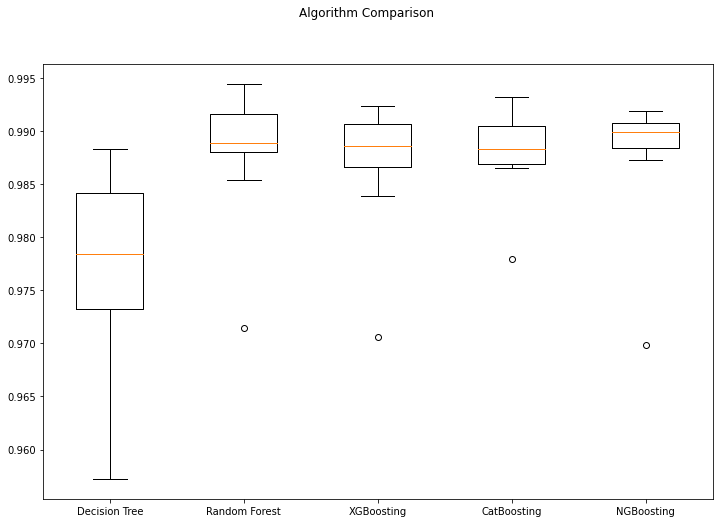

In [79]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 1년

# Prepare Data for Analysis

In [80]:
df1 = df['2021-01-01':]
df1.reset_index(inplace=True)

In [81]:
training_size = int(len(df1)*0.70)

df1_train = df1.loc[:training_size, :]
df1_test = df1.loc[training_size:, :]

In [82]:
df1_train.drop(['Date'], axis=1, inplace=True)
df1_test.drop(['Date'], axis=1, inplace=True)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
scaler = RobustScaler()
scaler.fit(df1_train)

df1_train[df1_train.columns] = scaler.transform(df1_train[df1_train.columns]) 
df1_test[df1_test.columns] = scaler.transform(df1_test[df1_test.columns]) 
# df1 = pd.DataFrame(scale.fit_transform(df1.values), columns=df1.columns, index=df1.index)

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ym\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
# feature_columns = list(df2.columns.difference(['Close']))
feature_columns = list(df2_train.columns.difference(['Close']))

In [85]:
y_train = df1_train['Close']
X_train = df1_train.drop(['Close'], axis=1)

y_test = df1_test['Close']
X_test = df1_test.drop(['Close'], axis=1)

## Decision Tree

In [86]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [87]:
print("Train MSE: ", mean_squared_error(y_train, dt.predict(X_train)), "\nTrain R2: ", r2_score(y_train, dt.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, dt_pred), "\nTest R2: ", r2_score(y_test, dt_pred))

Train MSE:  0.01121435639499311 
Train R2:  0.9684387121613017

Test MSE:  0.10077358634965052 
Test R2:  0.41136426587427666


In [88]:
dt.feature_importances_

array([0.00458241, 0.01655133, 0.        , 0.        , 0.        ,
       0.02405196, 0.00506328, 0.        , 0.        , 0.        ,
       0.00900982, 0.00421718, 0.        , 0.00768071, 0.        ,
       0.        , 0.        , 0.9288433 , 0.        ])

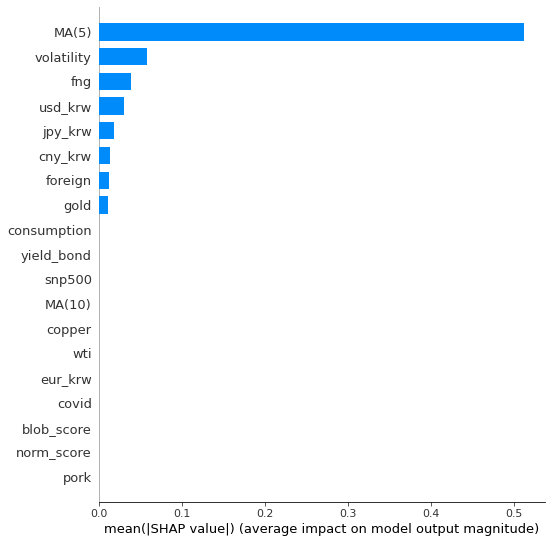

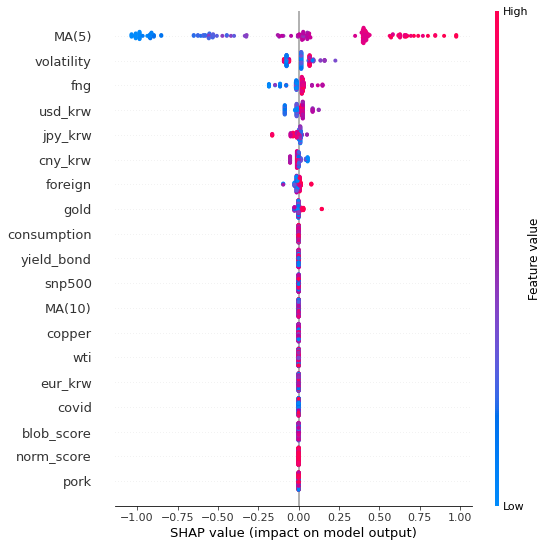

In [89]:
explainer = shap.Explainer(dt, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Ensemble Methods

### Random Forest

In [90]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
# scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=3)
# scores

In [91]:
print("Train MSE: ", mean_squared_error(y_train, rf.predict(X_train)), "\nTrain R2: ", r2_score(y_train, rf.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, rf_pred), "\nTest R2: ", r2_score(y_test, rf_pred))

Train MSE:  0.0030836416380908846 
Train R2:  0.9913215080827434

Test MSE:  0.12597077042441457 
Test R2:  0.26418320898216807


In [92]:
rf.feature_importances_

array([0.00315196, 0.10517965, 0.01141783, 0.00303465, 0.09282335,
       0.01208886, 0.00478771, 0.01040439, 0.00515492, 0.00262472,
       0.00447247, 0.0036838 , 0.00156539, 0.00315783, 0.00303219,
       0.00295487, 0.00167317, 0.62918261, 0.09960962])

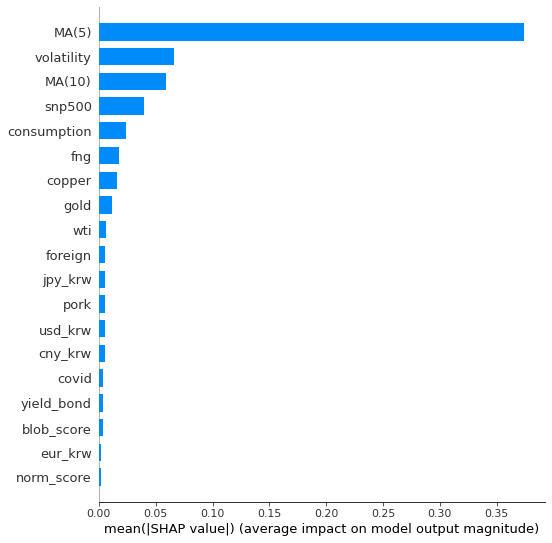

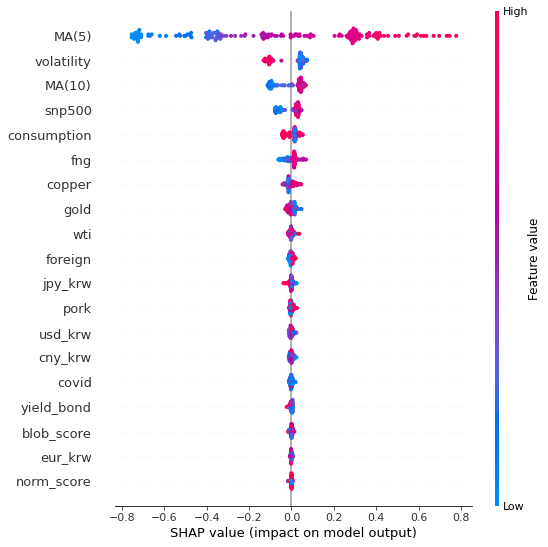

In [93]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### adaBoosting

In [94]:
ada = AdaBoostRegressor(n_estimators=300, random_state=42, learning_rate=0.1)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)

In [95]:
print("Train MSE: ", mean_squared_error(y_train, ada.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ada.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, ada_pred), "\nTest R2: ", r2_score(y_test, ada_pred))

Train MSE:  0.010752870113874364 
Train R2:  0.9697375028220392
Test MSE:  0.07394876072962993 
Test R2:  0.5680526551000917


In [96]:
feature_importance = ada.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

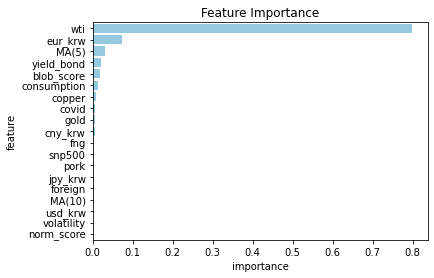

In [97]:
ada_importance = pd.DataFrame({'feature':feature_columns, 
                       'importance':feature_importance})\
    .sort_values('importance',ascending=False)

sns.barplot(x='importance',y='feature', data=ada_importance, color="skyblue").set_title('Feature Importance')

### XGBoosting

In [98]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [99]:
print("Train MSE: ", mean_squared_error(y_train, xgb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, xgb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, xgb_pred), "\nTest R2: ", r2_score(y_test, xgb_pred))

Train MSE:  5.80969857584263e-07 
Train R2:  0.9999983649389894

Test MSE:  0.19414179617942906 
Test R2:  -0.13401539885715397


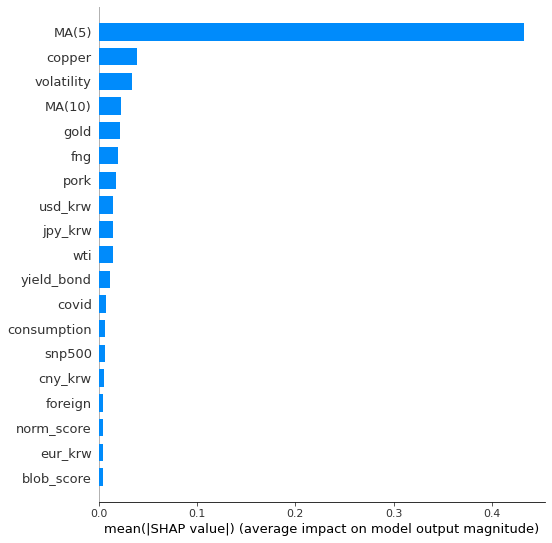

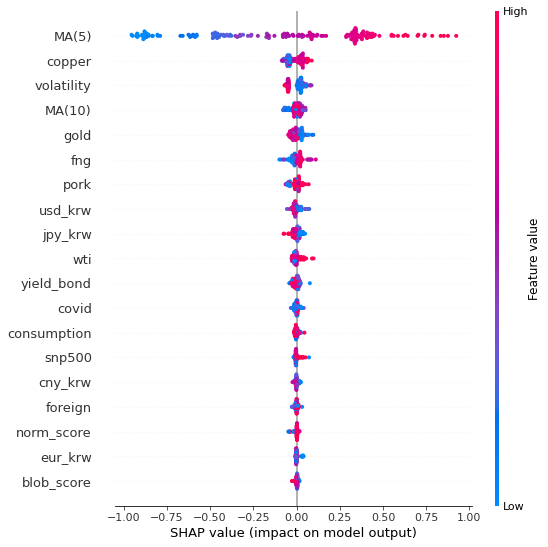

In [100]:
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### CatBoosting

In [101]:
cat = CatBoostRegressor(iterations=100, verbose=10)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_pred = cat.predict(X_train)

Learning rate set to 0.157496
0:	learn: 0.5355617	test: 0.6674043	best: 0.6674043 (0)	total: 13.5ms	remaining: 1.33s
10:	learn: 0.2065852	test: 0.5860884	best: 0.5691274 (6)	total: 25ms	remaining: 203ms
20:	learn: 0.1258783	test: 0.6014008	best: 0.5691274 (6)	total: 38.5ms	remaining: 145ms
30:	learn: 0.0978248	test: 0.6005294	best: 0.5691274 (6)	total: 53.2ms	remaining: 118ms
40:	learn: 0.0809524	test: 0.6052633	best: 0.5691274 (6)	total: 67.6ms	remaining: 97.3ms
50:	learn: 0.0662831	test: 0.6052833	best: 0.5691274 (6)	total: 81.8ms	remaining: 78.6ms
60:	learn: 0.0567931	test: 0.6095141	best: 0.5691274 (6)	total: 96.9ms	remaining: 61.9ms
70:	learn: 0.0499912	test: 0.6173313	best: 0.5691274 (6)	total: 112ms	remaining: 45.6ms
80:	learn: 0.0439616	test: 0.6198979	best: 0.5691274 (6)	total: 126ms	remaining: 29.6ms
90:	learn: 0.0372764	test: 0.6163050	best: 0.5691274 (6)	total: 141ms	remaining: 13.9ms
99:	learn: 0.0321171	test: 0.6174763	best: 0.5691274 (6)	total: 152ms	remaining: 0us

best

In [102]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.35423821832762115 
Train R2:  0.0030444924064162437

Test MSE:  0.4761186824836556 
Test R2:  -1.781090564965397


#### GridSearch

In [103]:
cat = CatBoostRegressor()

params = {
            'iterations':[100,500],
            'learning_rate':[0.01, 0.1],
            'verbose':[0.1,10],
            'bootstrap_type':['Bayesian', 'No']
}

search_results = cat.grid_search(params, X_train, y_train, cv=5)

print("\nBest Params : ", search_results['params'])

0:	learn: 0.5686683	test: 0.7454025	best: 0.7454025 (0)	total: 1.48ms	remaining: 147ms
10:	learn: 0.5326130	test: 0.7042075	best: 0.7042075 (10)	total: 15.5ms	remaining: 125ms
20:	learn: 0.5008104	test: 0.6669947	best: 0.6669947 (20)	total: 32.7ms	remaining: 123ms
30:	learn: 0.4722289	test: 0.6362559	best: 0.6362559 (30)	total: 47ms	remaining: 105ms
40:	learn: 0.4450527	test: 0.6043987	best: 0.6043987 (40)	total: 61ms	remaining: 87.8ms
50:	learn: 0.4191516	test: 0.5744362	best: 0.5744362 (50)	total: 78.6ms	remaining: 75.5ms
60:	learn: 0.3952991	test: 0.5470610	best: 0.5470610 (60)	total: 92.3ms	remaining: 59ms
70:	learn: 0.3735315	test: 0.5213383	best: 0.5213383 (70)	total: 105ms	remaining: 43ms
80:	learn: 0.3527635	test: 0.4976609	best: 0.4976609 (80)	total: 120ms	remaining: 28.1ms
90:	learn: 0.3331128	test: 0.4743935	best: 0.4743935 (90)	total: 135ms	remaining: 13.3ms
99:	learn: 0.3163031	test: 0.4539484	best: 0.4539484 (99)	total: 148ms	remaining: 0us

bestTest = 0.4539484065
bestIt

470:	learn: 0.1032615	test: 0.2212243	best: 0.2212243 (470)	total: 719ms	remaining: 44.3ms
480:	learn: 0.1015893	test: 0.2196591	best: 0.2196591 (480)	total: 739ms	remaining: 29.2ms
490:	learn: 0.0999650	test: 0.2183952	best: 0.2183952 (490)	total: 754ms	remaining: 13.8ms
499:	learn: 0.0986230	test: 0.2174885	best: 0.2174885 (499)	total: 768ms	remaining: 0us

bestTest = 0.2174885069
bestIteration = 499

4:	loss: 0.2174885	best: 0.1860488 (3)	total: 1.44s	remaining: 3.16s
0:	learn: 0.5694080	test: 0.7466629	best: 0.7466629 (0)	total: 14.5ms	remaining: 7.26s
10:	learn: 0.5357899	test: 0.7090316	best: 0.7090316 (10)	total: 27ms	remaining: 1.2s
20:	learn: 0.5028694	test: 0.6702651	best: 0.6702651 (20)	total: 40ms	remaining: 913ms
30:	learn: 0.4732953	test: 0.6353394	best: 0.6353394 (30)	total: 53.8ms	remaining: 814ms
40:	learn: 0.4462324	test: 0.6041579	best: 0.6041579 (40)	total: 67.8ms	remaining: 759ms
50:	learn: 0.4200698	test: 0.5735724	best: 0.5735724 (50)	total: 82ms	remaining: 722ms

390:	learn: 0.0028873	test: 0.1961406	best: 0.1961406 (390)	total: 658ms	remaining: 183ms
400:	learn: 0.0026768	test: 0.1961049	best: 0.1960939 (398)	total: 678ms	remaining: 167ms
410:	learn: 0.0024464	test: 0.1961205	best: 0.1960904 (401)	total: 694ms	remaining: 150ms
420:	learn: 0.0022213	test: 0.1960677	best: 0.1960677 (420)	total: 715ms	remaining: 134ms
430:	learn: 0.0020540	test: 0.1960609	best: 0.1960569 (423)	total: 730ms	remaining: 117ms
440:	learn: 0.0019050	test: 0.1960414	best: 0.1960398 (438)	total: 750ms	remaining: 100ms
450:	learn: 0.0017159	test: 0.1960252	best: 0.1960252 (450)	total: 766ms	remaining: 83.2ms
460:	learn: 0.0015758	test: 0.1960085	best: 0.1960085 (460)	total: 786ms	remaining: 66.5ms
470:	learn: 0.0014406	test: 0.1959977	best: 0.1959919 (463)	total: 802ms	remaining: 49.4ms
480:	learn: 0.0013088	test: 0.1959764	best: 0.1959764 (480)	total: 819ms	remaining: 32.4ms
490:	learn: 0.0011868	test: 0.1959882	best: 0.1959688 (483)	total: 832ms	remaining: 15.3ms
499:	

360:	learn: 0.0035589	test: 0.1500606	best: 0.1490908 (96)	total: 442ms	remaining: 170ms
370:	learn: 0.0031921	test: 0.1500981	best: 0.1490908 (96)	total: 453ms	remaining: 158ms
380:	learn: 0.0029070	test: 0.1501450	best: 0.1490908 (96)	total: 465ms	remaining: 145ms
390:	learn: 0.0027266	test: 0.1501570	best: 0.1490908 (96)	total: 476ms	remaining: 133ms
400:	learn: 0.0025033	test: 0.1501805	best: 0.1490908 (96)	total: 487ms	remaining: 120ms
410:	learn: 0.0023458	test: 0.1502065	best: 0.1490908 (96)	total: 503ms	remaining: 109ms
420:	learn: 0.0022305	test: 0.1501893	best: 0.1490908 (96)	total: 514ms	remaining: 96.4ms
430:	learn: 0.0020445	test: 0.1501796	best: 0.1490908 (96)	total: 525ms	remaining: 84ms
440:	learn: 0.0018332	test: 0.1501635	best: 0.1490908 (96)	total: 536ms	remaining: 71.8ms
450:	learn: 0.0016912	test: 0.1501154	best: 0.1490908 (96)	total: 548ms	remaining: 59.5ms
460:	learn: 0.0015487	test: 0.1501271	best: 0.1490908 (96)	total: 560ms	remaining: 47.3ms
470:	learn: 0.0014

260:	learn: 0.0104230	test: 0.1357193	best: 0.1353776 (241)	total: 351ms	remaining: 322ms
270:	learn: 0.0094510	test: 0.1354715	best: 0.1353776 (241)	total: 365ms	remaining: 308ms
280:	learn: 0.0087399	test: 0.1355996	best: 0.1353776 (241)	total: 380ms	remaining: 296ms
290:	learn: 0.0080511	test: 0.1356987	best: 0.1353776 (241)	total: 393ms	remaining: 282ms
300:	learn: 0.0073560	test: 0.1357270	best: 0.1353776 (241)	total: 407ms	remaining: 269ms
310:	learn: 0.0065440	test: 0.1357850	best: 0.1353776 (241)	total: 419ms	remaining: 255ms
320:	learn: 0.0059204	test: 0.1357660	best: 0.1353776 (241)	total: 433ms	remaining: 241ms
330:	learn: 0.0053992	test: 0.1356543	best: 0.1353776 (241)	total: 447ms	remaining: 228ms
340:	learn: 0.0050965	test: 0.1355013	best: 0.1353776 (241)	total: 460ms	remaining: 214ms
350:	learn: 0.0047304	test: 0.1355084	best: 0.1353776 (241)	total: 474ms	remaining: 201ms
360:	learn: 0.0043890	test: 0.1355124	best: 0.1353776 (241)	total: 488ms	remaining: 188ms
370:	learn

170:	learn: 0.0231281	test: 0.1918152	best: 0.1918152 (170)	total: 278ms	remaining: 534ms
180:	learn: 0.0212203	test: 0.1913201	best: 0.1913148 (177)	total: 290ms	remaining: 511ms
190:	learn: 0.0193387	test: 0.1907181	best: 0.1907181 (190)	total: 304ms	remaining: 493ms
200:	learn: 0.0175200	test: 0.1905969	best: 0.1904834 (198)	total: 317ms	remaining: 472ms
210:	learn: 0.0160099	test: 0.1900586	best: 0.1900573 (209)	total: 331ms	remaining: 453ms
220:	learn: 0.0143086	test: 0.1894293	best: 0.1894293 (220)	total: 344ms	remaining: 435ms
230:	learn: 0.0128205	test: 0.1890517	best: 0.1890517 (230)	total: 357ms	remaining: 415ms
240:	learn: 0.0120025	test: 0.1889665	best: 0.1889585 (239)	total: 369ms	remaining: 397ms
250:	learn: 0.0110463	test: 0.1885661	best: 0.1885661 (250)	total: 381ms	remaining: 378ms
260:	learn: 0.0101818	test: 0.1882597	best: 0.1882478 (258)	total: 393ms	remaining: 360ms
270:	learn: 0.0091200	test: 0.1878781	best: 0.1878781 (270)	total: 405ms	remaining: 342ms
280:	learn

In [104]:
cat = CatBoostRegressor(iterations=500, verbose=10, learning_rate= 0.1, bootstrap_type= 'Bayesian')

cat.fit(X_train, y_train, eval_set=(X_test, y_test))
cat.set_feature_names(feature_columns)

cat_pred = cat.predict(X_test)
# train_preds = cat.predict(X_train)

0:	learn: 0.5574942	test: 0.6831712	best: 0.6831712 (0)	total: 1.69ms	remaining: 842ms
10:	learn: 0.2947047	test: 0.6067909	best: 0.5910728 (6)	total: 16.2ms	remaining: 720ms
20:	learn: 0.1834946	test: 0.6219357	best: 0.5910728 (6)	total: 32ms	remaining: 729ms
30:	learn: 0.1406738	test: 0.6155588	best: 0.5910728 (6)	total: 48.1ms	remaining: 728ms
40:	learn: 0.1166123	test: 0.6185984	best: 0.5910728 (6)	total: 65.8ms	remaining: 737ms
50:	learn: 0.1020612	test: 0.6120267	best: 0.5910728 (6)	total: 81.2ms	remaining: 715ms
60:	learn: 0.0908402	test: 0.6106266	best: 0.5910728 (6)	total: 96.5ms	remaining: 695ms
70:	learn: 0.0812284	test: 0.6115627	best: 0.5910728 (6)	total: 113ms	remaining: 682ms
80:	learn: 0.0719415	test: 0.6115594	best: 0.5910728 (6)	total: 129ms	remaining: 667ms
90:	learn: 0.0643723	test: 0.6194498	best: 0.5910728 (6)	total: 144ms	remaining: 649ms
100:	learn: 0.0569971	test: 0.6175946	best: 0.5910728 (6)	total: 159ms	remaining: 628ms
110:	learn: 0.0515244	test: 0.6184361	

In [105]:
print("Train MSE: ", mean_squared_error(y_train, cat.predict(X_train)), "\nTrain R2: ", r2_score(y_train, cat.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, cat_pred), "\nTest R2: ", r2_score(y_test, cat_pred))

Train MSE:  0.3578860411956469 
Train R2:  -0.007221811201853834

Test MSE:  0.5421784399192725 
Test R2:  -2.1669568938599872


In [106]:
cat.feature_importances_

array([ 3.06301474,  0.        ,  4.12798921,  0.54663609,  0.        ,
        5.44404307,  0.        ,  2.40266294,  2.75309222,  2.52498272,
        0.        ,  0.73830871,  2.91706289, 11.04983836,  2.7793954 ,
        1.69511728,  1.26295884, 32.25538478, 26.43951276])

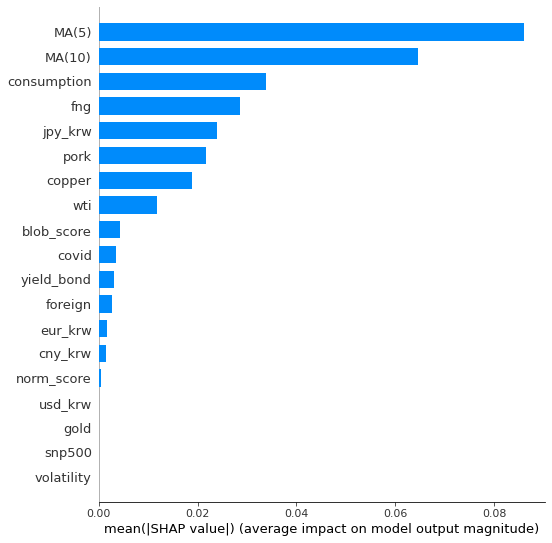

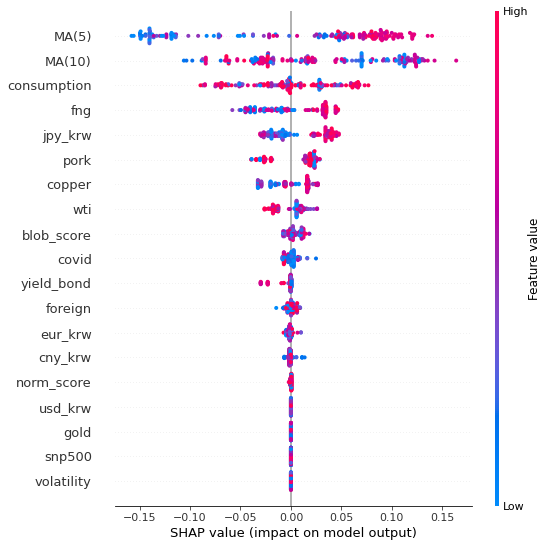

In [107]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

### NGBoosting

In [108]:
ngb = NGBRegressor()

ngb.fit(X_train, y_train)
ngb_pred = ngb.predict(X_test)
ngb_dists = ngb.pred_dist(X_test)

[iter 0] loss=0.9016 val_loss=0.0000 scale=1.0000 norm=0.7049
[iter 100] loss=-0.1477 val_loss=0.0000 scale=2.0000 norm=0.9094
[iter 200] loss=-0.9575 val_loss=0.0000 scale=2.0000 norm=0.8188
[iter 300] loss=-1.5261 val_loss=0.0000 scale=2.0000 norm=0.6697
[iter 400] loss=-1.8100 val_loss=0.0000 scale=1.0000 norm=0.3250


In [109]:
print("Train MSE: ", mean_squared_error(y_train, ngb.predict(X_train)), "\nTrain R2: ", r2_score(y_train, ngb.predict(X_train)))
print("\nTest MSE: ", mean_squared_error(y_test, ngb_pred), "\nTest R2: ", r2_score(y_test, ngb_pred))

Train MSE:  0.0015917110916854776 
Train R2:  0.9955203446233292

Test MSE:  0.2285556651735339 
Test R2:  -0.3350326869505398


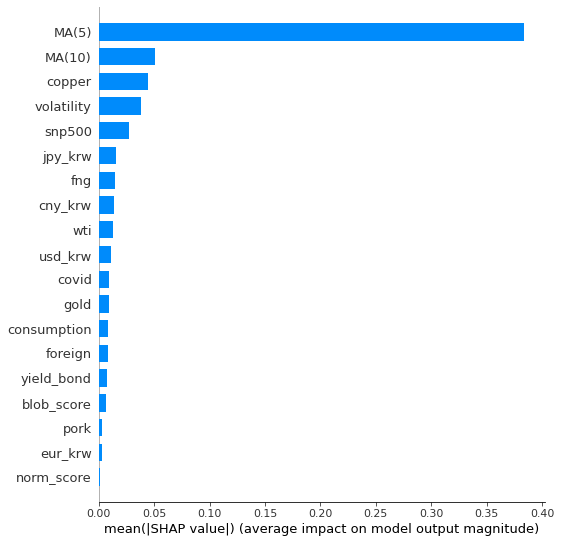

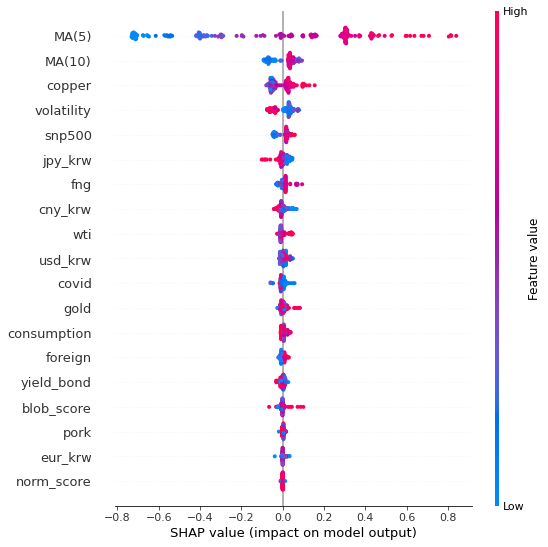

In [110]:
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

## Summary

### Prediction + Graph

In [111]:
final_pred = pd.DataFrame({
    # 'svr':svrdf,
    'dt': dt_pred,
    'rf': rf_pred,
    # 'ada': ada_pred,
    'xgb': xgb_pred,
    'cat': cat_pred,
    'ngb': ngb_pred,
    'true': y_test
    # 'lstm': lstm_pred
})

pd.options.display.float_format = '{:.4f}'.format
final_pred.head()

,dt,rf,xgb,cat,ngb,true
172,0.2727,0.3144,0.3408,0.0004,0.3105,0.3409
173,0.2727,0.2972,0.3286,-0.0650,0.2701,0.4205
174,0.2727,0.2922,0.3311,-0.0831,0.2517,0.3182
175,0.2727,0.2811,0.3515,-0.0742,0.2355,0.1932
176,0.2727,0.2810,0.3714,-0.0469,0.4056,0.1477


In [112]:
final_pred.tail()

,dt,rf,xgb,cat,ngb,true
242,-0.6364,-0.4904,-0.3301,-0.1545,-0.4401,-0.8750
243,-0.6364,-0.5374,-0.3312,-0.1473,-0.4435,-0.9489
244,-0.6364,-0.5417,-0.3360,-0.1385,-0.4414,-0.9432
245,-0.6364,-0.6141,-0.6082,-0.1385,-0.5090,-1.0341
246,-0.6364,-0.6134,-0.6120,-0.1473,-0.5039,-1.0568


In [113]:
model_names = [dt, rf, xgb, cat, ngb]

r2_train = []
r2_test = []
MSE_train = []
MSE_test = []
for model in model_names:
    r2_train.append(r2_score(y_train, model.predict(X_train)))
    r2_test.append(r2_score(y_test, model.predict(X_test)))
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))

In [114]:
evaluation = pd.DataFrame([MSE_train, MSE_test, r2_train, r2_test],
                          columns = pd.Index(['Decision Tree', 'Random Forest', 'XGBoosting', 'CatBoosting', 'NGBoosting']),
                          index = pd.Index(['MSE_train', 'MSE_test', 'R2_train', 'R2_test']))

evaluation

,Decision Tree,Random Forest,XGBoosting,CatBoosting,NGBoosting
MSE_train,0.0112,0.0031,0.0000,0.3579,0.0016
MSE_test,0.1008,0.1260,0.1941,0.5422,0.2286
R2_train,0.9684,0.9913,1.0000,-0.0072,0.9955
R2_test,0.4114,0.2642,-0.1340,-2.1670,-0.3350


In [115]:
names = cycle(['dt',	'rf',	'xgb',	'cat',	'ngb', 'true'])

fig = px.line(final_pred[:], x=final_pred.index[:], y=[final_pred['dt'][:],final_pred['rf'][:],
                                          final_pred['xgb'][:], final_pred['cat'][:], final_pred['ngb'][:], final_pred['true'][:]],
             labels={'x': 'Timestamp','value':'Stock close price'})
fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### BoxPlot
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [116]:
from sklearn import model_selection
from keras.wrappers.scikit_learn import KerasClassifier

models = []
# models.append(('SVM', SVR()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
# models.append(('adaBoosting', AdaBoostRegressor()))
models.append(('XGBoosting', XGBRegressor()))
models.append(('CatBoosting', CatBoostRegressor()))
models.append(('NGBoosting', NGBRegressor()))
# models.append(('LSTM', lstm))
# models.append(('GRU', SVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
seed=42

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
	if name != 'LSTM':
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	else :
		lstm = Sequential()
		lstm.add(Dense(50, input_dim=18, activation='relu'))
		lstm.add(Dense(50, activation='relu'))
		lstm.add(Dense(1)) 
		lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
		model = KerasClassifier(build_fn=lstm, epochs=150, batch_size=10, verbose=0)
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring) # 수정필요
		results.append(cv_results)
		names.append(name)
		msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	# print(msg)

print(results) 

Learning rate set to 0.030497
0:	learn: 0.5863219	total: 1.69ms	remaining: 1.69s
1:	learn: 0.5723258	total: 3.24ms	remaining: 1.62s
2:	learn: 0.5608283	total: 4.63ms	remaining: 1.54s
3:	learn: 0.5489381	total: 6.12ms	remaining: 1.52s
4:	learn: 0.5384948	total: 7.55ms	remaining: 1.5s
5:	learn: 0.5271701	total: 8.88ms	remaining: 1.47s
6:	learn: 0.5164153	total: 10.3ms	remaining: 1.47s
7:	learn: 0.5067508	total: 11.8ms	remaining: 1.46s
8:	learn: 0.4960978	total: 13.1ms	remaining: 1.45s
9:	learn: 0.4856862	total: 14.6ms	remaining: 1.44s
10:	learn: 0.4771199	total: 16ms	remaining: 1.44s
11:	learn: 0.4676882	total: 17.6ms	remaining: 1.45s
12:	learn: 0.4585417	total: 19.1ms	remaining: 1.45s
13:	learn: 0.4494922	total: 20.7ms	remaining: 1.46s
14:	learn: 0.4404087	total: 22.3ms	remaining: 1.46s
15:	learn: 0.4309883	total: 23.3ms	remaining: 1.43s
16:	learn: 0.4229898	total: 24.8ms	remaining: 1.43s
17:	learn: 0.4144279	total: 26.3ms	remaining: 1.44s
18:	learn: 0.4065905	total: 27.8ms	remaining: 1

245:	learn: 0.0678461	total: 338ms	remaining: 1.03s
246:	learn: 0.0674899	total: 340ms	remaining: 1.03s
247:	learn: 0.0672317	total: 341ms	remaining: 1.03s
248:	learn: 0.0670451	total: 343ms	remaining: 1.03s
249:	learn: 0.0667076	total: 344ms	remaining: 1.03s
250:	learn: 0.0664272	total: 346ms	remaining: 1.03s
251:	learn: 0.0661797	total: 348ms	remaining: 1.03s
252:	learn: 0.0658116	total: 349ms	remaining: 1.03s
253:	learn: 0.0654430	total: 351ms	remaining: 1.03s
254:	learn: 0.0651865	total: 353ms	remaining: 1.03s
255:	learn: 0.0648549	total: 355ms	remaining: 1.03s
256:	learn: 0.0646566	total: 356ms	remaining: 1.03s
257:	learn: 0.0645242	total: 358ms	remaining: 1.03s
258:	learn: 0.0643745	total: 360ms	remaining: 1.03s
259:	learn: 0.0640367	total: 362ms	remaining: 1.03s
260:	learn: 0.0638386	total: 363ms	remaining: 1.03s
261:	learn: 0.0635085	total: 364ms	remaining: 1.03s
262:	learn: 0.0632606	total: 366ms	remaining: 1.02s
263:	learn: 0.0629131	total: 367ms	remaining: 1.02s
264:	learn: 

508:	learn: 0.0277216	total: 687ms	remaining: 663ms
509:	learn: 0.0277048	total: 689ms	remaining: 662ms
510:	learn: 0.0276661	total: 690ms	remaining: 660ms
511:	learn: 0.0275590	total: 692ms	remaining: 659ms
512:	learn: 0.0274399	total: 693ms	remaining: 658ms
513:	learn: 0.0273164	total: 695ms	remaining: 657ms
514:	learn: 0.0272320	total: 696ms	remaining: 655ms
515:	learn: 0.0272100	total: 697ms	remaining: 654ms
516:	learn: 0.0271693	total: 699ms	remaining: 653ms
517:	learn: 0.0270799	total: 700ms	remaining: 652ms
518:	learn: 0.0269365	total: 702ms	remaining: 650ms
519:	learn: 0.0268463	total: 703ms	remaining: 649ms
520:	learn: 0.0268220	total: 705ms	remaining: 648ms
521:	learn: 0.0267353	total: 706ms	remaining: 647ms
522:	learn: 0.0266508	total: 708ms	remaining: 646ms
523:	learn: 0.0266022	total: 709ms	remaining: 644ms
524:	learn: 0.0265309	total: 710ms	remaining: 643ms
525:	learn: 0.0265158	total: 712ms	remaining: 641ms
526:	learn: 0.0264321	total: 713ms	remaining: 640ms
527:	learn: 

759:	learn: 0.0135051	total: 1.04s	remaining: 327ms
760:	learn: 0.0134373	total: 1.04s	remaining: 326ms
761:	learn: 0.0133695	total: 1.04s	remaining: 325ms
762:	learn: 0.0133588	total: 1.04s	remaining: 324ms
763:	learn: 0.0133026	total: 1.04s	remaining: 322ms
764:	learn: 0.0132834	total: 1.04s	remaining: 321ms
765:	learn: 0.0132385	total: 1.05s	remaining: 320ms
766:	learn: 0.0132167	total: 1.05s	remaining: 319ms
767:	learn: 0.0131614	total: 1.05s	remaining: 317ms
768:	learn: 0.0131327	total: 1.05s	remaining: 316ms
769:	learn: 0.0130886	total: 1.05s	remaining: 315ms
770:	learn: 0.0130780	total: 1.05s	remaining: 314ms
771:	learn: 0.0130711	total: 1.06s	remaining: 312ms
772:	learn: 0.0130640	total: 1.06s	remaining: 311ms
773:	learn: 0.0130452	total: 1.06s	remaining: 310ms
774:	learn: 0.0129923	total: 1.06s	remaining: 308ms
775:	learn: 0.0129741	total: 1.06s	remaining: 307ms
776:	learn: 0.0129393	total: 1.06s	remaining: 306ms
777:	learn: 0.0128873	total: 1.07s	remaining: 304ms
778:	learn: 

990:	learn: 0.0073953	total: 1.39s	remaining: 12.6ms
991:	learn: 0.0073675	total: 1.39s	remaining: 11.2ms
992:	learn: 0.0073638	total: 1.39s	remaining: 9.8ms
993:	learn: 0.0073504	total: 1.39s	remaining: 8.4ms
994:	learn: 0.0073230	total: 1.39s	remaining: 7.01ms
995:	learn: 0.0073149	total: 1.4s	remaining: 5.61ms
996:	learn: 0.0072889	total: 1.4s	remaining: 4.2ms
997:	learn: 0.0072831	total: 1.4s	remaining: 2.8ms
998:	learn: 0.0072622	total: 1.4s	remaining: 1.4ms
999:	learn: 0.0072409	total: 1.4s	remaining: 0us
Learning rate set to 0.030497
0:	learn: 0.5776693	total: 1.77ms	remaining: 1.77s
1:	learn: 0.5653603	total: 3.25ms	remaining: 1.62s
2:	learn: 0.5545698	total: 4.75ms	remaining: 1.58s
3:	learn: 0.5438279	total: 6.25ms	remaining: 1.56s
4:	learn: 0.5342245	total: 7.79ms	remaining: 1.55s
5:	learn: 0.5225248	total: 9.21ms	remaining: 1.53s
6:	learn: 0.5129308	total: 10.8ms	remaining: 1.53s
7:	learn: 0.5029961	total: 12.3ms	remaining: 1.52s
8:	learn: 0.4930395	total: 13.7ms	remaining: 

155:	learn: 0.0963066	total: 307ms	remaining: 1.66s
156:	learn: 0.0958555	total: 310ms	remaining: 1.67s
157:	learn: 0.0954876	total: 313ms	remaining: 1.67s
158:	learn: 0.0949957	total: 315ms	remaining: 1.67s
159:	learn: 0.0946291	total: 317ms	remaining: 1.67s
160:	learn: 0.0942345	total: 320ms	remaining: 1.67s
161:	learn: 0.0936849	total: 322ms	remaining: 1.66s
162:	learn: 0.0933920	total: 323ms	remaining: 1.66s
163:	learn: 0.0929788	total: 325ms	remaining: 1.66s
164:	learn: 0.0926395	total: 327ms	remaining: 1.65s
165:	learn: 0.0921453	total: 328ms	remaining: 1.65s
166:	learn: 0.0917760	total: 329ms	remaining: 1.64s
167:	learn: 0.0912698	total: 331ms	remaining: 1.64s
168:	learn: 0.0908076	total: 332ms	remaining: 1.63s
169:	learn: 0.0904203	total: 334ms	remaining: 1.63s
170:	learn: 0.0898606	total: 336ms	remaining: 1.63s
171:	learn: 0.0895011	total: 337ms	remaining: 1.62s
172:	learn: 0.0890683	total: 339ms	remaining: 1.62s
173:	learn: 0.0886594	total: 340ms	remaining: 1.61s
174:	learn: 

404:	learn: 0.0395163	total: 653ms	remaining: 959ms
405:	learn: 0.0392806	total: 655ms	remaining: 958ms
406:	learn: 0.0392174	total: 656ms	remaining: 956ms
407:	learn: 0.0390386	total: 658ms	remaining: 954ms
408:	learn: 0.0388823	total: 659ms	remaining: 952ms
409:	learn: 0.0386946	total: 661ms	remaining: 951ms
410:	learn: 0.0385052	total: 662ms	remaining: 949ms
411:	learn: 0.0383856	total: 664ms	remaining: 947ms
412:	learn: 0.0383338	total: 665ms	remaining: 945ms
413:	learn: 0.0382752	total: 667ms	remaining: 944ms
414:	learn: 0.0380991	total: 668ms	remaining: 942ms
415:	learn: 0.0380273	total: 670ms	remaining: 940ms
416:	learn: 0.0378046	total: 671ms	remaining: 938ms
417:	learn: 0.0376917	total: 673ms	remaining: 937ms
418:	learn: 0.0374860	total: 674ms	remaining: 935ms
419:	learn: 0.0373235	total: 675ms	remaining: 933ms
420:	learn: 0.0371542	total: 677ms	remaining: 931ms
421:	learn: 0.0369727	total: 678ms	remaining: 929ms
422:	learn: 0.0368329	total: 679ms	remaining: 927ms
423:	learn: 

662:	learn: 0.0172234	total: 1s	remaining: 509ms
663:	learn: 0.0171455	total: 1s	remaining: 508ms
664:	learn: 0.0171329	total: 1s	remaining: 506ms
665:	learn: 0.0170333	total: 1.01s	remaining: 505ms
666:	learn: 0.0169723	total: 1.01s	remaining: 503ms
667:	learn: 0.0169051	total: 1.01s	remaining: 502ms
668:	learn: 0.0168949	total: 1.01s	remaining: 500ms
669:	learn: 0.0168844	total: 1.01s	remaining: 498ms
670:	learn: 0.0168189	total: 1.01s	remaining: 497ms
671:	learn: 0.0167724	total: 1.01s	remaining: 495ms
672:	learn: 0.0167264	total: 1.01s	remaining: 494ms
673:	learn: 0.0166470	total: 1.02s	remaining: 492ms
674:	learn: 0.0165756	total: 1.02s	remaining: 490ms
675:	learn: 0.0165162	total: 1.02s	remaining: 489ms
676:	learn: 0.0164961	total: 1.02s	remaining: 487ms
677:	learn: 0.0164322	total: 1.02s	remaining: 486ms
678:	learn: 0.0163717	total: 1.02s	remaining: 484ms
679:	learn: 0.0163252	total: 1.02s	remaining: 483ms
680:	learn: 0.0162962	total: 1.03s	remaining: 481ms
681:	learn: 0.0162866

920:	learn: 0.0083727	total: 1.35s	remaining: 116ms
921:	learn: 0.0083652	total: 1.35s	remaining: 115ms
922:	learn: 0.0083233	total: 1.35s	remaining: 113ms
923:	learn: 0.0083162	total: 1.36s	remaining: 112ms
924:	learn: 0.0083081	total: 1.36s	remaining: 110ms
925:	learn: 0.0082774	total: 1.36s	remaining: 109ms
926:	learn: 0.0082692	total: 1.36s	remaining: 107ms
927:	learn: 0.0082594	total: 1.36s	remaining: 106ms
928:	learn: 0.0082223	total: 1.36s	remaining: 104ms
929:	learn: 0.0082049	total: 1.36s	remaining: 103ms
930:	learn: 0.0081846	total: 1.37s	remaining: 101ms
931:	learn: 0.0081519	total: 1.37s	remaining: 99.8ms
932:	learn: 0.0081486	total: 1.37s	remaining: 98.3ms
933:	learn: 0.0081413	total: 1.37s	remaining: 96.8ms
934:	learn: 0.0081221	total: 1.37s	remaining: 95.4ms
935:	learn: 0.0081067	total: 1.37s	remaining: 93.9ms
936:	learn: 0.0080797	total: 1.37s	remaining: 92.4ms
937:	learn: 0.0080479	total: 1.38s	remaining: 91ms
938:	learn: 0.0080250	total: 1.38s	remaining: 89.5ms
939:	l

151:	learn: 0.1031850	total: 216ms	remaining: 1.2s
152:	learn: 0.1024940	total: 217ms	remaining: 1.2s
153:	learn: 0.1019546	total: 219ms	remaining: 1.2s
154:	learn: 0.1013013	total: 220ms	remaining: 1.2s
155:	learn: 0.1007956	total: 222ms	remaining: 1.2s
156:	learn: 0.1002658	total: 223ms	remaining: 1.2s
157:	learn: 0.0997710	total: 225ms	remaining: 1.2s
158:	learn: 0.0993699	total: 226ms	remaining: 1.2s
159:	learn: 0.0988888	total: 228ms	remaining: 1.2s
160:	learn: 0.0984432	total: 229ms	remaining: 1.19s
161:	learn: 0.0980272	total: 231ms	remaining: 1.19s
162:	learn: 0.0975121	total: 233ms	remaining: 1.19s
163:	learn: 0.0969716	total: 234ms	remaining: 1.19s
164:	learn: 0.0965301	total: 236ms	remaining: 1.19s
165:	learn: 0.0960848	total: 237ms	remaining: 1.19s
166:	learn: 0.0955749	total: 238ms	remaining: 1.19s
167:	learn: 0.0952465	total: 240ms	remaining: 1.19s
168:	learn: 0.0947151	total: 241ms	remaining: 1.19s
169:	learn: 0.0941246	total: 242ms	remaining: 1.18s
170:	learn: 0.0937071

408:	learn: 0.0393482	total: 565ms	remaining: 816ms
409:	learn: 0.0392148	total: 566ms	remaining: 815ms
410:	learn: 0.0390141	total: 568ms	remaining: 814ms
411:	learn: 0.0389754	total: 569ms	remaining: 812ms
412:	learn: 0.0388292	total: 571ms	remaining: 811ms
413:	learn: 0.0387370	total: 572ms	remaining: 810ms
414:	learn: 0.0386914	total: 574ms	remaining: 810ms
415:	learn: 0.0386453	total: 576ms	remaining: 809ms
416:	learn: 0.0385563	total: 578ms	remaining: 808ms
417:	learn: 0.0383606	total: 580ms	remaining: 808ms
418:	learn: 0.0383213	total: 581ms	remaining: 806ms
419:	learn: 0.0382581	total: 582ms	remaining: 804ms
420:	learn: 0.0381556	total: 584ms	remaining: 803ms
421:	learn: 0.0379757	total: 586ms	remaining: 802ms
422:	learn: 0.0378180	total: 587ms	remaining: 801ms
423:	learn: 0.0376297	total: 588ms	remaining: 799ms
424:	learn: 0.0375034	total: 590ms	remaining: 798ms
425:	learn: 0.0374631	total: 591ms	remaining: 796ms
426:	learn: 0.0373279	total: 592ms	remaining: 795ms
427:	learn: 

667:	learn: 0.0191812	total: 914ms	remaining: 454ms
668:	learn: 0.0191230	total: 916ms	remaining: 453ms
669:	learn: 0.0191006	total: 917ms	remaining: 452ms
670:	learn: 0.0190288	total: 919ms	remaining: 451ms
671:	learn: 0.0189593	total: 921ms	remaining: 449ms
672:	learn: 0.0188938	total: 922ms	remaining: 448ms
673:	learn: 0.0188543	total: 924ms	remaining: 447ms
674:	learn: 0.0187933	total: 926ms	remaining: 446ms
675:	learn: 0.0187107	total: 928ms	remaining: 445ms
676:	learn: 0.0186672	total: 929ms	remaining: 443ms
677:	learn: 0.0185849	total: 931ms	remaining: 442ms
678:	learn: 0.0185221	total: 933ms	remaining: 441ms
679:	learn: 0.0184599	total: 935ms	remaining: 440ms
680:	learn: 0.0184025	total: 937ms	remaining: 439ms
681:	learn: 0.0183037	total: 938ms	remaining: 437ms
682:	learn: 0.0182727	total: 940ms	remaining: 436ms
683:	learn: 0.0182519	total: 941ms	remaining: 435ms
684:	learn: 0.0182094	total: 943ms	remaining: 433ms
685:	learn: 0.0181508	total: 944ms	remaining: 432ms
686:	learn: 

860:	learn: 0.0112353	total: 1.27s	remaining: 204ms
861:	learn: 0.0112179	total: 1.27s	remaining: 203ms
862:	learn: 0.0111951	total: 1.27s	remaining: 202ms
863:	learn: 0.0111604	total: 1.27s	remaining: 201ms
864:	learn: 0.0111474	total: 1.28s	remaining: 199ms
865:	learn: 0.0111307	total: 1.28s	remaining: 199ms
866:	learn: 0.0110987	total: 1.29s	remaining: 197ms
867:	learn: 0.0110811	total: 1.29s	remaining: 196ms
868:	learn: 0.0110713	total: 1.29s	remaining: 195ms
869:	learn: 0.0110587	total: 1.29s	remaining: 194ms
870:	learn: 0.0110361	total: 1.3s	remaining: 192ms
871:	learn: 0.0110012	total: 1.3s	remaining: 191ms
872:	learn: 0.0109827	total: 1.3s	remaining: 190ms
873:	learn: 0.0109331	total: 1.31s	remaining: 189ms
874:	learn: 0.0109229	total: 1.31s	remaining: 187ms
875:	learn: 0.0109089	total: 1.32s	remaining: 187ms
876:	learn: 0.0108798	total: 1.33s	remaining: 186ms
877:	learn: 0.0108433	total: 1.33s	remaining: 185ms
878:	learn: 0.0107950	total: 1.34s	remaining: 184ms
879:	learn: 0.0

21:	learn: 0.3875610	total: 36.8ms	remaining: 1.64s
22:	learn: 0.3796080	total: 38.6ms	remaining: 1.64s
23:	learn: 0.3723533	total: 40.1ms	remaining: 1.63s
24:	learn: 0.3662873	total: 41.7ms	remaining: 1.63s
25:	learn: 0.3612561	total: 43.5ms	remaining: 1.63s
26:	learn: 0.3543120	total: 45.2ms	remaining: 1.63s
27:	learn: 0.3484532	total: 46.9ms	remaining: 1.63s
28:	learn: 0.3428667	total: 48.7ms	remaining: 1.63s
29:	learn: 0.3371712	total: 50.5ms	remaining: 1.63s
30:	learn: 0.3313052	total: 52.4ms	remaining: 1.64s
31:	learn: 0.3261485	total: 54.6ms	remaining: 1.65s
32:	learn: 0.3208496	total: 56.3ms	remaining: 1.65s
33:	learn: 0.3154786	total: 58.1ms	remaining: 1.65s
34:	learn: 0.3105099	total: 59.6ms	remaining: 1.64s
35:	learn: 0.3048660	total: 61.2ms	remaining: 1.64s
36:	learn: 0.2998777	total: 62.9ms	remaining: 1.64s
37:	learn: 0.2952834	total: 64.6ms	remaining: 1.64s
38:	learn: 0.2906451	total: 66.3ms	remaining: 1.63s
39:	learn: 0.2867774	total: 68.3ms	remaining: 1.64s
40:	learn: 0

238:	learn: 0.0712492	total: 385ms	remaining: 1.23s
239:	learn: 0.0709665	total: 387ms	remaining: 1.23s
240:	learn: 0.0707669	total: 389ms	remaining: 1.22s
241:	learn: 0.0705766	total: 390ms	remaining: 1.22s
242:	learn: 0.0702599	total: 392ms	remaining: 1.22s
243:	learn: 0.0699856	total: 394ms	remaining: 1.22s
244:	learn: 0.0697186	total: 396ms	remaining: 1.22s
245:	learn: 0.0694630	total: 397ms	remaining: 1.22s
246:	learn: 0.0691431	total: 399ms	remaining: 1.22s
247:	learn: 0.0688706	total: 401ms	remaining: 1.21s
248:	learn: 0.0685655	total: 402ms	remaining: 1.21s
249:	learn: 0.0682545	total: 404ms	remaining: 1.21s
250:	learn: 0.0681322	total: 406ms	remaining: 1.21s
251:	learn: 0.0677537	total: 407ms	remaining: 1.21s
252:	learn: 0.0674091	total: 409ms	remaining: 1.21s
253:	learn: 0.0672766	total: 410ms	remaining: 1.21s
254:	learn: 0.0670388	total: 412ms	remaining: 1.2s
255:	learn: 0.0668418	total: 414ms	remaining: 1.2s
256:	learn: 0.0666520	total: 415ms	remaining: 1.2s
257:	learn: 0.0

461:	learn: 0.0339281	total: 735ms	remaining: 856ms
462:	learn: 0.0338199	total: 737ms	remaining: 854ms
463:	learn: 0.0337757	total: 738ms	remaining: 853ms
464:	learn: 0.0336332	total: 740ms	remaining: 851ms
465:	learn: 0.0334972	total: 742ms	remaining: 850ms
466:	learn: 0.0333748	total: 744ms	remaining: 849ms
467:	learn: 0.0332303	total: 746ms	remaining: 847ms
468:	learn: 0.0331192	total: 747ms	remaining: 846ms
469:	learn: 0.0329462	total: 749ms	remaining: 845ms
470:	learn: 0.0328310	total: 751ms	remaining: 843ms
471:	learn: 0.0327029	total: 753ms	remaining: 842ms
472:	learn: 0.0325429	total: 754ms	remaining: 841ms
473:	learn: 0.0324368	total: 756ms	remaining: 839ms
474:	learn: 0.0322659	total: 758ms	remaining: 838ms
475:	learn: 0.0321960	total: 760ms	remaining: 836ms
476:	learn: 0.0321318	total: 761ms	remaining: 835ms
477:	learn: 0.0321052	total: 762ms	remaining: 832ms
478:	learn: 0.0320665	total: 763ms	remaining: 830ms
479:	learn: 0.0319838	total: 765ms	remaining: 829ms
480:	learn: 

637:	learn: 0.0192903	total: 1.08s	remaining: 612ms
638:	learn: 0.0192737	total: 1.08s	remaining: 610ms
639:	learn: 0.0192203	total: 1.08s	remaining: 608ms
640:	learn: 0.0191630	total: 1.08s	remaining: 606ms
641:	learn: 0.0190652	total: 1.08s	remaining: 604ms
642:	learn: 0.0189780	total: 1.08s	remaining: 603ms
643:	learn: 0.0189180	total: 1.09s	remaining: 601ms
644:	learn: 0.0188781	total: 1.09s	remaining: 599ms
645:	learn: 0.0187929	total: 1.09s	remaining: 597ms
646:	learn: 0.0187361	total: 1.09s	remaining: 595ms
647:	learn: 0.0186868	total: 1.09s	remaining: 594ms
648:	learn: 0.0186565	total: 1.09s	remaining: 592ms
649:	learn: 0.0185796	total: 1.1s	remaining: 590ms
650:	learn: 0.0184844	total: 1.1s	remaining: 588ms
651:	learn: 0.0183993	total: 1.1s	remaining: 586ms
652:	learn: 0.0183232	total: 1.1s	remaining: 585ms
653:	learn: 0.0182730	total: 1.1s	remaining: 583ms
654:	learn: 0.0182060	total: 1.1s	remaining: 581ms
655:	learn: 0.0181470	total: 1.1s	remaining: 579ms
656:	learn: 0.01809

887:	learn: 0.0091728	total: 1.43s	remaining: 180ms
888:	learn: 0.0091607	total: 1.43s	remaining: 179ms
889:	learn: 0.0091233	total: 1.43s	remaining: 177ms
890:	learn: 0.0090993	total: 1.43s	remaining: 175ms
891:	learn: 0.0090872	total: 1.43s	remaining: 174ms
892:	learn: 0.0090495	total: 1.44s	remaining: 172ms
893:	learn: 0.0090315	total: 1.44s	remaining: 170ms
894:	learn: 0.0090018	total: 1.44s	remaining: 169ms
895:	learn: 0.0089883	total: 1.44s	remaining: 167ms
896:	learn: 0.0089745	total: 1.44s	remaining: 166ms
897:	learn: 0.0089562	total: 1.44s	remaining: 164ms
898:	learn: 0.0089192	total: 1.45s	remaining: 162ms
899:	learn: 0.0088956	total: 1.45s	remaining: 161ms
900:	learn: 0.0088710	total: 1.45s	remaining: 159ms
901:	learn: 0.0088501	total: 1.45s	remaining: 158ms
902:	learn: 0.0088317	total: 1.45s	remaining: 156ms
903:	learn: 0.0088181	total: 1.45s	remaining: 154ms
904:	learn: 0.0087856	total: 1.46s	remaining: 153ms
905:	learn: 0.0087774	total: 1.46s	remaining: 151ms
906:	learn: 

128:	learn: 0.1156994	total: 178ms	remaining: 1.2s
129:	learn: 0.1151342	total: 179ms	remaining: 1.2s
130:	learn: 0.1145008	total: 181ms	remaining: 1.2s
131:	learn: 0.1137691	total: 182ms	remaining: 1.2s
132:	learn: 0.1131804	total: 184ms	remaining: 1.2s
133:	learn: 0.1126132	total: 185ms	remaining: 1.2s
134:	learn: 0.1120307	total: 187ms	remaining: 1.2s
135:	learn: 0.1114318	total: 188ms	remaining: 1.2s
136:	learn: 0.1106585	total: 190ms	remaining: 1.2s
137:	learn: 0.1101731	total: 191ms	remaining: 1.2s
138:	learn: 0.1094988	total: 193ms	remaining: 1.2s
139:	learn: 0.1089632	total: 195ms	remaining: 1.2s
140:	learn: 0.1084766	total: 196ms	remaining: 1.2s
141:	learn: 0.1079404	total: 198ms	remaining: 1.2s
142:	learn: 0.1073815	total: 199ms	remaining: 1.19s
143:	learn: 0.1068842	total: 201ms	remaining: 1.19s
144:	learn: 0.1064228	total: 202ms	remaining: 1.19s
145:	learn: 0.1058983	total: 204ms	remaining: 1.19s
146:	learn: 0.1054922	total: 205ms	remaining: 1.19s
147:	learn: 0.1050625	tota

382:	learn: 0.0405620	total: 528ms	remaining: 850ms
383:	learn: 0.0404520	total: 529ms	remaining: 849ms
384:	learn: 0.0404071	total: 531ms	remaining: 848ms
385:	learn: 0.0401777	total: 532ms	remaining: 847ms
386:	learn: 0.0399474	total: 534ms	remaining: 846ms
387:	learn: 0.0398273	total: 536ms	remaining: 845ms
388:	learn: 0.0396512	total: 537ms	remaining: 844ms
389:	learn: 0.0394905	total: 539ms	remaining: 843ms
390:	learn: 0.0393295	total: 540ms	remaining: 842ms
391:	learn: 0.0392680	total: 542ms	remaining: 840ms
392:	learn: 0.0391369	total: 543ms	remaining: 839ms
393:	learn: 0.0390584	total: 545ms	remaining: 838ms
394:	learn: 0.0390066	total: 546ms	remaining: 837ms
395:	learn: 0.0389567	total: 548ms	remaining: 836ms
396:	learn: 0.0388222	total: 549ms	remaining: 834ms
397:	learn: 0.0386432	total: 551ms	remaining: 833ms
398:	learn: 0.0385883	total: 552ms	remaining: 831ms
399:	learn: 0.0385542	total: 553ms	remaining: 830ms
400:	learn: 0.0383022	total: 555ms	remaining: 829ms
401:	learn: 

635:	learn: 0.0176947	total: 876ms	remaining: 501ms
636:	learn: 0.0176549	total: 878ms	remaining: 500ms
637:	learn: 0.0176130	total: 879ms	remaining: 499ms
638:	learn: 0.0175388	total: 881ms	remaining: 498ms
639:	learn: 0.0174685	total: 882ms	remaining: 496ms
640:	learn: 0.0174095	total: 884ms	remaining: 495ms
641:	learn: 0.0173439	total: 886ms	remaining: 494ms
642:	learn: 0.0173200	total: 887ms	remaining: 493ms
643:	learn: 0.0172882	total: 889ms	remaining: 491ms
644:	learn: 0.0172360	total: 890ms	remaining: 490ms
645:	learn: 0.0171840	total: 892ms	remaining: 489ms
646:	learn: 0.0171419	total: 894ms	remaining: 487ms
647:	learn: 0.0170790	total: 895ms	remaining: 486ms
648:	learn: 0.0170326	total: 897ms	remaining: 485ms
649:	learn: 0.0169528	total: 898ms	remaining: 484ms
650:	learn: 0.0168625	total: 900ms	remaining: 482ms
651:	learn: 0.0168452	total: 901ms	remaining: 481ms
652:	learn: 0.0168246	total: 903ms	remaining: 480ms
653:	learn: 0.0168091	total: 904ms	remaining: 478ms
654:	learn: 

885:	learn: 0.0086468	total: 1.23s	remaining: 158ms
886:	learn: 0.0086285	total: 1.23s	remaining: 156ms
887:	learn: 0.0086242	total: 1.23s	remaining: 155ms
888:	learn: 0.0086049	total: 1.23s	remaining: 154ms
889:	learn: 0.0085836	total: 1.23s	remaining: 152ms
890:	learn: 0.0085494	total: 1.23s	remaining: 151ms
891:	learn: 0.0085277	total: 1.24s	remaining: 150ms
892:	learn: 0.0084996	total: 1.24s	remaining: 148ms
893:	learn: 0.0084659	total: 1.24s	remaining: 147ms
894:	learn: 0.0084596	total: 1.24s	remaining: 146ms
895:	learn: 0.0084394	total: 1.24s	remaining: 144ms
896:	learn: 0.0084314	total: 1.24s	remaining: 143ms
897:	learn: 0.0083988	total: 1.25s	remaining: 141ms
898:	learn: 0.0083779	total: 1.25s	remaining: 140ms
899:	learn: 0.0083237	total: 1.25s	remaining: 139ms
900:	learn: 0.0082959	total: 1.25s	remaining: 137ms
901:	learn: 0.0082709	total: 1.25s	remaining: 136ms
902:	learn: 0.0082630	total: 1.25s	remaining: 135ms
903:	learn: 0.0082403	total: 1.25s	remaining: 133ms
904:	learn: 

120:	learn: 0.1204479	total: 171ms	remaining: 1.25s
121:	learn: 0.1194905	total: 174ms	remaining: 1.25s
122:	learn: 0.1188151	total: 175ms	remaining: 1.25s
123:	learn: 0.1180968	total: 177ms	remaining: 1.25s
124:	learn: 0.1176241	total: 179ms	remaining: 1.25s
125:	learn: 0.1169232	total: 181ms	remaining: 1.25s
126:	learn: 0.1161046	total: 183ms	remaining: 1.26s
127:	learn: 0.1155428	total: 185ms	remaining: 1.26s
128:	learn: 0.1150358	total: 186ms	remaining: 1.25s
129:	learn: 0.1144109	total: 187ms	remaining: 1.25s
130:	learn: 0.1137378	total: 189ms	remaining: 1.25s
131:	learn: 0.1130826	total: 191ms	remaining: 1.25s
132:	learn: 0.1124078	total: 193ms	remaining: 1.25s
133:	learn: 0.1117972	total: 194ms	remaining: 1.25s
134:	learn: 0.1112377	total: 196ms	remaining: 1.25s
135:	learn: 0.1106222	total: 197ms	remaining: 1.25s
136:	learn: 0.1099828	total: 199ms	remaining: 1.25s
137:	learn: 0.1092637	total: 201ms	remaining: 1.25s
138:	learn: 0.1086623	total: 202ms	remaining: 1.25s
139:	learn: 

336:	learn: 0.0468873	total: 520ms	remaining: 1.02s
337:	learn: 0.0466596	total: 521ms	remaining: 1.02s
338:	learn: 0.0464557	total: 524ms	remaining: 1.02s
339:	learn: 0.0462436	total: 525ms	remaining: 1.02s
340:	learn: 0.0461544	total: 527ms	remaining: 1.02s
341:	learn: 0.0460714	total: 529ms	remaining: 1.02s
342:	learn: 0.0457880	total: 531ms	remaining: 1.02s
343:	learn: 0.0456779	total: 532ms	remaining: 1.01s
344:	learn: 0.0454745	total: 534ms	remaining: 1.01s
345:	learn: 0.0453784	total: 536ms	remaining: 1.01s
346:	learn: 0.0452872	total: 537ms	remaining: 1.01s
347:	learn: 0.0451304	total: 540ms	remaining: 1.01s
348:	learn: 0.0450787	total: 541ms	remaining: 1.01s
349:	learn: 0.0449207	total: 542ms	remaining: 1.01s
350:	learn: 0.0448261	total: 544ms	remaining: 1.01s
351:	learn: 0.0446835	total: 546ms	remaining: 1s
352:	learn: 0.0446019	total: 547ms	remaining: 1s
353:	learn: 0.0445318	total: 549ms	remaining: 1s
354:	learn: 0.0444501	total: 550ms	remaining: 1s
355:	learn: 0.0442695	to

557:	learn: 0.0237781	total: 871ms	remaining: 690ms
558:	learn: 0.0236609	total: 873ms	remaining: 688ms
559:	learn: 0.0236149	total: 874ms	remaining: 687ms
560:	learn: 0.0235231	total: 876ms	remaining: 686ms
561:	learn: 0.0234265	total: 878ms	remaining: 684ms
562:	learn: 0.0233806	total: 879ms	remaining: 683ms
563:	learn: 0.0233343	total: 881ms	remaining: 681ms
564:	learn: 0.0233205	total: 883ms	remaining: 680ms
565:	learn: 0.0232604	total: 885ms	remaining: 679ms
566:	learn: 0.0231580	total: 887ms	remaining: 677ms
567:	learn: 0.0231300	total: 889ms	remaining: 676ms
568:	learn: 0.0230416	total: 890ms	remaining: 674ms
569:	learn: 0.0229603	total: 892ms	remaining: 673ms
570:	learn: 0.0228788	total: 894ms	remaining: 672ms
571:	learn: 0.0228666	total: 895ms	remaining: 670ms
572:	learn: 0.0227936	total: 897ms	remaining: 669ms
573:	learn: 0.0227012	total: 899ms	remaining: 667ms
574:	learn: 0.0226225	total: 900ms	remaining: 665ms
575:	learn: 0.0225969	total: 902ms	remaining: 664ms
576:	learn: 

738:	learn: 0.0141613	total: 1.4s	remaining: 493ms
739:	learn: 0.0141262	total: 1.4s	remaining: 492ms
740:	learn: 0.0141105	total: 1.4s	remaining: 490ms
741:	learn: 0.0140981	total: 1.4s	remaining: 488ms
742:	learn: 0.0140484	total: 1.41s	remaining: 487ms
743:	learn: 0.0140422	total: 1.41s	remaining: 485ms
744:	learn: 0.0139994	total: 1.41s	remaining: 483ms
745:	learn: 0.0139408	total: 1.41s	remaining: 482ms
746:	learn: 0.0138803	total: 1.42s	remaining: 480ms
747:	learn: 0.0138566	total: 1.42s	remaining: 478ms
748:	learn: 0.0138204	total: 1.42s	remaining: 476ms
749:	learn: 0.0137741	total: 1.42s	remaining: 475ms
750:	learn: 0.0137537	total: 1.43s	remaining: 473ms
751:	learn: 0.0137422	total: 1.43s	remaining: 471ms
752:	learn: 0.0137204	total: 1.43s	remaining: 469ms
753:	learn: 0.0136753	total: 1.43s	remaining: 467ms
754:	learn: 0.0136288	total: 1.43s	remaining: 466ms
755:	learn: 0.0135581	total: 1.44s	remaining: 464ms
756:	learn: 0.0135113	total: 1.44s	remaining: 462ms
757:	learn: 0.01

953:	learn: 0.0081508	total: 1.74s	remaining: 83.8ms
954:	learn: 0.0081460	total: 1.74s	remaining: 82ms
955:	learn: 0.0081182	total: 1.74s	remaining: 80.1ms
956:	learn: 0.0081080	total: 1.74s	remaining: 78.3ms
957:	learn: 0.0080929	total: 1.74s	remaining: 76.5ms
958:	learn: 0.0080767	total: 1.75s	remaining: 74.6ms
959:	learn: 0.0080620	total: 1.75s	remaining: 72.8ms
960:	learn: 0.0080409	total: 1.75s	remaining: 71ms
961:	learn: 0.0080109	total: 1.75s	remaining: 69.2ms
962:	learn: 0.0080073	total: 1.75s	remaining: 67.3ms
963:	learn: 0.0079966	total: 1.75s	remaining: 65.5ms
964:	learn: 0.0079594	total: 1.75s	remaining: 63.7ms
965:	learn: 0.0079231	total: 1.76s	remaining: 61.8ms
966:	learn: 0.0079165	total: 1.76s	remaining: 60ms
967:	learn: 0.0079092	total: 1.76s	remaining: 58.2ms
968:	learn: 0.0078786	total: 1.76s	remaining: 56.4ms
969:	learn: 0.0078734	total: 1.76s	remaining: 54.5ms
970:	learn: 0.0078665	total: 1.76s	remaining: 52.7ms
971:	learn: 0.0078402	total: 1.76s	remaining: 50.9ms

176:	learn: 0.0887133	total: 255ms	remaining: 1.19s
177:	learn: 0.0884171	total: 257ms	remaining: 1.19s
178:	learn: 0.0879360	total: 259ms	remaining: 1.19s
179:	learn: 0.0874274	total: 260ms	remaining: 1.19s
180:	learn: 0.0870555	total: 262ms	remaining: 1.18s
181:	learn: 0.0866922	total: 263ms	remaining: 1.18s
182:	learn: 0.0862604	total: 266ms	remaining: 1.19s
183:	learn: 0.0857504	total: 267ms	remaining: 1.19s
184:	learn: 0.0853755	total: 269ms	remaining: 1.18s
185:	learn: 0.0849025	total: 271ms	remaining: 1.18s
186:	learn: 0.0845396	total: 272ms	remaining: 1.18s
187:	learn: 0.0842904	total: 274ms	remaining: 1.18s
188:	learn: 0.0839297	total: 275ms	remaining: 1.18s
189:	learn: 0.0834941	total: 277ms	remaining: 1.18s
190:	learn: 0.0831639	total: 279ms	remaining: 1.18s
191:	learn: 0.0828988	total: 280ms	remaining: 1.18s
192:	learn: 0.0825465	total: 281ms	remaining: 1.18s
193:	learn: 0.0821437	total: 283ms	remaining: 1.17s
194:	learn: 0.0817513	total: 284ms	remaining: 1.17s
195:	learn: 

427:	learn: 0.0366190	total: 604ms	remaining: 808ms
428:	learn: 0.0364925	total: 606ms	remaining: 807ms
429:	learn: 0.0363941	total: 608ms	remaining: 805ms
430:	learn: 0.0363142	total: 609ms	remaining: 804ms
431:	learn: 0.0362857	total: 611ms	remaining: 803ms
432:	learn: 0.0362592	total: 612ms	remaining: 802ms
433:	learn: 0.0361384	total: 614ms	remaining: 800ms
434:	learn: 0.0359682	total: 615ms	remaining: 799ms
435:	learn: 0.0357913	total: 617ms	remaining: 798ms
436:	learn: 0.0357250	total: 618ms	remaining: 797ms
437:	learn: 0.0356312	total: 620ms	remaining: 795ms
438:	learn: 0.0355155	total: 621ms	remaining: 794ms
439:	learn: 0.0354502	total: 623ms	remaining: 793ms
440:	learn: 0.0353655	total: 624ms	remaining: 791ms
441:	learn: 0.0352389	total: 626ms	remaining: 790ms
442:	learn: 0.0351442	total: 628ms	remaining: 789ms
443:	learn: 0.0350349	total: 629ms	remaining: 787ms
444:	learn: 0.0349362	total: 630ms	remaining: 786ms
445:	learn: 0.0347855	total: 632ms	remaining: 785ms
446:	learn: 

678:	learn: 0.0165125	total: 956ms	remaining: 452ms
679:	learn: 0.0165039	total: 957ms	remaining: 450ms
680:	learn: 0.0164272	total: 959ms	remaining: 449ms
681:	learn: 0.0163969	total: 960ms	remaining: 448ms
682:	learn: 0.0163851	total: 962ms	remaining: 446ms
683:	learn: 0.0163726	total: 963ms	remaining: 445ms
684:	learn: 0.0163427	total: 965ms	remaining: 444ms
685:	learn: 0.0162573	total: 966ms	remaining: 442ms
686:	learn: 0.0162002	total: 968ms	remaining: 441ms
687:	learn: 0.0161478	total: 970ms	remaining: 440ms
688:	learn: 0.0161231	total: 971ms	remaining: 438ms
689:	learn: 0.0160747	total: 973ms	remaining: 437ms
690:	learn: 0.0160139	total: 974ms	remaining: 436ms
691:	learn: 0.0159179	total: 976ms	remaining: 434ms
692:	learn: 0.0158928	total: 977ms	remaining: 433ms
693:	learn: 0.0158426	total: 979ms	remaining: 432ms
694:	learn: 0.0157737	total: 980ms	remaining: 430ms
695:	learn: 0.0157277	total: 982ms	remaining: 429ms
696:	learn: 0.0156957	total: 983ms	remaining: 427ms
697:	learn: 

929:	learn: 0.0076122	total: 1.3s	remaining: 98.2ms
930:	learn: 0.0075859	total: 1.31s	remaining: 96.9ms
931:	learn: 0.0075681	total: 1.31s	remaining: 95.5ms
932:	learn: 0.0075588	total: 1.31s	remaining: 94.1ms
933:	learn: 0.0075178	total: 1.31s	remaining: 92.7ms
934:	learn: 0.0074887	total: 1.31s	remaining: 91.3ms
935:	learn: 0.0074538	total: 1.31s	remaining: 89.9ms
936:	learn: 0.0074368	total: 1.32s	remaining: 88.5ms
937:	learn: 0.0074197	total: 1.32s	remaining: 87.1ms
938:	learn: 0.0074141	total: 1.32s	remaining: 85.7ms
939:	learn: 0.0073814	total: 1.32s	remaining: 84.3ms
940:	learn: 0.0073739	total: 1.32s	remaining: 82.9ms
941:	learn: 0.0073558	total: 1.32s	remaining: 81.5ms
942:	learn: 0.0073300	total: 1.32s	remaining: 80.1ms
943:	learn: 0.0073041	total: 1.33s	remaining: 78.7ms
944:	learn: 0.0072782	total: 1.33s	remaining: 77.3ms
945:	learn: 0.0072611	total: 1.33s	remaining: 75.9ms
946:	learn: 0.0072346	total: 1.33s	remaining: 74.5ms
947:	learn: 0.0072166	total: 1.33s	remaining: 7

149:	learn: 0.1001559	total: 220ms	remaining: 1.25s
150:	learn: 0.0995960	total: 222ms	remaining: 1.25s
151:	learn: 0.0991131	total: 224ms	remaining: 1.25s
152:	learn: 0.0985827	total: 225ms	remaining: 1.25s
153:	learn: 0.0981988	total: 227ms	remaining: 1.25s
154:	learn: 0.0975600	total: 229ms	remaining: 1.25s
155:	learn: 0.0972176	total: 230ms	remaining: 1.25s
156:	learn: 0.0968830	total: 232ms	remaining: 1.25s
157:	learn: 0.0964835	total: 234ms	remaining: 1.25s
158:	learn: 0.0961280	total: 236ms	remaining: 1.25s
159:	learn: 0.0956517	total: 238ms	remaining: 1.25s
160:	learn: 0.0952992	total: 240ms	remaining: 1.25s
161:	learn: 0.0947602	total: 241ms	remaining: 1.25s
162:	learn: 0.0943339	total: 243ms	remaining: 1.25s
163:	learn: 0.0938617	total: 245ms	remaining: 1.25s
164:	learn: 0.0933086	total: 247ms	remaining: 1.25s
165:	learn: 0.0928813	total: 249ms	remaining: 1.25s
166:	learn: 0.0924751	total: 250ms	remaining: 1.25s
167:	learn: 0.0919431	total: 252ms	remaining: 1.25s
168:	learn: 

366:	learn: 0.0450252	total: 568ms	remaining: 980ms
367:	learn: 0.0448630	total: 571ms	remaining: 980ms
368:	learn: 0.0447493	total: 573ms	remaining: 979ms
369:	learn: 0.0447282	total: 574ms	remaining: 977ms
370:	learn: 0.0445839	total: 576ms	remaining: 977ms
371:	learn: 0.0444934	total: 578ms	remaining: 976ms
372:	learn: 0.0444735	total: 579ms	remaining: 974ms
373:	learn: 0.0444418	total: 582ms	remaining: 974ms
374:	learn: 0.0444226	total: 583ms	remaining: 971ms
375:	learn: 0.0443927	total: 585ms	remaining: 971ms
376:	learn: 0.0442038	total: 587ms	remaining: 970ms
377:	learn: 0.0439937	total: 589ms	remaining: 969ms
378:	learn: 0.0437682	total: 591ms	remaining: 969ms
379:	learn: 0.0436109	total: 593ms	remaining: 968ms
380:	learn: 0.0435526	total: 595ms	remaining: 967ms
381:	learn: 0.0433785	total: 597ms	remaining: 965ms
382:	learn: 0.0433406	total: 599ms	remaining: 964ms
383:	learn: 0.0430960	total: 600ms	remaining: 963ms
384:	learn: 0.0429195	total: 602ms	remaining: 962ms
385:	learn: 

567:	learn: 0.0242558	total: 917ms	remaining: 697ms
568:	learn: 0.0242431	total: 919ms	remaining: 696ms
569:	learn: 0.0242096	total: 921ms	remaining: 694ms
570:	learn: 0.0241456	total: 922ms	remaining: 693ms
571:	learn: 0.0240616	total: 924ms	remaining: 692ms
572:	learn: 0.0240218	total: 926ms	remaining: 690ms
573:	learn: 0.0239553	total: 928ms	remaining: 689ms
574:	learn: 0.0238312	total: 930ms	remaining: 687ms
575:	learn: 0.0237404	total: 931ms	remaining: 686ms
576:	learn: 0.0236554	total: 933ms	remaining: 684ms
577:	learn: 0.0235823	total: 935ms	remaining: 682ms
578:	learn: 0.0235019	total: 937ms	remaining: 681ms
579:	learn: 0.0234299	total: 939ms	remaining: 680ms
580:	learn: 0.0233770	total: 941ms	remaining: 678ms
581:	learn: 0.0233070	total: 942ms	remaining: 677ms
582:	learn: 0.0232067	total: 944ms	remaining: 675ms
583:	learn: 0.0231877	total: 946ms	remaining: 674ms
584:	learn: 0.0231307	total: 947ms	remaining: 672ms
585:	learn: 0.0230607	total: 949ms	remaining: 670ms
586:	learn: 

728:	learn: 0.0152449	total: 1.26s	remaining: 469ms
729:	learn: 0.0152003	total: 1.27s	remaining: 468ms
730:	learn: 0.0151290	total: 1.27s	remaining: 467ms
731:	learn: 0.0150984	total: 1.27s	remaining: 466ms
732:	learn: 0.0150896	total: 1.27s	remaining: 465ms
733:	learn: 0.0150378	total: 1.28s	remaining: 464ms
734:	learn: 0.0150313	total: 1.28s	remaining: 463ms
735:	learn: 0.0149478	total: 1.29s	remaining: 462ms
736:	learn: 0.0148902	total: 1.29s	remaining: 462ms
737:	learn: 0.0148813	total: 1.3s	remaining: 462ms
738:	learn: 0.0148423	total: 1.31s	remaining: 461ms
739:	learn: 0.0147916	total: 1.31s	remaining: 460ms
740:	learn: 0.0147012	total: 1.31s	remaining: 459ms
741:	learn: 0.0146708	total: 1.32s	remaining: 459ms
742:	learn: 0.0146070	total: 1.32s	remaining: 458ms
743:	learn: 0.0145595	total: 1.33s	remaining: 457ms
744:	learn: 0.0145206	total: 1.33s	remaining: 456ms
745:	learn: 0.0145037	total: 1.34s	remaining: 455ms
746:	learn: 0.0144468	total: 1.34s	remaining: 455ms
747:	learn: 0

976:	learn: 0.0075000	total: 1.79s	remaining: 42.1ms
977:	learn: 0.0074839	total: 1.79s	remaining: 40.2ms
978:	learn: 0.0074685	total: 1.79s	remaining: 38.4ms
979:	learn: 0.0074533	total: 1.79s	remaining: 36.5ms
980:	learn: 0.0074106	total: 1.79s	remaining: 34.7ms
981:	learn: 0.0073845	total: 1.79s	remaining: 32.9ms
982:	learn: 0.0073634	total: 1.79s	remaining: 31.1ms
983:	learn: 0.0073294	total: 1.8s	remaining: 29.2ms
984:	learn: 0.0072999	total: 1.8s	remaining: 27.4ms
985:	learn: 0.0072913	total: 1.8s	remaining: 25.6ms
986:	learn: 0.0072597	total: 1.8s	remaining: 23.7ms
987:	learn: 0.0072545	total: 1.8s	remaining: 21.9ms
988:	learn: 0.0072227	total: 1.8s	remaining: 20.1ms
989:	learn: 0.0072102	total: 1.81s	remaining: 18.3ms
990:	learn: 0.0072046	total: 1.81s	remaining: 16.4ms
991:	learn: 0.0071925	total: 1.81s	remaining: 14.6ms
992:	learn: 0.0071536	total: 1.81s	remaining: 12.8ms
993:	learn: 0.0071213	total: 1.81s	remaining: 10.9ms
994:	learn: 0.0070942	total: 1.81s	remaining: 9.12ms

194:	learn: 0.0832309	total: 281ms	remaining: 1.16s
195:	learn: 0.0827878	total: 282ms	remaining: 1.16s
196:	learn: 0.0824856	total: 284ms	remaining: 1.16s
197:	learn: 0.0822321	total: 286ms	remaining: 1.16s
198:	learn: 0.0816838	total: 287ms	remaining: 1.16s
199:	learn: 0.0812468	total: 289ms	remaining: 1.16s
200:	learn: 0.0807757	total: 291ms	remaining: 1.16s
201:	learn: 0.0806193	total: 292ms	remaining: 1.15s
202:	learn: 0.0802921	total: 294ms	remaining: 1.15s
203:	learn: 0.0799992	total: 295ms	remaining: 1.15s
204:	learn: 0.0797357	total: 297ms	remaining: 1.15s
205:	learn: 0.0793983	total: 298ms	remaining: 1.15s
206:	learn: 0.0790965	total: 300ms	remaining: 1.15s
207:	learn: 0.0787195	total: 302ms	remaining: 1.15s
208:	learn: 0.0784905	total: 304ms	remaining: 1.15s
209:	learn: 0.0780997	total: 305ms	remaining: 1.15s
210:	learn: 0.0777362	total: 307ms	remaining: 1.15s
211:	learn: 0.0773611	total: 308ms	remaining: 1.14s
212:	learn: 0.0770922	total: 309ms	remaining: 1.14s
213:	learn: 

437:	learn: 0.0367184	total: 629ms	remaining: 807ms
438:	learn: 0.0366813	total: 631ms	remaining: 806ms
439:	learn: 0.0366479	total: 632ms	remaining: 805ms
440:	learn: 0.0365599	total: 634ms	remaining: 804ms
441:	learn: 0.0364227	total: 636ms	remaining: 802ms
442:	learn: 0.0363200	total: 637ms	remaining: 801ms
443:	learn: 0.0361698	total: 639ms	remaining: 800ms
444:	learn: 0.0360521	total: 640ms	remaining: 798ms
445:	learn: 0.0358695	total: 642ms	remaining: 797ms
446:	learn: 0.0357095	total: 643ms	remaining: 796ms
447:	learn: 0.0356722	total: 645ms	remaining: 794ms
448:	learn: 0.0355047	total: 646ms	remaining: 793ms
449:	learn: 0.0353812	total: 648ms	remaining: 792ms
450:	learn: 0.0351865	total: 649ms	remaining: 790ms
451:	learn: 0.0351613	total: 651ms	remaining: 789ms
452:	learn: 0.0350449	total: 652ms	remaining: 788ms
453:	learn: 0.0348883	total: 654ms	remaining: 786ms
454:	learn: 0.0347649	total: 655ms	remaining: 785ms
455:	learn: 0.0346638	total: 657ms	remaining: 783ms
456:	learn: 

689:	learn: 0.0179178	total: 980ms	remaining: 440ms
690:	learn: 0.0178990	total: 981ms	remaining: 439ms
691:	learn: 0.0178344	total: 983ms	remaining: 437ms
692:	learn: 0.0177861	total: 984ms	remaining: 436ms
693:	learn: 0.0177308	total: 986ms	remaining: 435ms
694:	learn: 0.0176888	total: 987ms	remaining: 433ms
695:	learn: 0.0176760	total: 989ms	remaining: 432ms
696:	learn: 0.0175686	total: 990ms	remaining: 431ms
697:	learn: 0.0175167	total: 992ms	remaining: 429ms
698:	learn: 0.0174586	total: 993ms	remaining: 428ms
699:	learn: 0.0174464	total: 995ms	remaining: 426ms
700:	learn: 0.0174324	total: 996ms	remaining: 425ms
701:	learn: 0.0173751	total: 998ms	remaining: 424ms
702:	learn: 0.0173007	total: 1000ms	remaining: 422ms
703:	learn: 0.0172211	total: 1s	remaining: 421ms
704:	learn: 0.0171655	total: 1s	remaining: 420ms
705:	learn: 0.0171348	total: 1s	remaining: 418ms
706:	learn: 0.0170761	total: 1s	remaining: 417ms
707:	learn: 0.0170243	total: 1.01s	remaining: 415ms
708:	learn: 0.0169816	t

935:	learn: 0.0095129	total: 1.33s	remaining: 90.9ms
936:	learn: 0.0094871	total: 1.33s	remaining: 89.5ms
937:	learn: 0.0094844	total: 1.33s	remaining: 88.1ms
938:	learn: 0.0094619	total: 1.33s	remaining: 86.7ms
939:	learn: 0.0094549	total: 1.33s	remaining: 85.3ms
940:	learn: 0.0094275	total: 1.34s	remaining: 83.9ms
941:	learn: 0.0094214	total: 1.34s	remaining: 82.4ms
942:	learn: 0.0093820	total: 1.34s	remaining: 81ms
943:	learn: 0.0093567	total: 1.34s	remaining: 79.6ms
944:	learn: 0.0093508	total: 1.34s	remaining: 78.2ms
945:	learn: 0.0093130	total: 1.34s	remaining: 76.8ms
946:	learn: 0.0092778	total: 1.35s	remaining: 75.4ms
947:	learn: 0.0092548	total: 1.35s	remaining: 74ms
948:	learn: 0.0092051	total: 1.35s	remaining: 72.5ms
949:	learn: 0.0091467	total: 1.35s	remaining: 71.1ms
950:	learn: 0.0091410	total: 1.35s	remaining: 69.7ms
951:	learn: 0.0091209	total: 1.35s	remaining: 68.3ms
952:	learn: 0.0090962	total: 1.35s	remaining: 66.9ms
953:	learn: 0.0090535	total: 1.36s	remaining: 65.4

161:	learn: 0.0980278	total: 230ms	remaining: 1.19s
162:	learn: 0.0974813	total: 232ms	remaining: 1.19s
163:	learn: 0.0970000	total: 234ms	remaining: 1.19s
164:	learn: 0.0964839	total: 235ms	remaining: 1.19s
165:	learn: 0.0960751	total: 237ms	remaining: 1.19s
166:	learn: 0.0956819	total: 239ms	remaining: 1.19s
167:	learn: 0.0951133	total: 240ms	remaining: 1.19s
168:	learn: 0.0947520	total: 242ms	remaining: 1.19s
169:	learn: 0.0943061	total: 244ms	remaining: 1.19s
170:	learn: 0.0939419	total: 246ms	remaining: 1.19s
171:	learn: 0.0936144	total: 248ms	remaining: 1.19s
172:	learn: 0.0934271	total: 250ms	remaining: 1.19s
173:	learn: 0.0930989	total: 252ms	remaining: 1.2s
174:	learn: 0.0927816	total: 254ms	remaining: 1.2s
175:	learn: 0.0923920	total: 255ms	remaining: 1.19s
176:	learn: 0.0918802	total: 257ms	remaining: 1.19s
177:	learn: 0.0916708	total: 258ms	remaining: 1.19s
178:	learn: 0.0913705	total: 260ms	remaining: 1.19s
179:	learn: 0.0910725	total: 262ms	remaining: 1.19s
180:	learn: 0.

375:	learn: 0.0474618	total: 579ms	remaining: 962ms
376:	learn: 0.0472178	total: 581ms	remaining: 961ms
377:	learn: 0.0471687	total: 583ms	remaining: 960ms
378:	learn: 0.0471154	total: 585ms	remaining: 958ms
379:	learn: 0.0470478	total: 587ms	remaining: 957ms
380:	learn: 0.0469905	total: 589ms	remaining: 956ms
381:	learn: 0.0469549	total: 591ms	remaining: 955ms
382:	learn: 0.0468924	total: 592ms	remaining: 954ms
383:	learn: 0.0466950	total: 594ms	remaining: 953ms
384:	learn: 0.0464238	total: 596ms	remaining: 952ms
385:	learn: 0.0462130	total: 598ms	remaining: 951ms
386:	learn: 0.0461038	total: 600ms	remaining: 950ms
387:	learn: 0.0460052	total: 602ms	remaining: 949ms
388:	learn: 0.0459385	total: 603ms	remaining: 948ms
389:	learn: 0.0457756	total: 605ms	remaining: 947ms
390:	learn: 0.0456991	total: 607ms	remaining: 945ms
391:	learn: 0.0455666	total: 609ms	remaining: 944ms
392:	learn: 0.0453639	total: 610ms	remaining: 943ms
393:	learn: 0.0452305	total: 612ms	remaining: 941ms
394:	learn: 

590:	learn: 0.0264178	total: 928ms	remaining: 642ms
591:	learn: 0.0263339	total: 930ms	remaining: 641ms
592:	learn: 0.0262443	total: 932ms	remaining: 639ms
593:	learn: 0.0262124	total: 933ms	remaining: 638ms
594:	learn: 0.0261669	total: 935ms	remaining: 637ms
595:	learn: 0.0260361	total: 937ms	remaining: 635ms
596:	learn: 0.0260187	total: 939ms	remaining: 634ms
597:	learn: 0.0259812	total: 940ms	remaining: 632ms
598:	learn: 0.0258675	total: 942ms	remaining: 631ms
599:	learn: 0.0258201	total: 944ms	remaining: 629ms
600:	learn: 0.0257905	total: 945ms	remaining: 628ms
601:	learn: 0.0257194	total: 947ms	remaining: 626ms
602:	learn: 0.0256172	total: 949ms	remaining: 625ms
603:	learn: 0.0254993	total: 951ms	remaining: 624ms
604:	learn: 0.0254649	total: 953ms	remaining: 622ms
605:	learn: 0.0254413	total: 955ms	remaining: 621ms
606:	learn: 0.0253551	total: 957ms	remaining: 620ms
607:	learn: 0.0252627	total: 958ms	remaining: 618ms
608:	learn: 0.0251858	total: 960ms	remaining: 616ms
609:	learn: 

749:	learn: 0.0167408	total: 1.28s	remaining: 429ms
750:	learn: 0.0167201	total: 1.29s	remaining: 429ms
751:	learn: 0.0166614	total: 1.3s	remaining: 428ms
752:	learn: 0.0166294	total: 1.3s	remaining: 426ms
753:	learn: 0.0165757	total: 1.3s	remaining: 426ms
754:	learn: 0.0165635	total: 1.31s	remaining: 427ms
755:	learn: 0.0165078	total: 1.32s	remaining: 426ms
756:	learn: 0.0164559	total: 1.32s	remaining: 424ms
757:	learn: 0.0164054	total: 1.32s	remaining: 423ms
758:	learn: 0.0163589	total: 1.33s	remaining: 421ms
759:	learn: 0.0163135	total: 1.33s	remaining: 420ms
760:	learn: 0.0162481	total: 1.33s	remaining: 419ms
761:	learn: 0.0161748	total: 1.34s	remaining: 418ms
762:	learn: 0.0161346	total: 1.34s	remaining: 416ms
763:	learn: 0.0160946	total: 1.34s	remaining: 415ms
764:	learn: 0.0160825	total: 1.35s	remaining: 415ms
765:	learn: 0.0160698	total: 1.36s	remaining: 414ms
766:	learn: 0.0160561	total: 1.36s	remaining: 414ms
767:	learn: 0.0160075	total: 1.37s	remaining: 414ms
768:	learn: 0.0

984:	learn: 0.0088672	total: 1.8s	remaining: 27.5ms
985:	learn: 0.0088364	total: 1.81s	remaining: 25.6ms
986:	learn: 0.0088044	total: 1.81s	remaining: 23.8ms
987:	learn: 0.0087972	total: 1.81s	remaining: 22ms
988:	learn: 0.0087425	total: 1.81s	remaining: 20.1ms
989:	learn: 0.0087085	total: 1.81s	remaining: 18.3ms
990:	learn: 0.0086816	total: 1.81s	remaining: 16.5ms
991:	learn: 0.0086420	total: 1.81s	remaining: 14.6ms
992:	learn: 0.0085998	total: 1.82s	remaining: 12.8ms
993:	learn: 0.0085801	total: 1.82s	remaining: 11ms
994:	learn: 0.0085625	total: 1.82s	remaining: 9.14ms
995:	learn: 0.0085365	total: 1.82s	remaining: 7.31ms
996:	learn: 0.0085210	total: 1.82s	remaining: 5.49ms
997:	learn: 0.0084850	total: 1.82s	remaining: 3.66ms
998:	learn: 0.0084521	total: 1.83s	remaining: 1.83ms
999:	learn: 0.0084171	total: 1.83s	remaining: 0us
[iter 0] loss=0.9036 val_loss=0.0000 scale=1.0000 norm=0.7088
[iter 100] loss=-0.1678 val_loss=0.0000 scale=2.0000 norm=0.9091
[iter 200] loss=-0.9940 val_loss=

https://snowdeer.github.io/machine-learning/2018/01/09/avoid-overfitting-on-karas/

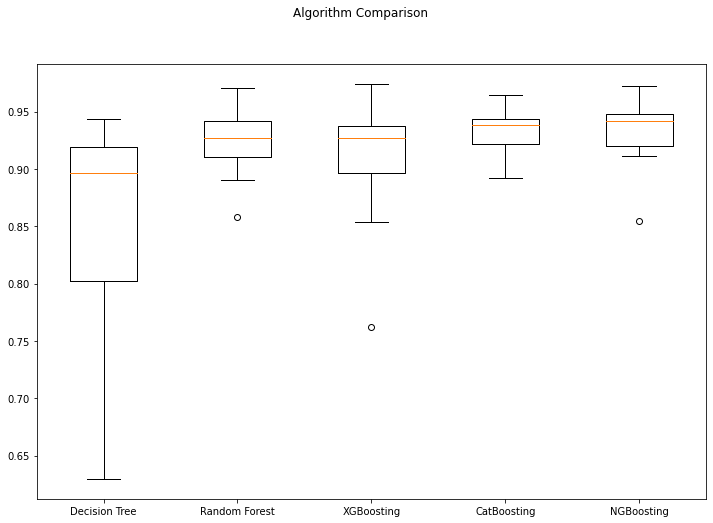

In [117]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Better Visualization
- https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0